# Creation of all types of vectors after text - preprocessing and performing KNN on all the vectors

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.manifold import TSNE    ## To visualize high dimensional data

## Modules to perform Text Preprocessing
import re
import nltk
from nltk.stem.snowball import SnowballStemmer as sno
from nltk.corpus import stopwords

import gensim    ## To build Word2Vec model

C:\Users\Pratheesh\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
#Imports to perform KNN.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# using the SQLite Table to read data.
conn = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", conn)

conn.close()

filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### The function written below returns '1' for all the scores greater than 3 and returns '0' for all scores less than 3. Reviews with score equal to 3 are not included in this analysis.

In [3]:
def partition(x):
    if x < 3:
        return 0
    return 1

## Pandas Series have a map function which apply function object to all the elements
filtered_data['Score'] = filtered_data['Score'].map(partition)

In [4]:
filtered_data.head() #Displays the first five rows of the DataFrame

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
shuffled_df = filtered_data.sample(frac=1,random_state = 123).reset_index(drop=True)  #Shuffling the DataFrame.

In [7]:
shuffled_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,343631,B006BXUY2Y,A3CBCVHIK3G76X,Debra Brinkman,0,0,1,1336262400,"Dark chocolate, granola -- nice combination",I love dark chocolate. I love granola bars. ...
1,313237,B005258BEK,A1QZXEA5FDBQKN,R. Flanagan,0,0,1,1318032000,easy chili,Easy to heat and eat. Expensive but convenient...
2,463144,B002WDCEY8,A2NV2XJR19U9F1,JohnR,0,0,1,1294531200,Best Decaf available in T-disc so far,Best Decaf available in T-disc so far. I'm ho...
3,39685,B005GIF5VU,A3URG3C2QF17RR,"Lynne ""Knitter""",0,0,1,1275696000,crunchy good,Our cats really love these treats. If you jus...
4,397640,B001EYUE5M,A3QQU86AX8XFQO,Becky Stoner,0,0,1,1311465600,"Best ""Pod"" coffee",I've tried many of the K-Cups for the Keurig c...


In [8]:
final = shuffled_df.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"})   #Removing all the duplicate entries in the DataFrame.
final.shape

(364173, 10)

### In this dataset, Helpfulness Numerator should always be less than Helpfulness Denominator. The line of code written below removes all the reviews whose Helpfulness Numerator is greater than Helpfulness Denominator.

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]  
final.shape

(364171, 10)

In [10]:
final['Score'].value_counts()

1    307060
0     57111
Name: Score, dtype: int64

### This is a skewed dataset as the number of positive reviews is much greater than number of negative reviews.

In [11]:
conn = sqlite3.connect('final.sqlite')    #Saving the changes made above into a new sqlite file
c=conn.cursor()
final.to_sql('Reviews', conn, if_exists='replace')
conn.close()

In [4]:
conn = sqlite3.connect('final.sqlite')  #Loading the sqlite file for future use
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText_Stemmed
0,0,343631,B006BXUY2Y,A3CBCVHIK3G76X,Debra Brinkman,0,0,1,1336262400,"Dark chocolate, granola -- nice combination",I love dark chocolate. I love granola bars. ...,love dark chocolate love granola bars ought lo...,love dark chocol love granola bar ought love d...
1,1,313237,B005258BEK,A1QZXEA5FDBQKN,R. Flanagan,0,0,1,1318032000,easy chili,Easy to heat and eat. Expensive but convenient...,easy heat eat expensive convenient healthy goo...,easi heat eat expens conveni healthi good tast...
2,2,463144,B002WDCEY8,A2NV2XJR19U9F1,JohnR,0,0,1,1294531200,Best Decaf available in T-disc so far,Best Decaf available in T-disc so far. I'm ho...,best decaf available far hoping starbucks come...,best decaf avail far hope starbuck come versio...
3,3,39685,B005GIF5VU,A3URG3C2QF17RR,"Lynne ""Knitter""",0,0,1,1275696000,crunchy good,Our cats really love these treats. If you jus...,cats really love treats pick bag within hearin...,cat realli love treat pick bag within hear dis...
4,4,397640,B001EYUE5M,A3QQU86AX8XFQO,Becky Stoner,0,0,1,1311465600,"Best ""Pod"" coffee",I've tried many of the K-Cups for the Keurig c...,ive tried many keurig coffee machine still fin...,ive tri mani keurig coffe machin still find gr...


In [38]:
stop = set(stopwords.words('english')) #set of stopwords

In [14]:
lst = ['won', 'nor', 'not', 'against']  #Removing the words meaning negation from stopwords as it is fundamental for the analysis
for word in lst:
    stop.remove(word)
print(stop)

{'they', 'under', 'other', "wouldn't", 'it', 'itself', 'did', 'out', "aren't", "needn't", 'haven', 'than', 'should', 'are', 'themselves', 'd', 's', 're', 'each', 'theirs', 'ma', 'with', 'm', "didn't", 'from', 'his', 'at', 'we', 'yours', 'only', 'for', 'some', 'does', "you've", 'while', 'me', 'its', 'them', 'these', 'or', 'until', 'which', 'once', 'over', 'herself', 'here', "you'll", 'o', 'hadn', 'hers', 'can', 'being', 'your', "won't", "mustn't", 'he', 'be', 'just', 'there', 'is', "don't", "weren't", 'couldn', 'because', 'y', "hasn't", 'yourself', 'through', 'what', 'her', 'more', 't', 'then', "couldn't", 'doesn', 'all', 'doing', 'mustn', 'any', 'into', 'myself', 'will', "isn't", 'this', 'after', 'him', 'shan', 'of', 'himself', 'too', "shouldn't", 'wouldn', 'hasn', 'those', 'who', 'if', 'between', 'had', 'ain', 'was', 've', 'whom', 'were', 'didn', 'off', "wasn't", 'before', 'wasn', 'you', 'the', 'isn', 'she', 'very', 'up', 'again', 'shouldn', 'my', "haven't", 'above', 'yourselves', "th

In [33]:
def cleanhtml(sentence):
    '''This function removes all the html tags in the given sentence'''
    cleanr = re.compile('<.*?>')    ## find the index of the html tags
    cleantext = re.sub(cleanr, ' ', sentence)  ## Substitute <space> in place of any html tag
    return cleantext

In [34]:
def cleanpunc(sentence):
    '''This function cleans all the punctuation or special characters from a given sentence'''
    cleaned = re.sub(r'[?|@|!|^|%|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [35]:
def preprocessing(series):
    '''The function takes a Pandas Series object containing text in all the cells
       And performs following Preprocessing steps on each cell:
       1. Clean text from html tags
       2. Clean text from punctuations and special characters
       3. Retain only non-numeric Latin characters with lenght > 2
       4. Remove stopwords from the sentence
       5. Apply stemming to all the words in the sentence
       
       Return values:
       1. final_string - List of cleaned sentences
       2. list_of_sent - List of lists which can be used as input to the W2V model'''
    
    i = 0
    str1=" "
    final_string = []    ## This list will contain cleaned sentences
    list_of_sent = []    ## This is a list of lists used as input to the W2V model at a later stage
    #sno = SnowballStemmer("english")
    
    ## Creating below lists for future use
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here
    
    
    for sent in series.values:
        ## 
        filtered_sent = []
        sent = cleanhtml(sent)    ## Clean the HTML tags
        sent = cleanpunc(sent)    ## Clean the punctuations and special characters
        ## Sentences are cleaned and words are handled individually
        for cleaned_words in sent.split():
            ## Only consider non-numeric words with length at least 3
            if((cleaned_words.isalpha()) and (len(cleaned_words) > 2)):
                ## Only consider words which are not stopwords and convert them to lowet case
                if(cleaned_words.lower() not in stop):
                    ## Apply snowball stemmer and add them to the filtered_sent list
                    #s = (sno.stem(cleaned_words.lower()))#.encode('utf-8')
                    filtered_sent.append(cleaned_words.lower())    ## This contains all the cleaned words for a sentence
                    ''''
                    if (final['Score'].values)[i] == 1:
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews
                    '''
        ## Below list is a list of lists used as input to W2V model later
        list_of_sent.append(filtered_sent)
        ## Join back all the words belonging to the same sentence
        str1 = " ".join(filtered_sent)
        ## Finally add the cleaned sentence in the below list
        final_string.append(str1)
        #print(i)
        i += 1
    return final_string, list_of_sent

In [33]:
final_string, list_of_sent = preprocessing(final['Text'])  #Preprocessing the 'Text' column in the DataFrame

In [35]:
final['CleanedText_Stemmed']=final_string   #Creating a new column of Preprocessed Stemmed text

In [ ]:
final['CleanedText_NoStem']=final_string   #Creating a new column of Preprocessed Non-Stemmed text

In [26]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText_Stemmed
0,0,343631,B006BXUY2Y,A3CBCVHIK3G76X,Debra Brinkman,0,0,1,1336262400,"Dark chocolate, granola -- nice combination",I love dark chocolate. I love granola bars. ...,love dark chocolate love granola bars ought lo...,love dark chocol love granola bar ought love d...
1,1,313237,B005258BEK,A1QZXEA5FDBQKN,R. Flanagan,0,0,1,1318032000,easy chili,Easy to heat and eat. Expensive but convenient...,easy heat eat expensive convenient healthy goo...,easi heat eat expens conveni healthi good tast...
2,2,463144,B002WDCEY8,A2NV2XJR19U9F1,JohnR,0,0,1,1294531200,Best Decaf available in T-disc so far,Best Decaf available in T-disc so far. I'm ho...,best decaf available far hoping starbucks come...,best decaf avail far hope starbuck come versio...
3,3,39685,B005GIF5VU,A3URG3C2QF17RR,"Lynne ""Knitter""",0,0,1,1275696000,crunchy good,Our cats really love these treats. If you jus...,cats really love treats pick bag within hearin...,cat realli love treat pick bag within hear dis...
4,4,397640,B001EYUE5M,A3QQU86AX8XFQO,Becky Stoner,0,0,1,1311465600,"Best ""Pod"" coffee",I've tried many of the K-Cups for the Keurig c...,ive tried many keurig coffee machine still fin...,ive tri mani keurig coffe machin still find gr...


In [38]:
conn = sqlite3.connect('final.sqlite')   #Saving the changes
c=conn.cursor()
final.to_sql('Reviews', conn, if_exists='replace', index = False)
conn.close()

In [24]:
with open('list_of_sent_for_input_to_w2v.pkl', 'wb') as pickle_file:  #Saving the list of sentences in a pickle file for future use
    pickle.dump(list_of_sent, pickle_file)

# Finding BoW Vectors:

In [5]:
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(final["CleanedText_Stemmed"].values)

In [5]:
bow.shape

(364171, 71691)

# Finding TF -IDF Vectors:

In [4]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final["CleanedText_Stemmed"].values)
tf_idf.shape

(364171, 71691)

# Finding W2V:

In [4]:
with open('list_of_sent_for_input_to_w2v.pkl','rb') as pickle_file:  #reading the pickle file saved earlier
    list_of_sent = pickle.load(pickle_file)

In [5]:
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 300, workers = -1) #Creating w2v model

In [6]:
words = list(w2v_model.wv.vocab)
print(len(words))

33242


In [7]:
w2v_model.wv.most_similar('tasty')   #Finds the most similar word in the vectors

[('goodlife', 0.21763426065444946),
 ('lasting', 0.21172207593917847),
 ('car', 0.20952464640140533),
 ('painless', 0.20927377045154572),
 ('sours', 0.20796537399291992),
 ('bigalow', 0.20592519640922546),
 ('princes', 0.20306077599525452),
 ('trend', 0.2021816074848175),
 ('undying', 0.19820336997509003),
 ('consisteny', 0.19772101938724518)]

In [8]:
'''
This is a function to calculate average w2v
'''
def cal_avg_w2v(list_of_sent, w2v_model):
    sent_vectors = []   #Creating an empty list
    for sent in list_of_sent:
        sent_vec = np.zeros(300)  #Initializing the sentence vector to 0 
        cnt_words = 0
        for word in sent:
            try:
                vec = w2v_model.wv[word]  #Calculating the word vector using w2v
                sent_vec += vec   #Add the word vector into sentence vector
                cnt_words +=1     #Sum of all the word counts
            except:
                pass
        sent_vec /= cnt_words     #To find the sentence vector
        sent_vectors.append(sent_vec)  #Adding sentence vector to final list
    return sent_vectors

In [9]:
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 300, workers = 4)

In [10]:
sent_vectors = cal_avg_w2v(list_of_sent, w2v_model)  #calling the above function

C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [13]:
sent_vectors[0]

array([  8.09912375e-02,  -7.31081396e-03,  -3.88035361e-01,
         1.21643839e-01,   1.74585551e-02,   3.26087069e-01,
         1.81741160e-02,  -6.30086215e-02,   7.06621462e-02,
         1.31132193e-01,   5.69199590e-01,   4.28993894e-02,
        -2.09062793e-01,   3.04708611e-01,   4.07150549e-01,
        -4.48449448e-01,   1.73123824e-01,  -4.01803705e-01,
        -4.41478920e-01,   4.38796334e-01,   7.59430223e-02,
         5.41917674e-01,   6.99762935e-01,  -2.52840666e-02,
         6.72755764e-01,  -2.10199461e-01,  -5.31305432e-01,
        -4.93084138e-01,   3.03040948e-02,  -1.41039650e-01,
         3.09656100e-01,  -2.12901182e-01,  -6.27510063e-01,
         4.60471362e-01,  -1.34831004e-01,  -2.10679640e-01,
        -3.68631740e-01,  -3.29655111e-01,  -1.21363983e-02,
        -9.07024001e-02,  -7.43121839e-02,  -4.24322413e-01,
         7.60037101e-01,  -3.85089459e-01,   7.45768374e-02,
        -2.38245673e-01,  -3.35284830e-01,   3.17669124e-02,
        -3.32285091e-01,

In [14]:
with open('sent_vec_avg_w2v.pkl','wb') as pickle_file:  #Saving as pickle file
    pickle.dump(sent_vectors,pickle_file)

In [15]:
with open('sent_vec_avg_w2v.pkl','rb') as pickle_file:  #Loading for future use
    sent_vectors = pickle.load(pickle_file)

In [15]:
sent_vec_array= np.array(sent_vectors)    #Converting the list into numpy array

In [16]:
type(sent_vec_array)

numpy.ndarray

In [17]:
sent_vec_array = sent_vec_array[~np.isnan(sent_vec_array).any(axis=1)]   #Removing any NaN value if present in the numpy array

In [18]:
'''
This function calculates TF - IDF weighted average W2V
It takes in 4 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       3. tf_idf - This is the TF-IDF model built using the same reviews/sentences - it is the TF-IDF sparse matrix
       4. tfidf_feat - This is the feature vector constructed from the TF-IDF model
       
       Return Value:
       tfidf_sent_vectors - This is a list of sentence/review vectors constructed by using tfidf weighted average on the word vectors
'''
def cal_tfidf_avg_w2v(list_of_sent, w2v_model, tf_idf,tfidf_feat):
    tfidf_sent_vectors = []
    row = 0
    for sent in list_of_sent:
        sent_vec = np.zeros(300)
        weighted_sum = 0
        for word in sent:
            try:
                vec = w2v_model.wv[word]
                tfidf = tf_idf[row, tfidf_feat.index(word)]
                sent_vec += vec*tfidf
                weighted_sum += tfidf
            except:
                pass
        print(row, weighted_sum)
        sent_vec /= weighted_sum
        tfidf_sent_vectors.append(sent_vec)
        row +=1
    return tfidf_sent_vectors

In [19]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final['CleanedText_NoStem'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 300, workers = -1)

In [20]:
tfidf_sent_vectors = cal_tfidf_avg_w2v(list_of_sent[:60000], w2v_model, tf_idf, tfidf_feat)  #calling the above function for 60k points. It prints the row and weighted sum just to check the progress.

0 11.4834078389
1 3.01966311186
2 3.39647362514
3 2.98930205356
4 3.50504024509
5 5.87020874188
6 4.82832337816
7 3.30965006021
8 13.3633721815
9 5.9591790982
10 4.19633041263
11 7.03630675404
12 4.45701855639
13 7.20444397612
14 2.6245981318
15 6.51838105908
16 4.75058081519
17 4.10820314049
18 2.98061772699
19 11.1826034093
20 5.77269942684
21 4.56230631627
22 6.83415456649
23 3.65739694923
24 4.90446895312
25 4.56436691015
26 5.20172363155
27 2.63015443663
28 3.32891287156
29 4.64532073294
30 5.38109442929
31 12.0535820933
32 3.43277088748
33 3.21453809462
34 3.31801924638
35 5.9528072221
36 2.59453645933
37 3.80614688663
38 4.27890340517
39 5.03342566601
40 4.9371725065
41 6.09480142052
42 5.99231441597
43 4.83017067951
44 3.00162185509
45 14.2327274249
46 4.86235841927
47 2.95794976782
48 4.27426430354
49 4.06211406966
50 8.2634894257
51 6.31602968608
52 6.43004392059
53 5.73464028925
54 5.35482891628
55 3.61385317791
56 9.85512032167
57 3.29583522118
58 3.35303931539
59 4.4323407

465 11.7100138369
466 4.53276213949
467 6.12733413411
468 4.32621463219
469 4.92232088937
470 9.49110154474
471 6.41119261814
472 3.72323600983
473 5.48592237129
474 6.82883240099
475 8.45327734579
476 5.20971115491
477 4.6034462839
478 5.56475415812
479 6.62719645867
480 3.4727286614
481 7.88497720192
482 4.06408306183
483 6.78310806771
484 5.72446770701
485 6.02092467159
486 15.4480455597
487 7.3176544249
488 9.58856859148
489 3.096967736
490 6.40057061461
491 7.8767368639
492 1.82890939437
493 6.26993415054
494 8.86494736733
495 5.23761756726
496 4.68715095679
497 8.10933208556
498 4.7188201502
499 9.36441750797
500 4.40952122945
501 4.9039604197
502 11.7977402353
503 7.25170065374
504 3.52889161998
505 5.44882665464
506 3.9931708442
507 5.32294326324
508 6.55802239597
509 6.11504873066
510 6.7751188351
511 4.63557576466
512 6.10716030492
513 4.17794007444
514 9.04152280193
515 5.84278173747
516 7.03768435117
517 5.64166760177
518 6.42980305412
519 10.4255240715
520 4.73503199638
52

925 9.89499827737
926 13.1938565547
927 5.27978034226
928 4.93559984416
929 12.540122626
930 4.11868821741
931 2.70705531461
932 6.99108436093
933 4.53737017023
934 3.89716917852
935 8.82071586061
936 5.06871434277
937 5.86486860437
938 5.06880046694
939 7.82306251522
940 9.15736950769
941 11.7933046881
942 3.71063637593
943 5.47472704136
944 9.81627197377
945 4.63199397393
946 3.96074076735
947 3.21501652137
948 2.98445210462
949 7.4832412568
950 7.14062941281
951 3.13563067742
952 5.74723573008
953 3.64825571622
954 5.80443260905
955 6.71539782387
956 3.86264288423
957 5.57811652617
958 8.79198708031
959 4.57713262403
960 6.56603485065
961 4.33014573293
962 8.53068697148
963 4.36818754118
964 3.92384709738
965 3.7184112977
966 3.00115746418
967 3.41688549374
968 12.1916362867
969 5.40060184264
970 3.25647053727
971 6.17513172812
972 8.53278209954
973 4.04939570106
974 3.29529149515
975 11.8612705351
976 7.78470917432
977 3.98943201962
978 5.30002767276
979 8.03058260449
980 7.0047512

1365 5.33164805832
1366 8.39868768379
1367 5.31860627184
1368 7.2291005719
1369 7.17153548119
1370 5.56691689936
1371 3.24087642949
1372 3.76631789328
1373 10.7189219843
1374 4.71549691655
1375 9.92610988982
1376 2.95667285244
1377 6.29819837463
1378 9.21744616476
1379 10.5486919479
1380 6.07775911564
1381 2.57567886516
1382 3.2143706505
1383 9.57953469692
1384 9.10636364815
1385 4.75330612208
1386 2.71645656055
1387 12.2729709487
1388 3.83601491004
1389 5.64918730119
1390 4.73733936972
1391 4.52378040991
1392 3.17815919647
1393 3.56794504378
1394 4.03125290765
1395 5.80063341546
1396 2.69781065105
1397 3.03874730232
1398 8.74145407056
1399 3.60519825127
1400 4.71752797279
1401 3.95198425314
1402 5.14884115348
1403 3.9648271356
1404 8.15172075761
1405 4.69604351808
1406 9.95132419315
1407 3.73199178276
1408 2.8141090058
1409 11.7927590983
1410 3.40215390488
1411 4.38672648678
1412 5.48432997537
1413 11.9646590596
1414 2.68672574609
1415 3.91248792052
1416 3.09862561237
1417 7.019061705

1799 13.9361408996
1800 4.58392625316
1801 3.47533319914
1802 5.20504498369
1803 6.94303641713
1804 4.10193918581
1805 3.82631680761
1806 5.90259714418
1807 5.58306957297
1808 2.64889007022
1809 9.04533878143
1810 5.22195083159
1811 3.9722078292
1812 6.89450673492
1813 5.22329653996
1814 9.97434040047
1815 6.84852331399
1816 5.33185672303
1817 9.24190411878
1818 7.32172520786
1819 3.92732753765
1820 12.2610909139
1821 4.97184754767
1822 6.90587786789
1823 7.85488150907
1824 3.6540009861
1825 6.68535066238
1826 3.22733181583
1827 15.6155702338
1828 5.63503537137
1829 8.42424871655
1830 7.98371993661
1831 4.35997216913
1832 3.97727388795
1833 6.59391100688
1834 4.1318813858
1835 3.39502506262
1836 3.68660374066
1837 3.57225021184
1838 11.6031205752
1839 4.07129095661
1840 8.98384439558
1841 2.69801167403
1842 5.79779039555
1843 8.91575903971
1844 5.14846014393
1845 3.05787012714
1846 4.99556533818
1847 4.28246893325
1848 4.83594788711
1849 4.84949259519
1850 10.2892932439
1851 7.42255380

2667 4.49166589425
2668 3.78383045786
2669 3.4268006534
2670 6.99604434381
2671 6.07940357219
2672 3.39680288191
2673 4.24165865637
2674 8.50971004874
2675 15.906116566
2676 10.8408832546
2677 7.12873958014
2678 4.50573065522
2679 8.58198977682
2680 8.05686623101
2681 3.25389753799
2682 5.3057216006
2683 3.13429981175
2684 5.18897283075
2685 9.97404845741
2686 8.22345651878
2687 2.70397058149
2688 14.4467123733
2689 3.51510034973
2690 20.0440343389
2691 4.77263885466
2692 4.64334946292
2693 3.04301045422
2694 3.5917444413
2695 4.15493262712
2696 3.3749805437
2697 6.24408100483
2698 2.81762473494
2699 3.15064483215
2700 3.3175913575
2701 7.19458338041
2702 2.7344137728
2703 4.51225280662
2704 4.76361533557
2705 10.5974931605
2706 7.52964462409
2707 4.56966991901
2708 8.91368747539
2709 5.466737265
2710 5.65936487039
2711 3.7667476399
2712 8.01232466846
2713 8.17539304313
2714 5.04715392283
2715 4.8366764718
2716 2.82334513498
2717 10.3249138228
2718 4.07916173156
2719 11.4555446317
2720

3101 6.56795086067
3102 7.34006460395
3103 5.58501301025
3104 2.3652438931
3105 10.2987090649
3106 4.19107631754
3107 6.86249415371
3108 5.45793171321
3109 4.17614365226
3110 5.6465291714
3111 6.6769465666
3112 3.46894694172
3113 13.1419007534
3114 8.9806532683
3115 4.64466021853
3116 8.01200338637
3117 7.89875673411
3118 3.01814489887
3119 8.76872733024
3120 7.59484714825
3121 4.35330408409
3122 7.26009839023
3123 3.91156490376
3124 12.911848852
3125 4.68750060207
3126 5.92216548559
3127 5.2567995481
3128 4.05231498672
3129 10.3322027257
3130 5.76076124536
3131 8.1465571228
3132 5.99826726438
3133 4.42030126613
3134 3.0340174406
3135 7.93406732779
3136 9.45672184491
3137 3.7186993381
3138 6.64101046028
3139 3.68788058391
3140 3.63999288974
3141 6.06810179416
3142 4.00938659966
3143 11.1271464155
3144 10.1479985848
3145 4.26038782921
3146 4.3811889973
3147 3.80971232795
3148 4.92058125247
3149 3.85219902575
3150 8.08338835435
3151 4.13619150592
3152 2.91810366935
3153 10.458805607
3154

3536 7.10951213978
3537 8.11998589458
3538 7.28140005125
3539 4.13724327047
3540 5.12063152754
3541 4.58915424562
3542 3.23229232049
3543 5.67732779918
3544 4.91640980055
3545 3.64392987555
3546 3.92563027123
3547 7.36957990855
3548 11.0093254474
3549 5.46495777669
3550 5.97793624422
3551 7.26504869531
3552 3.88989925942
3553 8.97069570893
3554 2.60497043635
3555 10.646961779
3556 10.5122834534
3557 3.27451000089
3558 9.74218995114
3559 5.17282343447
3560 7.05447521256
3561 4.14468961191
3562 3.24243164307
3563 4.00441921113
3564 5.50141875594
3565 5.32886790171
3566 7.32444581233
3567 3.22742699508
3568 3.66995503948
3569 6.02854821054
3570 4.88048890137
3571 6.66303748148
3572 3.03502272115
3573 4.97383865694
3574 4.11525033494
3575 3.40255270838
3576 9.68004912284
3577 9.89674213253
3578 6.12075169088
3579 3.1981199822
3580 4.03236948842
3581 7.03820338012
3582 7.54284753427
3583 4.55092599288
3584 3.8459593989
3585 6.99429030749
3586 4.40352323553
3587 12.6926250109
3588 3.12206130

3972 9.47113233253
3973 3.93706778876
3974 3.86654786263
3975 2.14123046591
3976 12.1686795162
3977 4.81661877267
3978 4.09505027631
3979 4.03854987845
3980 13.6077179086
3981 10.7057288423
3982 4.74894242315
3983 8.49325329933
3984 4.30395717363
3985 4.73516699171
3986 3.21108158257
3987 5.13972503236
3988 9.79236362874
3989 3.69646334641
3990 3.69250937301
3991 10.9996758541
3992 7.03731114807
3993 22.0877865053
3994 7.49871288176
3995 4.71643386054
3996 11.3927398638
3997 7.00778449331
3998 1.81620825234
3999 3.4720561848
4000 3.95178102897
4001 10.2216035415
4002 3.9889243147
4003 4.21517143919
4004 4.05791349154
4005 5.38248330459
4006 11.7806668549
4007 3.63753511412
4008 7.08884502107
4009 16.3373858695
4010 3.33516303426
4011 4.5375873054
4012 9.07088055018
4013 3.66737156232
4014 6.8771444262
4015 7.46314797435
4016 12.2260193988
4017 6.77834844679
4018 3.50138437643
4019 6.15941602886
4020 3.40374309194
4021 6.91178060705
4022 3.98885440887
4023 4.70241890587
4024 4.912490075

4406 9.17486952881
4407 4.84626930077
4408 8.65813753666
4409 4.83331407161
4410 4.84838467313
4411 2.81564339534
4412 4.25205909849
4413 5.42155068751
4414 3.04611012544
4415 17.5473973714
4416 10.0360357152
4417 9.20061621019
4418 3.26719343985
4419 5.67316194966
4420 3.4562377879
4421 3.51430514135
4422 9.29993105825
4423 14.8130438273
4424 7.18564603604
4425 2.68056372138
4426 2.86546226235
4427 4.37331399299
4428 5.59956061903
4429 4.8203384948
4430 11.6987053692
4431 4.90791401443
4432 3.36937863178
4433 3.74450882483
4434 6.77091644373
4435 4.14792907341
4436 3.32266688702
4437 5.96013754091
4438 8.52323190424
4439 5.0981953295
4440 5.8138104444
4441 10.3463294681
4442 5.00075520949
4443 5.30763806711
4444 6.90073108119
4445 10.4506501522
4446 10.6825413604
4447 2.64313068771
4448 11.3227330172
4449 3.48996213774
4450 5.90712260043
4451 3.93640863331
4452 2.33904014055
4453 16.5369753379
4454 5.86249983976
4455 5.31105135876
4456 9.84839124671
4457 3.732698592
4458 2.98687926825

4840 12.5322963756
4841 9.90755327675
4842 8.20788470511
4843 5.22732310838
4844 8.37223852751
4845 10.3891051656
4846 5.75558970404
4847 2.77087277909
4848 6.28094943216
4849 2.72210770063
4850 2.07611705096
4851 12.9994877601
4852 5.40542691859
4853 3.85574341794
4854 3.3611089155
4855 5.79543208587
4856 4.71574160316
4857 4.80183163588
4858 5.57972145774
4859 3.20800374275
4860 4.46610602474
4861 4.68149147147
4862 5.8275584264
4863 10.7722950507
4864 3.08926567613
4865 2.3310433306
4866 7.63715504092
4867 6.29982118608
4868 7.80241722329
4869 10.221076408
4870 6.99014295925
4871 3.89612201911
4872 5.65637949623
4873 5.36481067859
4874 6.82154047869
4875 12.1937932664
4876 19.7624014711
4877 7.09172453559
4878 5.9419672451
4879 8.02685578585
4880 3.1171725885
4881 4.34734735212
4882 4.23503851742
4883 8.06388206705
4884 3.22842661443
4885 7.20497991861
4886 4.5799825783
4887 11.1127323729
4888 4.08070692277
4889 3.54148259865
4890 5.90862754242
4891 7.98025120984
4892 6.0029994846
4

5276 5.01446285269
5277 3.14623742699
5278 5.00327424763
5279 5.02500349469
5280 4.44412752415
5281 6.74553162027
5282 4.53533451388
5283 5.46550961714
5284 4.0348667547
5285 16.3103317243
5286 3.52867053722
5287 13.8582297867
5288 4.46392596652
5289 4.97088934281
5290 5.2668244054
5291 4.35320713929
5292 6.44562892197
5293 18.5456109676
5294 3.58959065963
5295 4.36527084832
5296 6.03328669281
5297 3.20251759744
5298 5.97396809836
5299 4.93701088892
5300 3.53497320654
5301 6.19568282836
5302 5.15074204737
5303 16.3134279202
5304 3.96088081152
5305 7.65713007938
5306 6.59063193663
5307 7.37016654716
5308 4.23596439816
5309 6.97207118846
5310 3.86390750412
5311 14.8425349883
5312 3.661021727
5313 4.46507933745
5314 5.4782238071
5315 8.60836817009
5316 7.93554849833
5317 4.65525568722
5318 4.09500161491
5319 5.58330535736
5320 3.07562918017
5321 5.9599489917
5322 2.5745826504
5323 5.97563282413
5324 9.71368180911
5325 5.49980400074
5326 18.5818257971
5327 2.81278088719
5328 10.6773591759


5712 4.87033423621
5713 8.66209096653
5714 9.44339898534
5715 4.44682736381
5716 7.42254052021
5717 9.46653885374
5718 6.68005791639
5719 4.22239580363
5720 3.02256483313
5721 4.11445739001
5722 10.8972242975
5723 8.2212800051
5724 3.44165606216
5725 4.19217142755
5726 4.00662406739
5727 6.56608737246
5728 4.44343749454
5729 2.88475135457
5730 10.0188904432
5731 5.69228541635
5732 10.6590728123
5733 15.4893776357
5734 6.31826609012
5735 5.24179449482
5736 6.85357816956
5737 2.4150018212
5738 3.97519671598
5739 3.60341534527
5740 3.22237545238
5741 9.4446146838
5742 5.65370314546
5743 5.36518099687
5744 8.36240845495
5745 8.40776101555
5746 3.29991893908
5747 3.7098142321
5748 11.6165805081
5749 10.2121923765
5750 3.27664795459
5751 4.33140823096
5752 4.26744788331
5753 4.37817846446
5754 7.77610918481
5755 7.27540828932
5756 10.7295748418
5757 4.26863118683
5758 5.27967483837
5759 8.00389407607
5760 6.56676580313
5761 4.29524241262
5762 4.21241697039
5763 13.6671059993
5764 5.982909623

6146 3.69828253457
6147 7.27456594373
6148 6.69080813498
6149 8.71120785092
6150 2.89205837425
6151 8.87563113888
6152 4.86461157868
6153 7.03006094788
6154 5.41775377636
6155 1.33799752896
6156 3.56696351011
6157 4.97977192982
6158 4.2631247466
6159 6.73031145596
6160 3.99048304621
6161 3.78989674078
6162 9.81821451735
6163 6.04691405206
6164 4.22332913979
6165 4.90521708252
6166 4.05651827742
6167 4.83957401687
6168 11.0650909564
6169 6.98049027955
6170 3.46797712814
6171 5.75418250493
6172 6.02034766472
6173 4.8794612792
6174 3.51615291597
6175 4.52707621384
6176 9.13412673229
6177 7.674297456
6178 9.09779861906
6179 3.03705581195
6180 3.75176590029
6181 3.59832842534
6182 7.53285132509
6183 10.7205392687
6184 3.04376830983
6185 2.75635982048
6186 5.34756045997
6187 10.6737094706
6188 6.84529294146
6189 6.01226041272
6190 10.5920863703
6191 3.38412477212
6192 7.02574337176
6193 5.41917000012
6194 6.27865233454
6195 10.2222156358
6196 17.500771934
6197 5.11922830543
6198 7.3690083931

6582 12.871164492
6583 4.8798989332
6584 3.32676812597
6585 2.83166743935
6586 3.39017197077
6587 7.96214138888
6588 7.67672935486
6589 5.45820474168
6590 4.09341544679
6591 8.79155359893
6592 4.27590075893
6593 2.47518108224
6594 5.4946778221
6595 6.08490494537
6596 6.19268735688
6597 7.23653704228
6598 6.03314620703
6599 3.80684552301
6600 5.60010173179
6601 4.60515262038
6602 3.83158958314
6603 3.78270642457
6604 4.52035506469
6605 7.68919109175
6606 9.73708602504
6607 4.72811582264
6608 3.92544062478
6609 4.70723415918
6610 3.87703044197
6611 6.36010791158
6612 7.68695128226
6613 3.13697009801
6614 4.33234918503
6615 2.95528131825
6616 2.60347684286
6617 4.45408239901
6618 9.96374335972
6619 7.33133392363
6620 8.37259363546
6621 3.43071274397
6622 3.76105491366
6623 6.16157123949
6624 10.4048034851
6625 7.49601684258
6626 5.06163302644
6627 3.32458993377
6628 5.26450309385
6629 3.98852166225
6630 4.34690000105
6631 6.04092974688
6632 3.05876235724
6633 4.78311999863
6634 3.49645819

7016 7.44141649343
7017 7.29534086305
7018 4.4668050043
7019 4.29720368983
7020 4.60019056708
7021 7.59792650716
7022 6.50497247809
7023 4.592479833
7024 4.42900682868
7025 8.465217771
7026 6.99367375843
7027 4.79620650814
7028 3.95056791607
7029 7.45544307562
7030 4.12031139767
7031 4.67968474932
7032 3.38623541915
7033 4.63218116769
7034 3.90696578457
7035 6.05152150744
7036 8.51779865725
7037 9.20241316116
7038 4.20709561327
7039 5.44580548538
7040 3.2100708927
7041 11.9713098807
7042 4.50618181272
7043 7.75109845085
7044 3.81552759273
7045 4.59697173719
7046 7.57334211556
7047 3.0711696451
7048 6.55718968525
7049 7.30507384161
7050 5.15238809409
7051 3.62239407319
7052 6.36840833932
7053 6.99939532267
7054 3.61462803918
7055 8.75538313791
7056 5.50140747324
7057 4.27343401209
7058 7.45697847247
7059 3.71755612003
7060 12.8182112519
7061 5.46752939119
7062 5.68720324616
7063 2.93741454739
7064 14.1996767193
7065 6.4611602511
7066 11.9784671585
7067 11.3153476926
7068 9.32972477584
7

7450 6.852477363
7451 8.36549991319
7452 3.93104972708
7453 7.33546364903
7454 7.06654993656
7455 8.93428475458
7456 7.0583718776
7457 9.04817646341
7458 6.99928654321
7459 10.1743005238
7460 3.54400060071
7461 5.45357475926
7462 3.64677162843
7463 3.3109835612
7464 7.19879601092
7465 4.24515525235
7466 3.61590336184
7467 2.42963998722
7468 4.12820435586
7469 14.678969153
7470 4.92529849084
7471 5.00198993335
7472 10.0882194994
7473 9.11538336655
7474 4.92527697057
7475 5.06901449462
7476 4.73052934939
7477 5.9489852977
7478 6.78799996021
7479 16.1869448773
7480 4.06750337659
7481 9.83487346743
7482 4.52924030947
7483 3.59484917792
7484 6.368528597
7485 5.47029185202
7486 4.18617253787
7487 4.48051698722
7488 6.32163820309
7489 2.29536676253
7490 11.304415691
7491 8.48412928954
7492 2.31399333069
7493 5.98150320902
7494 3.4021787233
7495 7.93271569957
7496 4.28236477277
7497 6.00279002789
7498 6.24910385668
7499 5.03346548352
7500 3.04712231025
7501 10.7099182098
7502 4.02375669867
750

7886 4.79732621781
7887 7.10102248324
7888 2.49121248095
7889 3.78565552812
7890 4.2220412813
7891 3.06289019498
7892 7.05225494827
7893 4.46969837579
7894 5.52868896256
7895 5.51721298188
7896 7.58322524367
7897 8.50869266737
7898 17.2817745213
7899 4.03956677516
7900 8.19388528717
7901 12.3869644002
7902 3.77141119721
7903 7.51305081406
7904 5.64979889345
7905 4.21536829772
7906 14.4593051914
7907 3.77812538845
7908 8.10148938584
7909 5.99509387862
7910 7.73136431755
7911 6.78603846251
7912 3.06024041566
7913 5.53759890416
7914 3.68510320885
7915 5.59648016345
7916 3.71355386113
7917 6.38829310566
7918 12.796681285
7919 3.63041206308
7920 6.33913038839
7921 6.96575624185
7922 6.28084183095
7923 3.40668572243
7924 4.11592159216
7925 3.35284999873
7926 5.78084012068
7927 2.89542739716
7928 3.76675472277
7929 5.02389333973
7930 3.34022248934
7931 9.97909033362
7932 3.08549737306
7933 5.17517262707
7934 6.49249964876
7935 4.93515076559
7936 3.84057225453
7937 3.62734844222
7938 3.3265796

8322 4.33035862559
8323 9.74677278347
8324 2.21006783752
8325 5.83027232729
8326 7.29929045182
8327 3.8041717887
8328 6.69686364381
8329 3.72525306816
8330 5.42256516455
8331 4.76112994897
8332 7.02656621882
8333 4.1468594843
8334 3.86457638368
8335 5.66926848605
8336 5.05523424268
8337 9.3144159793
8338 9.86283106306
8339 7.08638711209
8340 3.7987855803
8341 2.98399580759
8342 11.3415248297
8343 6.88175102023
8344 6.51873911518
8345 2.6889539467
8346 6.55333846626
8347 4.2249831556
8348 16.7451608996
8349 3.26964431705
8350 6.68145340262
8351 3.62357594619
8352 6.17267479576
8353 8.46674887646
8354 3.10619168557
8355 3.21057468407
8356 5.68600053452
8357 6.99709584656
8358 6.61634091496
8359 4.23064818391
8360 13.2118920266
8361 3.21691418354
8362 3.40390733302
8363 6.95747124936
8364 7.64351392308
8365 6.61763354458
8366 4.47980069879
8367 6.41010133836
8368 3.37060146454
8369 13.008077357
8370 4.91483764922
8371 13.1781251351
8372 9.01345720364
8373 7.51106004238
8374 9.44199302778


8756 12.8924271132
8757 3.70763383936
8758 3.36578569875
8759 9.19686547954
8760 18.8693771263
8761 4.90618694835
8762 6.4357731763
8763 7.72213613402
8764 4.39148299468
8765 9.06018448766
8766 5.89620090133
8767 4.3341344744
8768 4.69571720008
8769 6.22988850155
8770 3.17615146686
8771 5.41186131105
8772 7.68522370233
8773 5.13823355603
8774 5.04718687376
8775 8.2784058236
8776 6.58832589879
8777 5.87797742848
8778 8.11026522711
8779 5.75370557612
8780 6.11124557931
8781 9.76317832045
8782 4.62696541337
8783 3.48843469831
8784 8.28727799753
8785 3.2222407719
8786 3.29910982391
8787 3.89243591951
8788 13.0476476979
8789 3.07678572639
8790 16.1496878507
8791 3.64135490025
8792 11.6480512184
8793 3.49498015587
8794 3.93671274608
8795 2.43151826288
8796 3.95617529373
8797 7.13191135474
8798 6.88815710031
8799 7.97072765047
8800 4.3685352574
8801 2.4649490263
8802 5.64258498385
8803 9.30128410863
8804 4.1381045919
8805 8.87399746379
8806 8.61512807135
8807 4.91659170477
8808 7.65437092404


9191 4.64928918819
9192 5.26834530674
9193 2.93547106728
9194 4.02322650278
9195 7.07041499606
9196 7.58755686087
9197 4.86085753841
9198 3.4113806809
9199 21.3273699595
9200 4.19312104091
9201 5.29077154609
9202 8.62957796832
9203 4.01252436147
9204 3.22082372361
9205 4.1182606527
9206 5.24904497072
9207 3.54346755705
9208 4.20016454596
9209 4.07737922226
9210 10.1835681831
9211 7.36084042661
9212 8.96773645334
9213 4.43277086129
9214 3.56483245089
9215 6.29893722185
9216 4.63727681894
9217 2.97220097777
9218 5.01650135177
9219 19.1330247861
9220 4.25532588236
9221 3.96101427473
9222 4.31886892772
9223 5.99677655339
9224 5.02015968995
9225 5.14059720318
9226 4.53687058271
9227 5.3263336958
9228 3.81519300964
9229 4.07673992487
9230 3.26102685052
9231 4.76792935009
9232 5.69362732895
9233 4.10010856661
9234 7.32281175667
9235 5.28802326691
9236 4.79287802074
9237 3.16438601723
9238 6.14081148707
9239 2.14908747968
9240 5.01382233591
9241 3.75209555366
9242 4.77455118176
9243 9.11522601

10055 3.0746865977
10056 7.57826965967
10057 6.36887468352
10058 11.9244816853
10059 4.69974212569
10060 4.84492021205
10061 12.6892151297
10062 4.60768456224
10063 9.47769619972
10064 5.36374545078
10065 10.4911268779
10066 5.3188968609
10067 5.36238991243
10068 3.29956880838
10069 4.70298654186
10070 3.67720929162
10071 5.28103858864
10072 2.90008758621
10073 4.92818277705
10074 4.67836495351
10075 7.05950514223
10076 7.76019893218
10077 6.99671876525
10078 3.85784684081
10079 4.93623238253
10080 4.09946787435
10081 5.94642882117
10082 4.20365685529
10083 4.07521466993
10084 4.33025385574
10085 4.93448562646
10086 19.3359085496
10087 3.83099311366
10088 8.05147899895
10089 3.21025670012
10090 6.243863613
10091 3.798446233
10092 5.21073660836
10093 3.03965874769
10094 4.81806085158
10095 8.92912998224
10096 4.53501836949
10097 9.07623868841
10098 10.915585178
10099 5.12653032424
10100 3.69638447296
10101 4.03094138945
10102 27.277843248
10103 9.12020512951
10104 8.0331873753
10105 4.1

10469 3.96997140599
10470 9.14891829251
10471 3.90433634675
10472 5.10745274243
10473 12.704357342
10474 8.15745470354
10475 3.85137841573
10476 10.5918556231
10477 7.74871242691
10478 2.69590207553
10479 3.43426762446
10480 9.09985318798
10481 7.33490520319
10482 7.03727896383
10483 3.97695951461
10484 12.7322757707
10485 6.60566307655
10486 6.73740795091
10487 5.38379421338
10488 15.8318606206
10489 7.28712494396
10490 8.81305932218
10491 14.4627704681
10492 3.54813022539
10493 5.21996537857
10494 9.90084962201
10495 11.8837664197
10496 2.58482909426
10497 7.41072384692
10498 3.86885175738
10499 6.04013893538
10500 3.23392225505
10501 5.00435174328
10502 4.21008204206
10503 4.04725457891
10504 5.70433808241
10505 4.11820217157
10506 3.28855980708
10507 3.6982129205
10508 7.13845493101
10509 4.25915174797
10510 7.30920191063
10511 7.80299505731
10512 8.5793928821
10513 20.6851261839
10514 4.69517375128
10515 5.62535272083
10516 4.5347157327
10517 7.07999396791
10518 3.56809362649
1051

10882 2.12371990052
10883 7.2961313198
10884 5.47583293828
10885 4.02598130669
10886 5.10667920446
10887 6.4094668347
10888 3.55762004453
10889 5.9587946151
10890 7.82172732298
10891 5.37769069506
10892 4.082328331
10893 10.1907513178
10894 4.16726075718
10895 4.13633308151
10896 6.37758610348
10897 4.27683268156
10898 5.46020684922
10899 4.92597344481
10900 9.18282318245
10901 5.01865537599
10902 6.88125572744
10903 11.0956076145
10904 2.64933199073
10905 5.23595824791
10906 6.0126924843
10907 4.01952963433
10908 7.48373970073
10909 4.64729605394
10910 4.14738130074
10911 6.19925776162
10912 10.6291344049
10913 12.3043748584
10914 6.77005253581
10915 3.51685297249
10916 8.64051057574
10917 3.49136401951
10918 4.43036974549
10919 3.88562586682
10920 5.34173618039
10921 2.93859027251
10922 3.79888080943
10923 8.53696838132
10924 11.8161587703
10925 5.26472885981
10926 4.47723633889
10927 3.64677710003
10928 3.92518294842
10929 3.21954923141
10930 5.79342924862
10931 8.77177710909
10932 

11296 5.04365029522
11297 3.48118069427
11298 8.21353309199
11299 5.86174837563
11300 5.83791353058
11301 3.33123789669
11302 3.75456372336
11303 4.86945229032
11304 2.52065142741
11305 2.74549744729
11306 6.98151423891
11307 5.89655242561
11308 26.7720771282
11309 8.03768481145
11310 7.90513518323
11311 4.0571587919
11312 4.4524913914
11313 6.25690456794
11314 4.55782754652
11315 8.60022761096
11316 5.49933166319
11317 3.57156614942
11318 4.92007982491
11319 4.17876148719
11320 3.60919495877
11321 4.74055407611
11322 4.45833800645
11323 4.44418824527
11324 7.0438458807
11325 3.32653061896
11326 7.66619799374
11327 6.4756238135
11328 3.91273841592
11329 6.21829892887
11330 7.2543062307
11331 4.73573804022
11332 7.17406333407
11333 5.35721266246
11334 6.30390359174
11335 4.35668286593
11336 3.41782829348
11337 4.02074548381
11338 5.21977723565
11339 5.39114055063
11340 6.76825930099
11341 3.03692698352
11342 4.55727077825
11343 4.44129267715
11344 10.9135300004
11345 3.11033897817
11346

11709 6.11443418125
11710 4.41017302894
11711 2.12985846302
11712 4.96096434333
11713 5.73201948677
11714 7.1541990708
11715 3.60049191801
11716 3.73887217529
11717 4.17394367184
11718 4.06111793544
11719 12.9523395754
11720 4.59762056164
11721 4.129170525
11722 2.81723622322
11723 2.86290359564
11724 8.94206191138
11725 11.2228665126
11726 6.75429504808
11727 2.93767494439
11728 3.69185864829
11729 3.19833016457
11730 9.13864876046
11731 3.28895764345
11732 5.10986820588
11733 3.29408039281
11734 4.81527434326
11735 3.35070374458
11736 8.43446163459
11737 3.18655348826
11738 6.49413882221
11739 18.4616983815
11740 3.8214207954
11741 5.31485189696
11742 7.01297583624
11743 3.10865124345
11744 8.96740390698
11745 3.68138438563
11746 7.62777976411
11747 3.66503061168
11748 5.59368372394
11749 5.10183667442
11750 7.96011664525
11751 5.43184837074
11752 3.78900645029
11753 3.9110925946
11754 6.30947278228
11755 5.37071901341
11756 8.19195969579
11757 7.06476051353
11758 2.92389804361
11759

12121 3.53751535879
12122 4.12754271117
12123 6.25169918773
12124 4.06577514739
12125 4.90702276795
12126 2.44259022124
12127 3.42889031856
12128 3.89449983981
12129 8.67657160861
12130 2.90644727091
12131 3.4084632642
12132 12.8529321747
12133 5.01872103593
12134 5.04897341651
12135 3.05535902694
12136 5.6228585925
12137 6.06890114545
12138 6.18949452506
12139 8.7026591492
12140 2.83500105088
12141 7.37470804153
12142 5.01725923802
12143 5.00119250758
12144 5.42667933688
12145 10.8908380802
12146 17.08427924
12147 8.1121949472
12148 7.65835801017
12149 6.07767096988
12150 5.95919447917
12151 10.2085464733
12152 7.2749816852
12153 5.77686846003
12154 5.31619223634
12155 6.53961327656
12156 3.51934053738
12157 4.99569616017
12158 5.59257173922
12159 5.38316448988
12160 3.54542120285
12161 5.66506361618
12162 15.5356418841
12163 7.34598748583
12164 11.1284074582
12165 7.35367458731
12166 3.70150817297
12167 4.20000495972
12168 6.86156263054
12169 4.81760749752
12170 8.92771722201
12171 3

12534 5.22051471816
12535 4.50725512784
12536 5.60334714438
12537 10.0979301836
12538 6.40261745278
12539 7.58698516236
12540 14.5980201047
12541 3.98093938917
12542 7.5819645948
12543 4.83388821813
12544 3.6119418471
12545 3.50076903737
12546 3.68554521864
12547 3.42527309837
12548 3.70009021845
12549 14.6823512163
12550 3.80047904515
12551 4.74660075431
12552 3.52097425534
12553 4.73987587177
12554 7.36306650235
12555 5.45465540564
12556 6.92084045585
12557 4.22754356577
12558 3.01447362708
12559 6.72062823145
12560 14.8377967842
12561 9.13397763378
12562 4.27442917219
12563 14.860140366
12564 5.0737907033
12565 3.31761446297
12566 5.00174521453
12567 6.62537778502
12568 8.71997051832
12569 3.45277910776
12570 6.47685073122
12571 6.24905828703
12572 6.70150531096
12573 2.64042687071
12574 8.86862103683
12575 5.67246154357
12576 5.45588876941
12577 3.25308611972
12578 6.33723264432
12579 4.14066609668
12580 18.5166746802
12581 2.54202609967
12582 10.1806418984
12583 5.06291913987
1258

12948 9.86421820385
12949 4.27379807218
12950 4.05036674969
12951 3.70796105142
12952 2.93160364927
12953 4.87011401178
12954 5.96958613297
12955 5.0951896538
12956 3.25644983244
12957 9.2822681099
12958 3.28100384415
12959 4.01142109657
12960 10.400392098
12961 4.62259982726
12962 2.67814001002
12963 8.09628127114
12964 5.20522745556
12965 14.3184224817
12966 4.16852146479
12967 10.0819974697
12968 4.91535456204
12969 7.67709947385
12970 3.4474324227
12971 13.2459756539
12972 6.24478077252
12973 7.95496111914
12974 10.7441974327
12975 4.60751877843
12976 6.77017513387
12977 6.92179941745
12978 7.37351063244
12979 8.17854130882
12980 4.25153136431
12981 3.46366758944
12982 9.48277849389
12983 2.73886439665
12984 2.90542140097
12985 7.08655287292
12986 14.1857862978
12987 4.35870500906
12988 5.04752549513
12989 10.6774160376
12990 4.72569458389
12991 3.63936786675
12992 5.40645839268
12993 2.60175251659
12994 6.65331360182
12995 2.59143637962
12996 4.75478058935
12997 6.8343422731
12998

13361 7.23611794313
13362 5.21727437605
13363 7.55108385503
13364 4.57959737103
13365 5.89158300776
13366 6.62313322397
13367 2.93163997168
13368 2.5793495492
13369 6.43843962609
13370 7.95921735116
13371 5.49885645046
13372 5.16904720713
13373 4.74684795312
13374 4.68057474298
13375 6.70960549487
13376 6.77884378269
13377 5.72863140599
13378 5.98106119998
13379 2.91582710639
13380 8.54876183833
13381 3.08642280641
13382 4.15690412873
13383 3.78910799087
13384 3.04369368445
13385 3.57937105169
13386 3.21624228731
13387 5.81408694964
13388 5.17206755882
13389 6.25372830772
13390 3.54551963745
13391 3.18769158641
13392 9.55469121674
13393 4.92077904922
13394 5.38257520297
13395 29.3990316097
13396 2.25278515844
13397 10.5890023353
13398 3.91974168492
13399 7.09820448367
13400 5.66556628333
13401 5.88883631171
13402 8.30249405468
13403 4.13833503404
13404 22.7612306061
13405 11.3854767134
13406 3.90575677454
13407 14.1539648949
13408 4.08955979683
13409 3.50257368577
13410 5.34140806756
1

13775 6.11008584868
13776 6.62182201118
13777 6.97438817493
13778 3.63856562188
13779 6.1424382559
13780 6.04815833956
13781 4.85941289832
13782 4.29378743328
13783 5.79936809207
13784 3.88091350508
13785 7.98123289098
13786 8.90297504637
13787 7.01592240775
13788 22.1233628868
13789 8.46975861918
13790 9.61613427722
13791 3.86079002746
13792 5.37335027584
13793 10.3502520357
13794 5.15920464977
13795 3.81696088194
13796 5.30303992072
13797 4.93587990114
13798 3.9392043891
13799 8.86476275741
13800 5.19255406314
13801 3.7854218337
13802 8.06805958077
13803 10.8033451668
13804 2.67015556486
13805 4.22550955877
13806 4.7418126158
13807 6.76023673852
13808 4.48628596607
13809 6.75228172383
13810 11.7722778074
13811 3.79165772962
13812 6.76909132215
13813 4.26220692222
13814 3.30984503688
13815 2.63540609058
13816 11.5475873954
13817 6.7791527333
13818 8.57684726454
13819 4.17891194879
13820 6.74993440297
13821 3.4760744306
13822 5.05990922588
13823 6.86479486566
13824 16.3971265948
13825 

14187 8.15991086192
14188 3.86548821437
14189 7.41536923171
14190 20.2639120648
14191 11.8662834988
14192 4.57620949542
14193 4.50478024127
14194 6.2034231419
14195 7.24497424982
14196 2.74323321085
14197 13.165845818
14198 9.44778796398
14199 3.49324382133
14200 3.00295102433
14201 4.03666438307
14202 3.72593234719
14203 8.16346763467
14204 6.44750873661
14205 5.11654913759
14206 6.01944524592
14207 7.38215997617
14208 3.46866175823
14209 9.82374305243
14210 4.83571557355
14211 3.98111864647
14212 3.23781094278
14213 6.57206484436
14214 4.81455108093
14215 1.42834055417
14216 3.74554743647
14217 5.72865540763
14218 4.05535692252
14219 4.96655357082
14220 4.10553601941
14221 9.72844097567
14222 3.06760589661
14223 11.0637094924
14224 11.3152460909
14225 6.98427491504
14226 12.8760258095
14227 7.14093187412
14228 4.57901828352
14229 3.9449940547
14230 4.30448677208
14231 7.55676227562
14232 4.01209815563
14233 4.35612636751
14234 6.47997232506
14235 11.5829420249
14236 8.24936187627
142

14601 7.3036071727
14602 19.6007096527
14603 4.89289325014
14604 4.1470064832
14605 3.65155259903
14606 9.30438568548
14607 3.13336358945
14608 4.90787219011
14609 4.81575423936
14610 3.67209972908
14611 5.67920925997
14612 5.99735173093
14613 3.94001492648
14614 11.0966270893
14615 4.5679261137
14616 9.34590712667
14617 16.1780357301
14618 3.00082513849
14619 5.14960373435
14620 3.57180056298
14621 4.60958324852
14622 5.6666696744
14623 20.9801646863
14624 13.4305103322
14625 8.7513600764
14626 9.95298851689
14627 3.63987242899
14628 2.70236243392
14629 4.84202150961
14630 9.51516522999
14631 9.88411989224
14632 4.9256708396
14633 4.53102541678
14634 3.64378815403
14635 6.29209159154
14636 4.91797416277
14637 23.8714870862
14638 3.42118984441
14639 6.01713464304
14640 5.04632200519
14641 6.98262475468
14642 6.93360336766
14643 5.68417520181
14644 6.74463218739
14645 4.63356269589
14646 4.00963989262
14647 3.12835794438
14648 4.53212342597
14649 3.58156227081
14650 7.79959119372
14651 

15014 3.92675946895
15015 4.46976661219
15016 8.0855137001
15017 5.04310873889
15018 4.23045039036
15019 2.74348461652
15020 3.13622647244
15021 5.82639137012
15022 6.50987972941
15023 4.15666470959
15024 5.41897386521
15025 4.65393905332
15026 2.23916958293
15027 3.95874589679
15028 5.54508500256
15029 7.76281600487
15030 3.94121425239
15031 2.77368828234
15032 4.8946586745
15033 7.48477093865
15034 3.62180231039
15035 3.04562778891
15036 3.72558266838
15037 3.38901434018
15038 6.52594437033
15039 3.46253713842
15040 6.69918566746
15041 8.1903194878
15042 4.64899861338
15043 9.96586611504
15044 4.04148796332
15045 11.5116271814
15046 9.37345943667
15047 3.24890769468
15048 5.94209119686
15049 3.35675244019
15050 3.19928638632
15051 6.51319501852
15052 6.49020727997
15053 8.01320638141
15054 3.46521989081
15055 13.2106849916
15056 3.25550540815
15057 2.92920919301
15058 3.67265098411
15059 5.49373046332
15060 3.15258835224
15061 5.10775082752
15062 6.67553031013
15063 6.79856188349
150

15429 7.37978137878
15430 6.42908840678
15431 4.96218162852
15432 3.06607224721
15433 9.32589690081
15434 9.53324851482
15435 8.52304936825
15436 5.11983737635
15437 6.70923500639
15438 7.48610938533
15439 8.4444605047
15440 4.40870804167
15441 6.12542922488
15442 4.54104909402
15443 10.4106099908
15444 7.46868689333
15445 6.412684172
15446 8.68731828841
15447 4.97852323
15448 5.92636524189
15449 4.45458497812
15450 5.82272462084
15451 11.9661611991
15452 5.82857629877
15453 9.01017340312
15454 10.596835061
15455 3.50896552153
15456 3.3010447953
15457 4.69701498527
15458 7.52319900528
15459 4.7491036689
15460 6.01346710574
15461 6.83074873712
15462 7.22281176691
15463 4.71894875824
15464 5.62329772347
15465 7.47958801402
15466 8.10818541739
15467 10.6126335732
15468 4.37204147985
15469 6.80447393048
15470 3.69075151426
15471 4.65626375082
15472 5.26295808545
15473 5.27759116268
15474 6.45609213126
15475 10.4878042858
15476 9.53213828949
15477 5.99585273547
15478 4.48448027851
15479 4.1

15844 4.6165353289
15845 4.02391119629
15846 5.92434741897
15847 8.28142725249
15848 6.5159070291
15849 3.97412157728
15850 5.81653089765
15851 5.65939990206
15852 5.82716770196
15853 3.13730568048
15854 29.2026734931
15855 5.26050751968
15856 4.18759873923
15857 3.77992711161
15858 13.4650944453
15859 5.13078806973
15860 3.48920195507
15861 8.13223580782
15862 5.3982330874
15863 3.49800230367
15864 5.2698303776
15865 9.57844336254
15866 2.78622597365
15867 5.07333588965
15868 5.53269303517
15869 3.32749225936
15870 6.23863340512
15871 6.76113021858
15872 9.24149446042
15873 10.4347848578
15874 6.56481206882
15875 9.15465449885
15876 9.19400349643
15877 15.1592424497
15878 7.43274334986
15879 5.72321179338
15880 14.7939609244
15881 5.31118832708
15882 5.65783198322
15883 9.37901241654
15884 5.9069095049
15885 5.89268533925
15886 5.61033764679
15887 7.59987493376
15888 5.49456365681
15889 11.7510529385
15890 5.50255750598
15891 3.23253178912
15892 10.7417120225
15893 5.55199276495
15894

16257 12.6055377605
16258 4.66896411407
16259 4.60195281438
16260 7.72141253309
16261 2.51344754055
16262 3.72235468336
16263 4.30573786879
16264 7.18918874136
16265 3.5402806073
16266 8.39682320653
16267 3.88944532014
16268 6.36786035603
16269 4.78521487772
16270 8.84573706543
16271 16.3527609575
16272 4.44516088882
16273 3.55674883738
16274 3.49036766184
16275 4.9925981926
16276 3.5009952806
16277 3.37483146255
16278 8.91488087858
16279 6.24317097126
16280 3.11614027571
16281 10.1222880754
16282 14.5855116561
16283 4.73229498588
16284 13.2415956553
16285 5.47483485684
16286 5.37577945574
16287 4.0480734424
16288 5.08727203032
16289 6.24476949083
16290 7.21580271719
16291 8.14091084196
16292 4.55193504608
16293 8.00981550291
16294 5.12249060492
16295 4.50223443428
16296 7.96895765222
16297 6.44595317181
16298 6.03045468087
16299 6.61278709043
16300 3.57850334344
16301 4.49242601007
16302 3.97395840712
16303 3.05973502167
16304 3.37876240122
16305 4.04944003332
16306 4.82233072927
1630

16670 3.08813455173
16671 2.96425523701
16672 6.91487161661
16673 6.51390045491
16674 8.19867894605
16675 8.38722231403
16676 4.46560204633
16677 6.44780638436
16678 8.47388172907
16679 4.6875780781
16680 10.3879133211
16681 3.52434916455
16682 9.82406460958
16683 6.25498545673
16684 18.2437073988
16685 3.59075542019
16686 4.11861535041
16687 5.86086874676
16688 10.5764969754
16689 3.53411806816
16690 8.65841369661
16691 6.88178595125
16692 4.49393259788
16693 6.73357064061
16694 7.64506416922
16695 4.59810533985
16696 14.1578669734
16697 3.28871242684
16698 4.89059483713
16699 4.02504545094
16700 7.8011949154
16701 4.82968387789
16702 7.29803314828
16703 5.12364729165
16704 8.70661720138
16705 4.35850090987
16706 8.93065063763
16707 5.02584740442
16708 4.90851889888
16709 13.0844304204
16710 5.57600362264
16711 4.40926719401
16712 7.38769764216
16713 11.1802939003
16714 6.19736181033
16715 5.39521356323
16716 5.26621687005
16717 8.1727572873
16718 6.74674996175
16719 4.13330265242
167

17084 3.57046379467
17085 4.51494541667
17086 6.44152552331
17087 4.09139561955
17088 8.33294396823
17089 4.74071411375
17090 5.44107952184
17091 4.68708362899
17092 3.21237655444
17093 5.68721896488
17094 11.9137410284
17095 12.4458342199
17096 5.87343708507
17097 4.9044407184
17098 8.81854612729
17099 14.0081460287
17100 8.60359299313
17101 3.06745441717
17102 3.5213701526
17103 3.84463591455
17104 3.87005583878
17105 5.17456433596
17106 2.02674988126
17107 5.04304622963
17108 5.54608398666
17109 5.63765245142
17110 5.62123428111
17111 3.88520365932
17112 10.1490285924
17113 11.7267794982
17114 3.74499238646
17115 4.55266379933
17116 8.40198346231
17117 6.43639398782
17118 6.88053148508
17119 9.06645727468
17120 3.89116484678
17121 6.25754855665
17122 13.0632851964
17123 7.17840080572
17124 4.17712219808
17125 3.51121342965
17126 4.31131992236
17127 7.31851476814
17128 4.29746682186
17129 8.4020140671
17130 5.05886954036
17131 5.22121934045
17132 6.13979113955
17133 3.1318588967
1713

17499 5.69982143919
17500 8.13672669602
17501 9.40300373662
17502 9.74107340538
17503 5.27891891838
17504 5.66706019392
17505 9.5281735338
17506 5.02419781859
17507 5.92064951554
17508 5.76130842435
17509 5.22999354502
17510 6.03914364061
17511 5.56726936294
17512 6.35466066594
17513 4.16722117898
17514 3.22331848672
17515 6.95318101872
17516 5.01686573911
17517 7.11622409053
17518 5.66618044248
17519 5.06504715571
17520 4.25897201463
17521 4.83670787222
17522 15.8655787167
17523 5.88336747681
17524 8.78710744075
17525 6.27061123929
17526 7.02154681057
17527 4.44251072734
17528 15.8087998778
17529 9.50209860044
17530 3.29417634776
17531 5.29027170599
17532 7.5014902076
17533 9.38539528885
17534 5.19380562722
17535 3.07908541584
17536 3.76404091403
17537 9.53149725331
17538 4.59354754521
17539 11.7299313218
17540 4.56204073819
17541 4.79607155059
17542 2.50202910645
17543 5.74900234281
17544 3.57043315561
17545 3.26118807808
17546 6.37172981476
17547 5.7297061158
17548 3.96172157359
175

17914 6.56933598234
17915 7.15860431157
17916 5.35700362729
17917 5.7864154263
17918 11.1366152547
17919 6.28510663111
17920 9.32370474178
17921 3.85065710306
17922 7.3991562653
17923 6.74365114687
17924 15.286830758
17925 3.99845848482
17926 5.49064700363
17927 7.294674551
17928 4.38897833277
17929 2.6374204152
17930 5.58727214712
17931 2.92189566749
17932 5.08097472035
17933 5.02630273705
17934 3.46622491834
17935 7.62250595354
17936 6.84061447375
17937 8.54891476432
17938 3.80675059779
17939 7.85022935801
17940 7.17463081133
17941 7.41706315581
17942 5.27846075529
17943 5.61415121156
17944 7.0242420615
17945 4.44607750669
17946 3.08933635285
17947 4.79619541064
17948 4.37035061715
17949 5.31814213366
17950 3.02432817735
17951 6.17053669733
17952 4.51620786455
17953 7.04093242593
17954 10.0968012283
17955 4.79567047084
17956 7.38017902771
17957 6.13117493134
17958 3.88329559928
17959 9.27366184135
17960 5.50117235554
17961 3.30577870906
17962 9.86694426783
17963 8.89978631346
17964 8

18328 7.40584565802
18329 5.86399592162
18330 5.11880928782
18331 5.26780125087
18332 3.85398744855
18333 5.56348924909
18334 6.01459947308
18335 4.40293481324
18336 2.53760444616
18337 10.5258857055
18338 3.54120441694
18339 4.06988581229
18340 11.1742754561
18341 4.48591122092
18342 4.69561359256
18343 4.05811943253
18344 12.1367099299
18345 4.58285597354
18346 5.78813917267
18347 5.68118398055
18348 16.4013055953
18349 5.6054241989
18350 5.3413919823
18351 8.37780491973
18352 4.98474458652
18353 8.35482185141
18354 7.13411797747
18355 12.1549660861
18356 6.49989695622
18357 8.43088564192
18358 2.6196313132
18359 5.93339279144
18360 5.97723121452
18361 5.01808942566
18362 7.86222288185
18363 3.71393870213
18364 3.27008407825
18365 4.11888328034
18366 9.16639908448
18367 6.8352204557
18368 2.97929310251
18369 11.6962934617
18370 6.87635533348
18371 7.3594729383
18372 7.53371106028
18373 3.19904334733
18374 3.86959728854
18375 5.18842539303
18376 6.59531415093
18377 2.17775408844
18378

18742 10.198268318
18743 5.08803033628
18744 3.81384240031
18745 7.0121669743
18746 7.08129416371
18747 4.38637053213
18748 4.60671849979
18749 2.6889134071
18750 5.55627157004
18751 5.43996926716
18752 4.24577804436
18753 4.15820484583
18754 6.5072064766
18755 8.20233989413
18756 3.99749433091
18757 2.9386911357
18758 4.21555854746
18759 3.52663974961
18760 3.32008460304
18761 5.00529530397
18762 2.93914714032
18763 3.71602625272
18764 5.7636584098
18765 1.55823577379
18766 5.75223377568
18767 9.87911511117
18768 3.73257204426
18769 9.00179521302
18770 3.36292287527
18771 2.68942306964
18772 10.5742905053
18773 3.68535144886
18774 3.09782208627
18775 4.82767068953
18776 4.51893686287
18777 5.52304257103
18778 6.12948909824
18779 5.66769410441
18780 5.53732445394
18781 4.37611479464
18782 3.24428985963
18783 4.05018302734
18784 3.43162555162
18785 2.69489209052
18786 3.28479500001
18787 5.02518605921
18788 2.7813797301
18789 6.77309601837
18790 4.03822591819
18791 11.5569345714
18792 4

19157 5.8326537455
19158 5.51558972916
19159 3.47087035827
19160 9.45774592541
19161 5.23734096122
19162 3.26715936957
19163 2.02288102107
19164 9.14410184324
19165 12.0357624712
19166 9.99731060128
19167 5.63897258149
19168 3.89001627786
19169 7.88077354444
19170 6.56410568634
19171 3.66386491019
19172 7.28858210484
19173 2.74274543634
19174 4.61628987042
19175 3.64467702814
19176 4.33808458656
19177 8.55267802155
19178 3.56934524284
19179 5.52443733981
19180 4.32964902872
19181 6.33204188597
19182 5.23578348233
19183 4.4846721214
19184 8.81275407092
19185 4.08000927334
19186 3.80378809452
19187 6.2009381744
19188 7.43524221394
19189 7.07740860494
19190 10.6862790232
19191 8.98079219827
19192 4.050292439
19193 6.36417507389
19194 4.12070665805
19195 5.6025237155
19196 4.79841430944
19197 6.27184503205
19198 3.23199456362
19199 6.24660844559
19200 2.89298361993
19201 10.6001031114
19202 3.74393088038
19203 4.22241166624
19204 7.10161270362
19205 8.12344020811
19206 6.99298099523
19207 

19569 8.16479272875
19570 3.29004447849
19571 4.94641936252
19572 25.2923285231
19573 5.96710364084
19574 8.14715725542
19575 4.46462102722
19576 5.73496140598
19577 7.21184557072
19578 2.59615972889
19579 6.65967236919
19580 7.48113771129
19581 5.97945075781
19582 5.58885038202
19583 3.71883478674
19584 4.23848437552
19585 8.05391154103
19586 3.96786976504
19587 11.4348145742
19588 11.0594006667
19589 4.05161163665
19590 5.02636317817
19591 5.1505664266
19592 4.08274291731
19593 13.3615232295
19594 5.45146170885
19595 5.27237226714
19596 6.24383651593
19597 4.0152587688
19598 2.90990030412
19599 2.52901138168
19600 2.93674178007
19601 6.04028870639
19602 4.43597604345
19603 3.84445835987
19604 3.30052344623
19605 4.39032303514
19606 6.65475069375
19607 4.32276530226
19608 4.92180421336
19609 7.20287968044
19610 5.00618346582
19611 3.39840181092
19612 5.96358220151
19613 3.56676281096
19614 4.465675442
19615 7.62105259794
19616 3.7142827901
19617 6.87242065854
19618 5.85275345009
19619

19983 3.84807179472
19984 4.26584816603
19985 7.7510344642
19986 11.100483131
19987 3.28029260261
19988 6.38075405518
19989 10.2261255022
19990 3.38150934861
19991 3.5207567742
19992 4.17618798819
19993 7.06711774809
19994 4.89564086971
19995 8.46571112815
19996 9.73152591671
19997 5.50464507232
19998 15.7182709439
19999 3.67569217087
20000 4.72715010428
20001 3.44388772444
20002 5.88517103937
20003 9.27577920338
20004 4.2644652811
20005 5.90483747769
20006 4.52880550618
20007 4.94585306354
20008 4.73556151365
20009 4.07969907366
20010 5.54410220842
20011 4.95457214385
20012 11.1310233818
20013 4.16472928813
20014 5.26565602013
20015 4.75298194192
20016 3.52556476034
20017 4.37383190676
20018 5.18663347816
20019 3.88946957374
20020 4.50683890532
20021 4.19301133314
20022 10.8329855621
20023 7.22819876728
20024 4.89880749566
20025 7.66056688862
20026 6.5879391752
20027 8.60613680422
20028 6.35756662704
20029 12.4359358389
20030 3.68455101504
20031 5.1887832871
20032 9.01228791423
20033 

20396 6.82820593534
20397 8.26683726469
20398 5.00810532686
20399 3.96667387746
20400 10.6579280342
20401 3.85653816443
20402 3.7798495625
20403 5.00795791463
20404 5.26196380317
20405 2.82320662879
20406 3.6455440339
20407 10.3823165511
20408 4.53426987896
20409 4.79556478405
20410 5.03835364739
20411 3.76969551771
20412 6.13237994709
20413 5.54868985603
20414 5.08896537337
20415 9.38826749772
20416 3.628441532
20417 5.5601086593
20418 12.2047779075
20419 5.99326017769
20420 5.53909228909
20421 10.1855123428
20422 3.18117003009
20423 4.4489202514
20424 6.15613936513
20425 6.64580253039
20426 3.92525549273
20427 5.27208576996
20428 3.35866229714
20429 2.6080488339
20430 4.36020009349
20431 3.55863809734
20432 8.19778453357
20433 9.49033744314
20434 5.13143974836
20435 18.8227684732
20436 4.40730215508
20437 4.24440280372
20438 4.55587584679
20439 3.47607406657
20440 4.14599990532
20441 6.61830101973
20442 4.48000473999
20443 3.84211632762
20444 6.01070069286
20445 4.90301150311
20446 5

20809 15.3433040932
20810 4.9640166436
20811 9.0618527918
20812 6.20880397913
20813 5.23060135447
20814 4.54758650307
20815 4.25927268626
20816 7.66835767044
20817 3.45514331638
20818 5.48793174144
20819 5.47346816629
20820 6.2028316069
20821 10.0511220439
20822 5.87145002215
20823 3.46334032933
20824 8.18970436209
20825 8.55403789754
20826 14.6366430882
20827 4.87014988329
20828 3.43125096703
20829 10.2259772088
20830 5.48053652625
20831 7.94652943325
20832 6.26736477454
20833 3.21420664335
20834 9.36750479986
20835 12.6314946406
20836 4.16833135052
20837 5.20853566858
20838 3.05935886266
20839 4.11208977257
20840 3.75204200904
20841 2.33356617558
20842 6.3879125898
20843 5.47062731761
20844 6.29242897908
20845 6.21870310308
20846 6.35892708704
20847 5.41193606715
20848 3.20942864336
20849 6.04360730538
20850 3.92680883357
20851 7.69418949895
20852 7.05538178324
20853 3.94454816913
20854 7.54544341217
20855 12.0649541744
20856 4.87623475896
20857 3.45113677319
20858 4.67440485787
2085

21222 9.62807672077
21223 4.90783528414
21224 8.57563947281
21225 3.61806611474
21226 6.01051326011
21227 3.56662138328
21228 4.33834276988
21229 10.1764092681
21230 7.67637708874
21231 3.92114756857
21232 6.78353316419
21233 3.57097411799
21234 7.67699111198
21235 7.08250170193
21236 4.4889176287
21237 4.48560341993
21238 9.31409599852
21239 6.92139278974
21240 2.44886611264
21241 3.28036851459
21242 5.46500691925
21243 2.46732423242
21244 10.3807389581
21245 3.16295140342
21246 3.15800125578
21247 4.86587892212
21248 5.6718185531
21249 5.58313242433
21250 2.48292103571
21251 4.80840155087
21252 4.63020547458
21253 5.618943282
21254 2.73716324984
21255 10.3516939306
21256 5.08159244253
21257 4.67610385656
21258 9.73209737074
21259 3.96756830376
21260 3.37452375715
21261 8.18905838033
21262 5.3218785542
21263 3.53965672674
21264 10.3777126431
21265 5.11644322198
21266 13.2249826143
21267 5.14646290595
21268 15.8920591763
21269 3.70270816372
21270 5.27576768561
21271 4.15357297032
21272

21637 4.53243135926
21638 3.59806770734
21639 8.95173166869
21640 8.64326629801
21641 3.20885909646
21642 16.287732309
21643 11.9130322669
21644 5.27710879601
21645 6.05929434312
21646 3.1768346217
21647 3.87666142405
21648 3.51364352857
21649 3.61106657675
21650 2.78799192474
21651 3.04279318795
21652 7.29233677659
21653 8.26379817452
21654 4.48389924543
21655 3.93007608672
21656 3.87678827096
21657 11.1073335832
21658 3.13570068837
21659 5.86454057773
21660 7.96758626428
21661 4.76681401413
21662 4.30583430506
21663 4.06664951274
21664 8.88668546111
21665 5.49229591917
21666 4.03044293784
21667 4.39382871918
21668 5.76231831899
21669 3.74484452013
21670 8.44765439796
21671 4.34844856643
21672 2.95095712172
21673 10.9704677068
21674 4.05534342362
21675 4.3786795048
21676 4.9740220021
21677 3.83234193098
21678 8.99940966794
21679 4.0189285437
21680 7.1750050939
21681 5.12916496947
21682 4.12684421653
21683 8.75504107802
21684 7.42852707321
21685 2.72218128737
21686 4.67031242393
21687 

22049 7.59509160433
22050 7.88316499553
22051 3.00673717695
22052 4.02988168045
22053 4.75910523371
22054 2.99945729359
22055 6.28707504023
22056 4.14997094732
22057 4.11514101655
22058 3.86841423916
22059 5.6095058857
22060 10.5491957975
22061 7.52364308727
22062 12.2891184667
22063 8.10720697121
22064 2.63860484406
22065 8.24489513327
22066 5.43533172385
22067 4.07713208982
22068 5.1591807808
22069 4.13962987715
22070 9.49761124364
22071 6.15223731839
22072 2.83953862974
22073 3.99712806592
22074 3.15537048776
22075 7.22336849469
22076 7.44059585739
22077 9.26092693037
22078 9.58270942546
22079 4.999043167
22080 13.1087120837
22081 15.1138254132
22082 4.32932784949
22083 16.8704136647
22084 8.16750120554
22085 9.79659791204
22086 3.62178125671
22087 3.08539239144
22088 6.23574337484
22089 5.66080122274
22090 7.91653058636
22091 8.32689299366
22092 4.94198575985
22093 9.07118889243
22094 8.09629073735
22095 2.95833470164
22096 3.24878299404
22097 2.84373718741
22098 6.09931342
22099 3

22462 17.1579511523
22463 4.83585990665
22464 6.70223590976
22465 14.2830783866
22466 7.66782915651
22467 4.44571005682
22468 5.13886689371
22469 3.53853747263
22470 3.45683755261
22471 13.2266962566
22472 4.17789378486
22473 7.99727737768
22474 4.81031503799
22475 3.73928964536
22476 14.5104577691
22477 5.51775715631
22478 8.99464124891
22479 5.79045108129
22480 10.3218297122
22481 5.02120771914
22482 3.30231131041
22483 9.73060230469
22484 5.70158604017
22485 2.80727642605
22486 3.07780058791
22487 4.77349938334
22488 9.64146023119
22489 6.77096972615
22490 16.3650510442
22491 9.36264326978
22492 8.19082484445
22493 12.1771974518
22494 4.11330699358
22495 3.10710719845
22496 7.22382762677
22497 5.42027654568
22498 10.9639989159
22499 2.1589354209
22500 8.49188420036
22501 7.53650279339
22502 4.47610083169
22503 4.23622726768
22504 3.9570788488
22505 3.9390035326
22506 4.2938845424
22507 4.28099991197
22508 4.97493388151
22509 6.80853814161
22510 11.3620224484
22511 3.64945916952
2251

22876 19.7041828583
22877 13.7362011272
22878 3.90906612613
22879 5.1180695846
22880 9.17821045364
22881 5.32168845873
22882 3.62950606298
22883 2.40128642268
22884 4.10772670094
22885 3.57731782537
22886 5.69066083865
22887 9.55532310827
22888 10.9637854356
22889 9.56069669608
22890 3.84014508849
22891 3.89181305826
22892 4.38816470922
22893 2.56623692183
22894 3.74208005792
22895 3.59129825185
22896 4.4879420678
22897 18.6733473714
22898 5.26849190021
22899 4.9643212543
22900 11.8290974056
22901 3.85581456922
22902 5.7554293297
22903 5.03575996229
22904 8.81336259334
22905 4.86591659783
22906 5.14653327433
22907 8.94097267416
22908 3.95146415554
22909 2.7077939009
22910 3.82405012645
22911 4.50097887877
22912 3.85818104604
22913 6.39086747638
22914 6.81735045939
22915 11.1503221218
22916 15.9543972372
22917 3.34917564016
22918 6.11154999002
22919 3.44995950322
22920 5.82437132841
22921 5.54474301726
22922 2.30136770035
22923 3.67672690726
22924 6.0846791739
22925 6.16463317087
22926 

23290 10.7982603492
23291 3.36120709989
23292 3.51232990983
23293 3.41409826186
23294 5.19784789585
23295 4.34828363612
23296 9.56331285834
23297 6.0946711047
23298 6.50158169079
23299 5.00050676558
23300 3.42404432529
23301 3.22625367636
23302 4.34690540654
23303 4.40652400252
23304 3.57016695569
23305 3.80271024733
23306 2.855594232
23307 7.84256595921
23308 4.14810039006
23309 7.78395874078
23310 8.62174063312
23311 3.88951785502
23312 4.24479310859
23313 9.48238477723
23314 5.73974894772
23315 4.41927480701
23316 3.71549006469
23317 5.68313665275
23318 8.87615259616
23319 6.78792904154
23320 3.43071317205
23321 3.75503206549
23322 4.95379562711
23323 6.10315727876
23324 5.43785143618
23325 7.60304491386
23326 4.8847908375
23327 35.3225418601
23328 4.92470072524
23329 4.60951369405
23330 6.34444308654
23331 3.89149435205
23332 6.50424195513
23333 7.80202878259
23334 4.10416797498
23335 4.2319430552
23336 3.63405757267
23337 12.24857873
23338 6.07529572605
23339 9.30129493985
23340 3

23706 6.73666470725
23707 4.28912165507
23708 6.90186653512
23709 5.76708488582
23710 4.4692711329
23711 4.06470255614
23712 5.22218206875
23713 3.75171291364
23714 5.47073238518
23715 2.57140796198
23716 2.5076328298
23717 5.74060162183
23718 3.97268440993
23719 5.90305206217
23720 5.33794750505
23721 3.26572537295
23722 2.55597128628
23723 4.48936416129
23724 4.1714683423
23725 3.64391588463
23726 7.61623296309
23727 5.64211916727
23728 2.79903452164
23729 2.51843380885
23730 7.82499422872
23731 3.45712632439
23732 10.7089074253
23733 4.26529017076
23734 20.4493633677
23735 3.76691021146
23736 5.50907345394
23737 3.48734094502
23738 17.4036998614
23739 4.14772328846
23740 4.51310962461
23741 3.69769308755
23742 7.05124974078
23743 4.63730453159
23744 10.5584008696
23745 4.56024270264
23746 3.76276429468
23747 20.9531647199
23748 4.20519415681
23749 6.20255853467
23750 5.30276834984
23751 2.80603264511
23752 7.69816260012
23753 4.04620135266
23754 7.89067138145
23755 12.9976059409
237

24531 6.55416946129
24532 4.74368639379
24533 3.9324026296
24534 9.54054114821
24535 3.75483616469
24536 3.69425734485
24537 4.65178180655
24538 5.8822223419
24539 3.63191298744
24540 5.48560150326
24541 6.77614914922
24542 3.68858569529
24543 5.07416103906
24544 14.5546506683
24545 8.36223247618
24546 3.59550067074
24547 3.29553962426
24548 4.60978698739
24549 6.04811575439
24550 5.16027625885
24551 10.0791159737
24552 3.47233070259
24553 5.38885038111
24554 4.43369663811
24555 10.2471971691
24556 3.24454002069
24557 6.20055787471
24558 5.02168664222
24559 7.3383123781
24560 7.1644924628
24561 9.76295084891
24562 4.66714679111
24563 4.6005712659
24564 4.37218454948
24565 11.7524078776
24566 2.8153158016
24567 9.68939218244
24568 3.6670999624
24569 3.75323441792
24570 8.35793369474
24571 9.12844602421
24572 3.65570984518
24573 3.53159607504
24574 3.70763470667
24575 5.7099112043
24576 3.68411166974
24577 6.3548664423
24578 10.7426989448
24579 5.38868148365
24580 5.71273490283
24581 9.9

C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


 4.34040884459
24931 4.60927239442
24932 2.71189815795
24933 3.9211063933
24934 3.26711575221
24935 9.80082187806
24936 5.79282744488
24937 6.11078288636
24938 6.74243835967
24939 4.52523594765
24940 4.47739484695
24941 6.32707842731
24942 12.1333406463
24943 5.92500202411
24944 6.60553598157
24945 4.85078033387
24946 4.08429562638
24947 3.3764662686
24948 9.6660139957
24949 3.35061509593
24950 5.82887292914
24951 14.0447113525
24952 13.775845159
24953 3.77762490695
24954 3.00054965533
24955 4.96594426735
24956 5.60576037386
24957 2.64092743286
24958 3.26356389411
24959 5.29924103836
24960 2.85128658324
24961 3.94241246887
24962 7.64568076252
24963 5.51818131777
24964 8.4790022568
24965 9.12898272454
24966 7.84061021016
24967 2.20332737003
24968 3.96074934547
24969 7.66049859473
24970 7.33664171223
24971 5.7797351939
24972 2.28587103933
24973 2.87970064384
24974 4.61461546858
24975 5.98316492622
24976 4.95090301743
24977 2.1004787579
24978 7.00226138385
24979 16.2686067053
24980 6.6398

25754 6.52988693095
25755 11.103270631
25756 7.37844703841
25757 3.61354716248
25758 5.02202195899
25759 6.11731228911
25760 8.26425676847
25761 8.10101284324
25762 4.82847397334
25763 13.9412486519
25764 5.26970317906
25765 6.45628608123
25766 5.97241343045
25767 5.90178749236
25768 6.84079077968
25769 6.25410677314
25770 3.2509630741
25771 8.15182189917
25772 4.4926320517
25773 12.0868313491
25774 7.54934604034
25775 6.68477344272
25776 8.32451645866
25777 6.40295125839
25778 5.87711841809
25779 4.66773044474
25780 8.33588960107
25781 6.97650030918
25782 6.38364767938
25783 7.34076020958
25784 4.0043879369
25785 9.80464720993
25786 7.26043176784
25787 5.46266115642
25788 4.4718111147
25789 3.99509247448
25790 9.41934026333
25791 16.5021800776
25792 5.51726535577
25793 4.32807511312
25794 4.26061983849
25795 4.54646288945
25796 8.55297053623
25797 5.02624252271
25798 4.67641775497
25799 5.12749736985
25800 4.92017758534
25801 4.62823264753
25802 4.49981888204
25803 4.35349968225
25804

26166 6.83244449514
26167 9.95043252696
26168 16.6971229554
26169 5.17044157561
26170 9.7086091184
26171 3.28111172035
26172 15.2375046945
26173 2.79259398707
26174 3.64864707859
26175 7.93296433676
26176 5.36427030159
26177 6.13107519946
26178 5.80636439517
26179 10.045876573
26180 5.58673060059
26181 3.95039761152
26182 9.25435448613
26183 7.22128182325
26184 5.43672264101
26185 4.23709605022
26186 22.680546045
26187 2.94426422571
26188 2.17325971153
26189 5.22404069468
26190 7.86999558674
26191 8.62970572472
26192 6.74400747165
26193 6.69930063696
26194 8.20467519477
26195 6.09668636489
26196 5.60230468743
26197 6.43092237255
26198 7.31460566792
26199 3.14735841562
26200 3.80891580254
26201 3.61449753219
26202 5.53627950177
26203 3.79300874233
26204 6.89912388491
26205 3.53446093687
26206 3.48449779581
26207 7.79450077488
26208 4.02851583171
26209 3.64848084649
26210 7.01352984783
26211 4.48405539272
26212 4.71617819384
26213 5.69359011121
26214 6.67425686661
26215 6.74224636874
262

26578 11.1263083601
26579 3.20022201441
26580 4.60359619765
26581 3.42302370807
26582 3.71108811737
26583 6.47976570936
26584 3.36969064545
26585 11.8962749247
26586 5.10720397387
26587 6.78932660067
26588 5.4677958054
26589 8.2919023339
26590 3.14473522134
26591 3.32026410557
26592 4.86803190358
26593 4.38323028827
26594 3.44256738411
26595 5.04941254261
26596 3.96324795928
26597 4.07538865647
26598 4.78662306269
26599 3.57014843647
26600 6.07092822446
26601 3.5221362154
26602 7.45026972963
26603 12.0177354936
26604 3.089883953
26605 7.85415577152
26606 4.13019666716
26607 8.0580919027
26608 3.96736235323
26609 6.7583876844
26610 4.09652123975
26611 16.2568626383
26612 4.75455347636
26613 4.90690862939
26614 5.3392023173
26615 4.73359363806
26616 4.57437592583
26617 4.09241106106
26618 5.17924230171
26619 3.65743164132
26620 5.89452241773
26621 5.21358115314
26622 6.60923349784
26623 3.31133292837
26624 9.07457292053
26625 4.16964894602
26626 3.47762177926
26627 2.85703682883
26628 3.

26990 6.98795717434
26991 5.76004995124
26992 18.3646030641
26993 3.70190854709
26994 5.34908336106
26995 4.27778642968
26996 7.78936117806
26997 4.91408003267
26998 6.83196054836
26999 4.51113680612
27000 3.43477820205
27001 8.05269970881
27002 3.79055851351
27003 6.36655625272
27004 2.76655654185
27005 5.68858005094
27006 4.71055695833
27007 3.39488712325
27008 5.72708326809
27009 8.12023300757
27010 9.176770301
27011 2.92600390781
27012 4.17878084735
27013 6.85179008729
27014 3.37452858448
27015 2.89089630318
27016 3.95547656495
27017 4.60779213025
27018 11.0575590072
27019 6.93324630611
27020 6.58901490909
27021 4.95833076843
27022 5.57366295867
27023 5.14058568235
27024 6.61466215589
27025 7.87430340493
27026 6.00550605758
27027 6.93180040744
27028 2.64131713149
27029 4.4213779752
27030 6.34793475093
27031 7.50135832952
27032 2.65624974888
27033 4.52456599831
27034 3.03673907282
27035 6.19337334717
27036 7.51171238558
27037 6.42481949944
27038 5.92553034362
27039 3.35872559663
270

27815 3.43814596014
27816 3.46215588464
27817 5.00283266294
27818 2.5094649204
27819 4.07696146298
27820 9.28646649134
27821 8.78575908083
27822 5.7876269442
27823 11.5793341783
27824 4.65015208229
27825 3.12463448125
27826 3.10979090538
27827 9.17565182583
27828 5.50811350824
27829 4.0604900471
27830 12.1135277779
27831 12.0454629466
27832 5.45386341669
27833 4.20450440586
27834 4.74494819636
27835 5.51509275065
27836 3.42639016967
27837 9.77645121672
27838 10.0563992119
27839 8.76410165612
27840 4.56559376174
27841 7.65171597381
27842 4.46668617294
27843 12.7775306554
27844 9.93367532373
27845 7.5843157748
27846 7.22454792607
27847 8.60727718934
27848 5.51012453922
27849 12.2656507212
27850 4.17072080142
27851 6.76949296174
27852 3.79953023679
27853 3.71820352294
27854 5.65058990994
27855 9.23155781878
27856 5.13211462335
27857 3.479988155
27858 2.84512969838
27859 8.68179307513
27860 2.95071979447
27861 4.53351334952
27862 22.2884756745
27863 17.8693064418
27864 15.539217494
27865 2

28228 8.34584198743
28229 6.39478558712
28230 5.80212349402
28231 3.05402024053
28232 5.16941545969
28233 4.44176134053
28234 3.39611704897
28235 6.21652023964
28236 3.40713173881
28237 3.58283962789
28238 7.4095151294
28239 2.71937050776
28240 6.68951991007
28241 4.47271373507
28242 4.05877668204
28243 6.89560006186
28244 4.10306902231
28245 4.08001329688
28246 11.8544494303
28247 7.86451058238
28248 12.9091557957
28249 3.34192488369
28250 3.71482542621
28251 3.6210889884
28252 3.58242515427
28253 3.23053925094
28254 8.98497596674
28255 4.95275998082
28256 3.03097516334
28257 3.86255395755
28258 6.80636708944
28259 2.44659372146
28260 9.25806145422
28261 3.7822304104
28262 13.6961286001
28263 7.8269720701
28264 7.6162687246
28265 4.68244972085
28266 9.1867443406
28267 10.343058548
28268 10.2509130237
28269 3.57819045006
28270 4.37665272474
28271 6.35971544949
28272 6.06423491537
28273 4.43783733503
28274 4.10211443404
28275 5.60896662562
28276 17.2619565592
28277 3.35792153147
28278 2

28640 9.01495561957
28641 7.85532286777
28642 13.6131212343
28643 5.30892088808
28644 4.92892403687
28645 3.50806034191
28646 7.88785674024
28647 7.70695080813
28648 4.69785229767
28649 17.4366811194
28650 4.04894881137
28651 6.49127564732
28652 4.10883042335
28653 5.82687606847
28654 5.45231055997
28655 10.1570177922
28656 3.48730738119
28657 3.20625928287
28658 2.65820173414
28659 4.96145846415
28660 6.80156686009
28661 9.73188772788
28662 14.4140187132
28663 6.32320390369
28664 5.52575132824
28665 7.49790362113
28666 4.50023816483
28667 10.0057534516
28668 7.04501202826
28669 2.87739781876
28670 4.09063248377
28671 4.1845714856
28672 5.88497874104
28673 11.1222497482
28674 4.52708791882
28675 2.82917437284
28676 3.53958152202
28677 4.86958901961
28678 2.780002747
28679 5.09638019429
28680 3.38557643874
28681 2.26063042906
28682 9.05473485487
28683 5.81692890956
28684 6.62942872158
28685 3.29945082107
28686 8.49755578407
28687 7.18270247108
28688 7.57082375756
28689 2.92993071664
286

29052 5.89753698564
29053 4.12161456106
29054 4.3412935359
29055 12.3929368223
29056 4.26148500108
29057 14.0800912197
29058 5.07335533038
29059 4.78730138145
29060 6.27687911724
29061 6.13644092959
29062 5.71437761382
29063 6.50563797833
29064 5.86667512421
29065 3.03443457327
29066 10.9944899
29067 5.68149579057
29068 8.03441023205
29069 4.73228675261
29070 14.6430115903
29071 4.32610912011
29072 9.35337386583
29073 7.25788492273
29074 7.30978442125
29075 4.07811275194
29076 5.66559969928
29077 3.6284129886
29078 3.89446976797
29079 4.2641710798
29080 3.10149348543
29081 7.84623376237
29082 22.6024398519
29083 6.67780864888
29084 5.34094292633
29085 3.20584466219
29086 5.116046803
29087 4.77412510977
29088 4.61195837267
29089 6.21552522768
29090 6.43487874749
29091 3.73558999231
29092 6.00038700806
29093 3.88444595179
29094 10.2040144421
29095 11.4467606122
29096 4.10244920726
29097 10.4427613295
29098 6.76492418432
29099 3.71170222208
29100 6.2367090981
29101 3.83473528382
29102 5.4

29464 5.81836503643
29465 3.4107401904
29466 4.99643452664
29467 5.21313732241
29468 7.82497689935
29469 4.20780874621
29470 6.75256535273
29471 3.52129939562
29472 4.57311829952
29473 4.90509097854
29474 2.83928655458
29475 4.07357448306
29476 2.74434257972
29477 2.93629466694
29478 8.27761896316
29479 2.72357336881
29480 4.36211866984
29481 6.09501601059
29482 5.62267442705
29483 3.71256656327
29484 4.97773607062
29485 6.51843277333
29486 4.50482905548
29487 12.5059285243
29488 14.3494605489
29489 6.81275759238
29490 3.79438648315
29491 5.24475214633
29492 6.36629710242
29493 3.60747646702
29494 9.21782532025
29495 6.06463617651
29496 4.61988016673
29497 3.51838145017
29498 6.56043698796
29499 5.85015175029
29500 4.47582447915
29501 5.75515486643
29502 5.13736971907
29503 15.7402513215
29504 9.65900270155
29505 6.01788905798
29506 6.09618400088
29507 4.62836143672
29508 5.07004296942
29509 4.95823737705
29510 2.2869551261
29511 8.444015592
29512 7.06208658653
29513 5.2783889716
29514

29878 6.27253699465
29879 4.84394881949
29880 2.46565204607
29881 2.70455342598
29882 7.42731024899
29883 4.47323295391
29884 6.11185312255
29885 5.00816550237
29886 4.71190909964
29887 6.7787605213
29888 5.68911337415
29889 7.01841161312
29890 4.92460005722
29891 4.41180322876
29892 4.31417701438
29893 6.22541786407
29894 4.21655295662
29895 4.65788465471
29896 5.78803694636
29897 21.0635436709
29898 7.51307120855
29899 2.78780714705
29900 7.37099550741
29901 9.34661241058
29902 6.37537706201
29903 7.77985353287
29904 4.29011389383
29905 4.80449672671
29906 5.21589679908
29907 3.0798816097
29908 6.91699860801
29909 2.99714296301
29910 8.10889831954
29911 3.07761041642
29912 6.35538615195
29913 6.79023944433
29914 16.1589055775
29915 3.59813824408
29916 3.58456006699
29917 10.0992961406
29918 5.69032255866
29919 3.92028577825
29920 3.97128385873
29921 3.90464480603
29922 3.04606634682
29923 2.91885671577
29924 10.0742569555
29925 9.07338817484
29926 3.92277044184
29927 5.7449988844
299

30290 7.19704723277
30291 13.6044998248
30292 3.27536938048
30293 5.55171029568
30294 3.4285275363
30295 10.8480267301
30296 3.39335805211
30297 10.6963108483
30298 4.55966356993
30299 4.60525921295
30300 9.08370585821
30301 3.67009704218
30302 6.83289560132
30303 3.74148655752
30304 4.87203530869
30305 4.70426989332
30306 6.36202565841
30307 4.96586072167
30308 6.53368541132
30309 4.435181694
30310 4.02207132106
30311 3.67311372343
30312 15.0396031188
30313 10.678880003
30314 3.33833277667
30315 10.6873108524
30316 3.2232133915
30317 6.64954345041
30318 19.5914575382
30319 5.82489869651
30320 6.29131056152
30321 3.08711436514
30322 5.78677426334
30323 9.20005329293
30324 3.89783413612
30325 9.13995102914
30326 4.37025653236
30327 6.07684131943
30328 9.39465145395
30329 3.34058835768
30330 4.09991880637
30331 3.68118315802
30332 5.76228517635
30333 4.46332484948
30334 2.52221633149
30335 3.96818571094
30336 5.1630547492
30337 7.56309882139
30338 3.8811708988
30339 3.37949033051
30340 5

30704 12.5110178434
30705 8.24534569297
30706 4.66123451234
30707 3.47920535344
30708 3.34098374497
30709 4.04956276277
30710 10.6547252652
30711 4.131276354
30712 4.13762518781
30713 1.81717654414
30714 5.55067535787
30715 8.45170265711
30716 4.35837686789
30717 10.4163267255
30718 6.52167522136
30719 6.24116191373
30720 11.318293293
30721 4.63515112018
30722 3.02714062371
30723 5.57032354147
30724 6.85466967602
30725 3.44279935701
30726 7.65931066603
30727 4.68623965177
30728 4.4538547595
30729 15.6582960048
30730 3.84275107708
30731 4.81172080439
30732 3.15897693779
30733 10.6231094948
30734 5.26918683222
30735 4.815566041
30736 4.02731062067
30737 3.06410982295
30738 6.28866054632
30739 6.44731322432
30740 3.11011143196
30741 5.40524466251
30742 5.61517661001
30743 6.62862901786
30744 8.98102546413
30745 7.52125014121
30746 2.9289133112
30747 6.01938544587
30748 4.18809233274
30749 7.85015066715
30750 8.69314001696
30751 3.92138269119
30752 4.90376953559
30753 9.47936357547
30754 4

31119 6.00932294723
31120 3.83262996857
31121 3.3730467529
31122 8.02997073335
31123 6.95282233633
31124 9.48185270585
31125 9.31283457871
31126 14.95773954
31127 3.97793076798
31128 5.15562841785
31129 6.30495258358
31130 3.64686012226
31131 6.80716566031
31132 6.30140906285
31133 3.20609457857
31134 5.20309399119
31135 4.69980738333
31136 10.2230975097
31137 2.95200486815
31138 5.40989424142
31139 5.28673078259
31140 6.06026889901
31141 7.24917197516
31142 6.5343673656
31143 4.87851842748
31144 3.9044390051
31145 6.38153367459
31146 10.0246278682
31147 7.16612425305
31148 10.2669089838
31149 3.42963667315
31150 3.50458373289
31151 5.18480358762
31152 5.05199491228
31153 12.7923294268
31154 6.22882210442
31155 5.03036449799
31156 4.0396819176
31157 7.85336712664
31158 3.69433735767
31159 5.76892448804
31160 17.8324953274
31161 10.8766949326
31162 13.5256417572
31163 8.40777898139
31164 9.77001027334
31165 2.61051256808
31166 3.07401152975
31167 3.33116808234
31168 9.73992035618
31169 

31534 6.45062056227
31535 6.19089972971
31536 5.56417402275
31537 4.17544414992
31538 7.87009345544
31539 3.91199614295
31540 5.5379492101
31541 7.9965088536
31542 4.52131664685
31543 3.99308386037
31544 4.57660485838
31545 10.3972299002
31546 13.5221729286
31547 19.0531922161
31548 8.6418998068
31549 5.49100542059
31550 6.33636919226
31551 4.5029191885
31552 7.01967981589
31553 3.3099989904
31554 5.84809735434
31555 5.90535216637
31556 4.36322081836
31557 3.58618327984
31558 5.13662813495
31559 2.35793004593
31560 6.62005295108
31561 8.06298717562
31562 2.10803097315
31563 8.04243154481
31564 4.20667099433
31565 5.50973196394
31566 22.9600358654
31567 2.86999114054
31568 3.43839494491
31569 6.71639544256
31570 20.8255869618
31571 8.70294830108
31572 6.56628424813
31573 5.8058229862
31574 7.62092191109
31575 7.86914296396
31576 6.84152893314
31577 11.9579622927
31578 4.51915348458
31579 7.66235175042
31580 3.85282428071
31581 5.12316502919
31582 3.13535230852
31583 3.03324628134
31584 

31946 8.25022104148
31947 3.98939566474
31948 6.98200288406
31949 9.30532331474
31950 3.70354980783
31951 6.72945758112
31952 9.66368227683
31953 5.34952494461
31954 7.96367118528
31955 5.32432523553
31956 7.36462036848
31957 3.31732278398
31958 3.56827703822
31959 8.71841215831
31960 4.95403268219
31961 4.81066924287
31962 12.9443025901
31963 7.99412065284
31964 6.60583447461
31965 6.99145490357
31966 5.68820661229
31967 11.1179451928
31968 7.06028778075
31969 3.57491183181
31970 4.36472642185
31971 2.38093893049
31972 4.9904196282
31973 5.96737956064
31974 6.52405403575
31975 3.1268723972
31976 3.77810269284
31977 7.38051851048
31978 5.47044934458
31979 6.24491689514
31980 4.67003511839
31981 4.8946805327
31982 9.34226613786
31983 3.06420401534
31984 8.98098032257
31985 5.69603523038
31986 3.49774829376
31987 4.7611409277
31988 4.74613939832
31989 3.08951256087
31990 3.32916821536
31991 1.95957866975
31992 6.40094339604
31993 3.36385057235
31994 4.0027892787
31995 7.3499147597
31996 

32358 7.05282551627
32359 16.0758771711
32360 9.09002963764
32361 5.49463732647
32362 3.9559148731
32363 4.73618031449
32364 3.98617007071
32365 8.95916393925
32366 3.3865412981
32367 3.48763354259
32368 5.58725628229
32369 9.80464214644
32370 11.0495601168
32371 5.01341546841
32372 3.18726031091
32373 2.22192379387
32374 8.33964229472
32375 7.01709177552
32376 4.8021237892
32377 3.60275975885
32378 5.52631823774
32379 4.93926181157
32380 12.1457192088
32381 2.66778071715
32382 2.49249223446
32383 4.76249528344
32384 12.2401974496
32385 8.69730210616
32386 3.16554797921
32387 8.56384369542
32388 5.2698839393
32389 7.52665400712
32390 3.7240837277
32391 4.5399819136
32392 3.98148670332
32393 4.0361749449
32394 5.5459969784
32395 3.64612552677
32396 13.5686946988
32397 7.01781491674
32398 6.38731592702
32399 4.04284053383
32400 4.92341884379
32401 2.93302883125
32402 4.63445323886
32403 4.7233257982
32404 4.70251552722
32405 4.12457510448
32406 5.98652522074
32407 3.19130251121
32408 4.5

32771 6.0295480193
32772 6.32192841896
32773 3.45041893993
32774 2.39040828952
32775 4.92154534536
32776 13.6952762592
32777 2.86968609885
32778 6.0127839848
32779 3.68734510224
32780 12.0680690813
32781 2.82949280539
32782 3.98913747699
32783 3.54717815368
32784 6.89489887392
32785 4.4225325644
32786 2.87853156853
32787 2.23360156299
32788 7.90424674429
32789 9.32119725171
32790 8.84769347689
32791 5.40326465604
32792 3.68582254548
32793 7.09828088156
32794 3.34345199461
32795 14.4758330688
32796 4.6305874132
32797 5.30076611629
32798 5.76136653948
32799 3.05690818086
32800 4.56653704599
32801 4.3923363031
32802 12.3708078963
32803 4.50405595253
32804 3.14416178659
32805 8.66671246182
32806 4.17026266707
32807 1.93153160479
32808 3.21180372997
32809 3.87325557438
32810 6.47986659323
32811 3.76734038347
32812 5.41834950049
32813 14.2703654049
32814 4.53161785928
32815 6.54969909184
32816 3.41291634186
32817 3.97912188291
32818 10.3271110683
32819 4.26003253054
32820 4.16314434259
32821

33183 45.4033794444
33184 5.80274899224
33185 11.8444372447
33186 6.0684754411
33187 3.5091625513
33188 4.26498410459
33189 3.52480144335
33190 5.15822734596
33191 9.10631602886
33192 9.98965114397
33193 6.36168672106
33194 6.90163971324
33195 5.7810106387
33196 5.00185569396
33197 6.27834478725
33198 2.82370078242
33199 2.57427400878
33200 5.35143326718
33201 6.50788281009
33202 3.95437113131
33203 5.29038385034
33204 8.24827799645
33205 3.64778067965
33206 5.14299516416
33207 2.80652408343
33208 8.69571911915
33209 2.82157263621
33210 6.48057280297
33211 5.48600549993
33212 6.6049145348
33213 2.73363009457
33214 8.77266707126
33215 4.08642908467
33216 3.2548212603
33217 4.76295927668
33218 3.10123645262
33219 6.31910238607
33220 9.21339288139
33221 5.72668616191
33222 6.91486641513
33223 5.76430240321
33224 4.88370082731
33225 10.8813049405
33226 5.40656034454
33227 9.61641251922
33228 6.45474623539
33229 3.52374692452
33230 2.64484308176
33231 4.45710165603
33232 7.02647531117
33233

33597 5.62813822654
33598 4.10424033606
33599 5.12432251275
33600 6.12136655515
33601 11.0267167452
33602 4.97586825333
33603 10.7457500938
33604 3.77552748228
33605 23.5339260713
33606 5.25016830612
33607 3.32708651214
33608 3.40802720933
33609 4.41503820113
33610 9.09284590573
33611 3.34574949863
33612 4.4415249661
33613 4.05431438635
33614 7.61246229925
33615 4.69451875621
33616 8.41183296122
33617 5.13344235768
33618 12.7767258322
33619 5.97893702528
33620 6.84759281581
33621 5.9280616265
33622 6.15599499229
33623 12.9227828834
33624 5.75759020736
33625 6.30832776183
33626 4.28460920692
33627 9.13521868554
33628 12.103762387
33629 3.80301113494
33630 10.1820207051
33631 3.23324191663
33632 6.28641464051
33633 5.10683090273
33634 3.44378012831
33635 6.30612692399
33636 9.61399992654
33637 4.3609004568
33638 3.26400132194
33639 7.96734412512
33640 4.25037304346
33641 12.7468218248
33642 3.11412394944
33643 9.39546693279
33644 1.7371970894
33645 5.29812266299
33646 6.43608477049
33647

34011 3.50403173058
34012 4.04007865362
34013 4.04908268628
34014 7.31670253749
34015 7.77406825943
34016 5.64499076965
34017 6.88633526029
34018 3.48454593861
34019 6.496880332
34020 3.33994031087
34021 3.47256415731
34022 5.46455408639
34023 8.47867510174
34024 2.93718886598
34025 5.85196521176
34026 3.82784527202
34027 5.55815032574
34028 4.13577518058
34029 2.89792717801
34030 11.1143074946
34031 3.48701107366
34032 7.77192261464
34033 4.1908229719
34034 4.1854126398
34035 6.32555928932
34036 6.62602309315
34037 5.02622856305
34038 5.20778640959
34039 7.04930750015
34040 5.32495944863
34041 10.6628957321
34042 6.84661089619
34043 7.51621017883
34044 7.33391646543
34045 4.74223894017
34046 2.76339106622
34047 4.76958506573
34048 5.9070447323
34049 3.12915734734
34050 8.71007539313
34051 9.22381859195
34052 8.16994056559
34053 5.73479466324
34054 12.0367148621
34055 12.3244607541
34056 5.37122715731
34057 22.8836363166
34058 13.2356760032
34059 12.1395226665
34060 6.65326847445
34061

34423 12.2463349787
34424 4.81250980662
34425 2.91197580822
34426 6.21610994045
34427 12.8986716592
34428 6.57050961922
34429 4.43726938345
34430 5.73877777887
34431 3.08150195421
34432 4.65591492906
34433 4.63445423668
34434 6.1751048401
34435 5.43310892422
34436 5.83735289161
34437 5.92331421183
34438 4.01147716521
34439 6.7400862207
34440 3.43834661701
34441 4.6716949194
34442 3.37146952639
34443 4.65709565884
34444 3.28027737385
34445 3.86053639943
34446 7.31108116178
34447 2.40593083332
34448 3.64363022005
34449 3.51594389415
34450 7.15216807372
34451 5.12865208499
34452 4.25671407901
34453 4.36374172175
34454 3.53143615973
34455 5.68867018158
34456 9.53548165586
34457 6.14797190311
34458 6.47278235387
34459 4.40603813005
34460 6.2362185625
34461 10.2631725865
34462 4.61852078662
34463 4.23368060318
34464 5.88284654148
34465 4.76442109378
34466 4.386888893
34467 6.84799799916
34468 2.92548504361
34469 5.82967921617
34470 3.79021954996
34471 4.36189423181
34472 2.69168571271
34473 

34836 4.06970965904
34837 5.82561378844
34838 3.40097863387
34839 3.39001798554
34840 9.05860130302
34841 5.3672018738
34842 9.5269315774
34843 4.42318026117
34844 5.87219195531
34845 3.36008911757
34846 4.85286435496
34847 3.11980970936
34848 4.51309379883
34849 9.40819646548
34850 5.84428804126
34851 8.81433510762
34852 3.13034324018
34853 3.16208006975
34854 3.97185187279
34855 8.85308979391
34856 11.2956940927
34857 4.96921399264
34858 6.17951604806
34859 8.96635086892
34860 5.34155087828
34861 6.1913702798
34862 2.30505697039
34863 4.84431690001
34864 2.97624455133
34865 3.85319484622
34866 11.8940533339
34867 5.76749414898
34868 3.99406542
34869 4.1617248562
34870 6.00452514445
34871 2.83947522673
34872 4.20775339011
34873 11.4691737457
34874 5.22422519528
34875 5.59787635026
34876 7.54111684243
34877 3.69219161426
34878 5.42584892859
34879 5.09653774529
34880 3.82546417977
34881 3.72683689628
34882 4.01508732753
34883 4.1599836549
34884 3.08516947675
34885 3.9213983623
34886 8.6

35251 7.85540357186
35252 10.856496266
35253 3.64193483293
35254 3.70472325094
35255 12.6485209668
35256 2.91417472067
35257 4.6931316339
35258 8.16245506786
35259 3.64094400441
35260 2.93910583533
35261 3.2807644614
35262 3.21107403113
35263 4.86252739282
35264 4.25790535371
35265 10.8593213816
35266 12.4456730324
35267 3.85988418737
35268 3.19606320492
35269 5.66029067957
35270 4.89532102007
35271 4.30195545339
35272 4.20435925224
35273 3.79175550961
35274 4.75430096794
35275 4.6778834508
35276 4.56192085261
35277 4.93644280548
35278 3.89631923926
35279 6.6478666588
35280 5.23934257109
35281 6.73108792822
35282 6.54656883076
35283 3.99900296432
35284 3.01466174824
35285 9.65069592608
35286 6.302053294
35287 7.57382113831
35288 4.22000106139
35289 5.97467072054
35290 3.54583076035
35291 10.4035957059
35292 3.94655605716
35293 3.82331452147
35294 7.73210679034
35295 4.85043836072
35296 5.60120114217
35297 9.60392703248
35298 5.26106022
35299 4.73308627023
35300 4.04681137527
35301 4.49

35664 11.4846690436
35665 6.29949904748
35666 6.08205922554
35667 4.93059752491
35668 4.91144347673
35669 3.00275671906
35670 8.51729377975
35671 4.15991256741
35672 4.79378731726
35673 4.68246985794
35674 3.00756395268
35675 10.0315889499
35676 6.52688547701
35677 6.13417240897
35678 4.22378346275
35679 8.30543008581
35680 4.69335800365
35681 10.9629830068
35682 9.89569651601
35683 4.97769571854
35684 4.41081366113
35685 3.64858114511
35686 9.11874282492
35687 5.36900904465
35688 6.08806833638
35689 13.8684679431
35690 6.27990564431
35691 8.27876112654
35692 9.48507981948
35693 15.8214480275
35694 5.66825168123
35695 3.66695896215
35696 7.54939577249
35697 3.0086702678
35698 20.9284960801
35699 9.66540212199
35700 4.4699765152
35701 18.5733592108
35702 5.57906628527
35703 14.8869294201
35704 3.22245252338
35705 5.1848556664
35706 3.50577250697
35707 7.12531522148
35708 5.68505165703
35709 3.19632375822
35710 4.00797860735
35711 4.71736729572
35712 2.95476219236
35713 5.59121936185
357

36076 14.7847604941
36077 3.79630689647
36078 4.48472035483
36079 5.35429280063
36080 3.50747890121
36081 5.71450795094
36082 6.47576359297
36083 6.63485585435
36084 15.2631131359
36085 5.30183737985
36086 2.89923505567
36087 4.26701032786
36088 8.74033143072
36089 8.14452309403
36090 6.5422267643
36091 7.28216817851
36092 23.4465770452
36093 9.37653063103
36094 4.2846815464
36095 6.50795648628
36096 6.51696674854
36097 4.30296846586
36098 4.80528963935
36099 4.21482699097
36100 4.05725914752
36101 11.8609984
36102 6.25832632839
36103 5.06162236108
36104 6.99150689304
36105 6.23209457128
36106 5.15935605944
36107 5.95895856908
36108 3.15787873813
36109 8.1326789422
36110 4.99933441298
36111 4.2941691792
36112 6.50311842927
36113 6.74243889832
36114 2.19377885066
36115 4.07594889554
36116 6.29284045354
36117 5.50806291589
36118 10.1892600905
36119 11.6124307115
36120 6.11606643677
36121 6.217179207
36122 6.49797944721
36123 5.3838449452
36124 7.44465164426
36125 4.34196716402
36126 4.70

36489 5.43034902236
36490 4.95663667973
36491 5.9671391856
36492 2.90839608024
36493 6.6294328476
36494 5.13273192341
36495 6.03482169594
36496 8.82573083617
36497 3.73601934148
36498 4.26714056258
36499 3.04032774102
36500 3.67104780153
36501 5.3289394404
36502 9.59967532762
36503 6.63499388149
36504 3.06432769776
36505 3.71398919003
36506 10.8214139009
36507 6.2331044166
36508 5.93228226688
36509 5.49117826357
36510 3.99397191633
36511 5.7284365456
36512 20.9334839791
36513 2.95026267412
36514 7.8637217137
36515 11.4883616086
36516 3.30522055323
36517 3.86235755981
36518 8.32553431663
36519 8.92279546495
36520 3.57077742119
36521 3.69518396827
36522 4.00238400223
36523 28.1245266903
36524 7.13486739178
36525 3.28803724614
36526 3.35186677982
36527 9.00499053654
36528 4.39950682485
36529 2.15885647017
36530 10.6929095034
36531 4.79665761836
36532 4.45130714522
36533 4.00317965881
36534 8.22607992221
36535 13.6128883702
36536 4.51803101558
36537 5.43265215519
36538 7.56640894255
36539 

36902 6.03201612413
36903 7.38637119368
36904 6.81465361172
36905 8.92328981797
36906 5.98997173004
36907 10.5858149062
36908 6.26219857504
36909 5.99800554062
36910 4.51772035019
36911 5.91954887904
36912 3.51855218028
36913 3.64945931772
36914 5.07202317122
36915 6.40981613652
36916 3.6959361335
36917 10.9660884489
36918 3.75428018863
36919 6.71863300276
36920 11.3515008256
36921 5.62577604783
36922 6.99155583228
36923 7.06153218948
36924 8.23276531977
36925 9.04755310844
36926 3.97333461498
36927 5.52378566469
36928 4.24399522165
36929 8.57709818554
36930 4.22066141279
36931 3.67715192842
36932 3.66068382396
36933 6.60642826061
36934 5.30826179367
36935 7.71227236561
36936 3.18215868047
36937 3.51981268751
36938 6.28390099681
36939 3.62967276073
36940 3.75699523791
36941 7.98450544203
36942 6.74723605928
36943 15.1021851917
36944 9.07990206143
36945 3.05644822455
36946 6.41603163342
36947 5.03383493046
36948 5.3789062636
36949 4.3844455544
36950 8.17897066596
36951 3.46478959378
369

37316 5.01105446682
37317 3.58296815686
37318 5.66840231189
37319 17.2818295025
37320 5.71163854529
37321 9.76438853665
37322 5.61133406743
37323 5.82190518778
37324 4.79833722679
37325 7.55629107078
37326 6.20754564956
37327 3.19969707661
37328 4.14890065508
37329 8.18093721852
37330 4.54835368066
37331 3.33388205273
37332 2.5156357669
37333 4.38068016218
37334 3.97049631042
37335 6.91429387674
37336 5.11133916289
37337 4.52962237651
37338 3.1696411596
37339 3.85438263825
37340 8.55273468273
37341 3.25553642462
37342 4.9858263122
37343 6.16308291014
37344 4.73077455753
37345 8.73951882708
37346 6.55287963366
37347 6.97685270452
37348 11.11548252
37349 3.63494434906
37350 3.89966352351
37351 4.94370009925
37352 16.5835187448
37353 7.51452955107
37354 4.49339800771
37355 6.34333705819
37356 3.67844275779
37357 3.6328401853
37358 2.57544997454
37359 7.09253059478
37360 5.42871284508
37361 2.78353699194
37362 10.1142343098
37363 7.27736276072
37364 3.41047292052
37365 6.11620352027
37366 

37732 10.8336922047
37733 4.9483582095
37734 8.95277147531
37735 5.86803723953
37736 6.81739034092
37737 8.16459923846
37738 5.42172341008
37739 6.64439153759
37740 7.51549315924
37741 3.50304426085
37742 4.81720469143
37743 2.83394459935
37744 3.00309025813
37745 8.40789628877
37746 9.59530434326
37747 3.25117334328
37748 3.9580706794
37749 6.33232493841
37750 5.01493533508
37751 13.653698616
37752 4.13889411163
37753 4.38114896626
37754 4.16131417722
37755 7.966999861
37756 9.94483756937
37757 7.0088615521
37758 3.1885627848
37759 2.7898367451
37760 2.75780657465
37761 6.76274464871
37762 2.79110785255
37763 7.29594300925
37764 8.76958663003
37765 4.07425156362
37766 8.48578052744
37767 3.13969240809
37768 2.91119438133
37769 3.88508786117
37770 8.24113952199
37771 4.3057655808
37772 4.82864702427
37773 7.11443536234
37774 13.2138306905
37775 6.04835926633
37776 6.94089415715
37777 5.0211629141
37778 5.51216569482
37779 7.13970337838
37780 6.42681596561
37781 9.06968948332
37782 2.94

38146 4.95767867031
38147 4.74282053068
38148 5.12504713866
38149 4.53081937632
38150 6.16553204917
38151 9.74191019402
38152 4.43220982094
38153 3.13445802545
38154 3.74542402361
38155 15.9888198298
38156 4.00397563209
38157 4.52606325906
38158 6.44683104687
38159 15.1029035452
38160 10.9994851682
38161 6.08239868371
38162 5.94382854386
38163 5.27039734344
38164 17.0723423119
38165 7.49825448607
38166 6.72655893904
38167 3.47351160598
38168 7.08378714733
38169 4.75279853725
38170 3.39449779085
38171 3.96427760648
38172 4.25313785401
38173 6.38071277179
38174 6.4826424594
38175 7.55213227326
38176 3.4985227443
38177 7.45985009466
38178 2.54843146098
38179 3.49552596872
38180 10.7396870283
38181 2.76524456488
38182 5.2778722665
38183 5.84702942402
38184 4.34265816671
38185 8.26123626357
38186 3.43870738273
38187 13.6605178423
38188 10.0761311254
38189 6.04944702015
38190 7.99804768038
38191 2.92320261108
38192 5.22392777151
38193 14.4077363967
38194 2.88733065564
38195 7.6498941396
3819

38971 3.12891074016
38972 4.53162959872
38973 13.710645118
38974 4.11740798831
38975 4.90565785553
38976 7.60031104776
38977 7.61255569311
38978 3.88978211822
38979 3.60255584191
38980 4.43099616105
38981 4.6844065295
38982 3.74238130714
38983 10.2501124844
38984 11.2318597576
38985 8.66712544445
38986 2.77966403056
38987 6.20839884984
38988 5.61848863505
38989 10.2004882924
38990 5.7621326125
38991 6.00044578742
38992 3.71125685279
38993 3.82139034766
38994 4.52896037496
38995 5.85434904055
38996 11.2710282439
38997 6.40315670808
38998 6.83905688333
38999 4.8000517393
39000 8.30265238028
39001 4.74727739097
39002 5.17192883801
39003 3.58967300741
39004 6.342049359
39005 4.303840206
39006 6.62794096684
39007 5.13910088505
39008 7.65441763693
39009 5.41798955079
39010 6.87701259627
39011 5.13357085869
39012 9.16735036569
39013 14.0084526743
39014 4.08084009113
39015 4.27072606031
39016 5.9778893781
39017 4.89909638267
39018 8.32171141862
39019 3.47106617801
39020 7.34677767617
39021 3.4

39384 9.1833393827
39385 4.27867984971
39386 9.4025722693
39387 6.24577521369
39388 5.13779115111
39389 4.09939998717
39390 3.48359810978
39391 3.01665105729
39392 4.29427855045
39393 3.42165074072
39394 3.55058860652
39395 11.6967421539
39396 5.03047236714
39397 3.75279827575
39398 3.24706220855
39399 5.5387234677
39400 3.32260177578
39401 3.0769045695
39402 3.41976929444
39403 3.01548376716
39404 3.62978607701
39405 9.73495696493
39406 5.07378342853
39407 3.26414849596
39408 6.26032620536
39409 6.28424271292
39410 4.92815631129
39411 6.18659763517
39412 8.72584224382
39413 5.05845689373
39414 2.3987407241
39415 5.36814831713
39416 5.39146783623
39417 11.7040258258
39418 3.81973145479
39419 5.58234486783
39420 5.1009329109
39421 4.31986192896
39422 2.84410072934
39423 5.40658846871
39424 4.52457527651
39425 4.10818693565
39426 6.61074081094
39427 5.53741768506
39428 7.49860789953
39429 9.01576509588
39430 21.8631880541
39431 6.91711291628
39432 2.87736907065
39433 3.11554120153
39434 

39800 4.94247781993
39801 26.1142992224
39802 6.34281108125
39803 6.5877545349
39804 4.15582662441
39805 4.4620532586
39806 4.18675986715
39807 6.39618755035
39808 4.21169226944
39809 12.1282454114
39810 10.2503525098
39811 10.7985916237
39812 5.19656341213
39813 11.0097259346
39814 7.70928222051
39815 6.21359764088
39816 9.66179190221
39817 3.45832633762
39818 12.1785441131
39819 4.67099374757
39820 5.00841741611
39821 2.73593126397
39822 6.1231862352
39823 9.63603745304
39824 2.2218689641
39825 5.44395968074
39826 3.96604801684
39827 6.87185265373
39828 4.2565092086
39829 5.90101841178
39830 5.59403029966
39831 4.80201359386
39832 7.32573496708
39833 5.82405226605
39834 5.06952823242
39835 6.35403724771
39836 4.54673330175
39837 3.23101034552
39838 2.20901764697
39839 4.39128057717
39840 9.69664164543
39841 7.48017776215
39842 3.20920368288
39843 8.86964340965
39844 8.51149464274
39845 5.78862600824
39846 3.95662122009
39847 10.2824151273
39848 4.45618059695
39849 3.50671132583
39850

40215 5.11651512203
40216 5.42864242119
40217 6.86873208931
40218 3.45733083226
40219 6.71313523407
40220 8.12799950243
40221 6.36611234268
40222 3.64861995208
40223 5.27889635884
40224 3.42692680317
40225 3.73400780673
40226 4.91592598655
40227 3.68715515129
40228 4.95216750962
40229 5.35487050413
40230 11.9498947081
40231 4.81648404157
40232 3.68283821771
40233 2.52061917968
40234 3.31198626345
40235 4.24877961821
40236 5.4710137345
40237 3.87226734958
40238 3.52768230842
40239 16.8139563972
40240 3.24031672415
40241 13.1407912632
40242 3.90663487998
40243 6.13686843724
40244 5.49457820215
40245 3.86697308668
40246 4.55540029051
40247 6.26895229448
40248 3.33205991735
40249 6.41240436748
40250 3.50000453098
40251 13.4510269276
40252 4.33163010318
40253 3.43507749797
40254 6.31244405846
40255 5.18223074117
40256 13.7052565871
40257 4.65053415838
40258 7.18992092315
40259 4.11031421762
40260 3.22565913926
40261 5.43665527379
40262 3.92520087183
40263 3.2409246363
40264 8.29264349387
40

40630 4.50118504294
40631 2.99529458864
40632 3.5477275758
40633 3.8630676442
40634 4.79523670319
40635 3.25063152307
40636 4.85361211453
40637 3.0828390418
40638 4.67117861147
40639 4.93755140481
40640 5.46725636841
40641 4.52598441629
40642 3.25421791553
40643 4.16534999198
40644 4.1678483935
40645 6.22162768738
40646 6.87743449271
40647 6.60820177113
40648 4.80842351013
40649 7.79909142418
40650 3.67475190882
40651 7.3767046956
40652 3.54271740698
40653 7.0148264415
40654 5.53939168844
40655 5.52289487557
40656 10.1173972048
40657 22.1160774991
40658 8.30732454232
40659 6.36426673235
40660 3.10394607225
40661 3.64700434679
40662 8.04379947062
40663 9.79788357482
40664 4.49563477652
40665 14.6884129779
40666 7.08693526932
40667 5.8310161403
40668 15.272913688
40669 5.73245242595
40670 3.92114573742
40671 4.19251027506
40672 4.57368053192
40673 5.77084101271
40674 3.13251188343
40675 8.10539526079
40676 3.82753709895
40677 6.83817022489
40678 3.100396322
40679 5.48421061372
40680 7.93

41045 6.55858736191
41046 6.23044036838
41047 4.61909863999
41048 7.33069021327
41049 11.6235366243
41050 4.489732681
41051 6.84474071606
41052 7.25938580028
41053 4.21892829204
41054 5.07714412997
41055 5.41661522795
41056 5.18550568172
41057 3.23221553783
41058 5.93528835282
41059 11.1141733099
41060 7.79245160755
41061 9.10370493639
41062 5.27680813083
41063 3.99773618769
41064 3.70833887156
41065 7.17162099874
41066 8.83450744246
41067 3.03647769957
41068 6.70309494597
41069 6.26134453646
41070 4.96872377423
41071 7.27453754017
41072 7.53358878122
41073 3.80634397256
41074 4.2497214506
41075 2.79444408922
41076 12.4489387174
41077 3.5170233919
41078 4.52784870326
41079 21.3691139768
41080 3.43923163066
41081 6.36275858366
41082 7.13959132561
41083 3.61607008428
41084 3.38104938552
41085 5.58724953846
41086 7.15613569443
41087 7.06644121597
41088 8.90460281742
41089 4.86371548594
41090 3.854464211
41091 8.03724216804
41092 5.76670100341
41093 6.93881937511
41094 11.4124623048
41095 

41458 6.36302488578
41459 4.7241310227
41460 3.64543095256
41461 8.58688195725
41462 7.99771734851
41463 4.59110863552
41464 4.00934765169
41465 4.55454964615
41466 4.21802515002
41467 3.30985046015
41468 23.3028335883
41469 5.25060497843
41470 7.2928895795
41471 7.79481716278
41472 7.01751512488
41473 6.80335891817
41474 5.63322786579
41475 6.87283912091
41476 6.47449758134
41477 3.36819761094
41478 4.7519394521
41479 6.40569465709
41480 10.4606459762
41481 8.29560476415
41482 7.91418848728
41483 8.12375198052
41484 7.39711640878
41485 4.98123974342
41486 5.18969581966
41487 8.35680347617
41488 8.40428816998
41489 8.42748552276
41490 3.09684332362
41491 4.38000458612
41492 3.77908722264
41493 3.09622755341
41494 5.6670635309
41495 8.92102940977
41496 7.09583883254
41497 3.17165185446
41498 4.26235587501
41499 4.52549724047
41500 4.844618083
41501 11.7107364879
41502 6.62280867658
41503 1.91488096532
41504 2.75537213217
41505 6.59154710332
41506 9.6820836359
41507 3.71407994555
41508 1

41871 11.4570339009
41872 9.38299434026
41873 12.2539530863
41874 4.42356036936
41875 3.68562302973
41876 9.31883478291
41877 6.0664039341
41878 3.82494538861
41879 4.41095065724
41880 3.34720390257
41881 6.87094595997
41882 10.3579915349
41883 6.98991613778
41884 7.55988049582
41885 5.30142057875
41886 5.89241935178
41887 3.08434049699
41888 4.01726300206
41889 8.00181363086
41890 5.48702094909
41891 2.96044151757
41892 8.01024618154
41893 12.1338900053
41894 2.72424696886
41895 6.41193384425
41896 9.20307419579
41897 5.19062525005
41898 23.9640374325
41899 5.87081431684
41900 7.01923499804
41901 3.80832751247
41902 2.42471509709
41903 6.31395743045
41904 4.35307644297
41905 5.32726040183
41906 4.43952921428
41907 6.87154876431
41908 3.66383956914
41909 9.8097394479
41910 22.7673095816
41911 8.1271681147
41912 18.9904546188
41913 9.50052462892
41914 3.50212538451
41915 4.34430852923
41916 9.9064151833
41917 3.24215270843
41918 3.00653693172
41919 3.51152832721
41920 6.73573862463
4192

42695 6.47174449995
42696 8.26245689515
42697 6.61846127929
42698 4.78640221906
42699 3.20145134502
42700 3.38399381993
42701 15.8811135274
42702 6.13584786359
42703 6.12001244638
42704 17.3980473813
42705 6.92438658901
42706 11.1909114203
42707 3.12262945227
42708 3.32576469491
42709 5.27145661372
42710 4.60588480555
42711 2.54712625642
42712 4.13944605157
42713 3.17963869003
42714 5.69353352592
42715 4.1821762552
42716 7.1034749516
42717 5.91517211197
42718 5.6203885705
42719 4.90243512282
42720 4.78643520654
42721 8.87236598665
42722 3.74413202162
42723 10.7258154546
42724 4.58914105145
42725 6.37528517861
42726 4.50862741522
42727 3.95825475677
42728 2.66212808379
42729 7.04851826696
42730 6.9631381612
42731 5.85989532952
42732 7.14081366058
42733 4.80383721626
42734 3.87751932323
42735 5.64071407186
42736 4.4824713274
42737 4.13044082017
42738 4.65779919821
42739 3.75860328845
42740 3.89885495399
42741 3.64769682155
42742 5.20891759326
42743 12.3491914532
42744 4.21674857844
42745

43107 8.03439046219
43108 5.60935436482
43109 11.7072493027
43110 6.68445296441
43111 7.37668518371
43112 4.70993773969
43113 4.59448473062
43114 12.6253415445
43115 5.41131653664
43116 12.7365168663
43117 4.26763978788
43118 18.886249
43119 6.15986688458
43120 5.09714034803
43121 4.47542358723
43122 8.79204931707
43123 3.37257909729
43124 11.9338556049
43125 5.88704850063
43126 4.21469100198
43127 3.43611917344
43128 8.29249451376
43129 9.1521927761
43130 10.0308666776
43131 1.96729765364
43132 4.15074581277
43133 8.13851565242
43134 4.70487668969
43135 4.39555467372
43136 7.82287030485
43137 4.974625809
43138 12.4587647672
43139 4.33771340048
43140 4.17981961346
43141 6.63934402664
43142 6.10246823511
43143 9.71040348432
43144 5.92941139119
43145 3.32751105474
43146 9.65939631364
43147 7.32493450734
43148 7.17020993148
43149 4.92844978816
43150 3.84999570681
43151 5.1868818926
43152 3.47386075661
43153 3.68139348098
43154 6.68875028019
43155 4.55520447159
43156 8.12804801224
43157 2.

43521 2.72003993595
43522 8.73933228992
43523 4.29756091094
43524 3.91725004646
43525 5.37026185867
43526 12.475766183
43527 6.96010467007
43528 2.76203847957
43529 6.01941441303
43530 4.41717039117
43531 3.17837242529
43532 6.75272076411
43533 10.5612078996
43534 5.29458301483
43535 5.87897230163
43536 8.68711828274
43537 4.46700606488
43538 3.66342099551
43539 3.13394629186
43540 15.3446618662
43541 8.33233951294
43542 12.3352026325
43543 4.17304353542
43544 3.45050920711
43545 5.92789350425
43546 6.20167141287
43547 4.20416368886
43548 4.44325506684
43549 3.83391525893
43550 6.45465718034
43551 3.94667780248
43552 5.17820487997
43553 6.08018087648
43554 3.69541471624
43555 2.86897832171
43556 6.53108697463
43557 2.51268813834
43558 8.2282774841
43559 4.48102431822
43560 6.71286573182
43561 5.942545188
43562 6.46616152367
43563 9.39598210175
43564 7.57255118923
43565 2.94961477377
43566 10.1947693498
43567 6.88103111174
43568 7.89394455347
43569 6.40048642175
43570 4.38386448131
4357

44345 4.61295560094
44346 7.34706070374
44347 7.46613537651
44348 7.47406359124
44349 4.181882597
44350 6.87866313173
44351 8.82729411546
44352 5.06980403189
44353 5.74485098574
44354 3.22201735473
44355 3.13046431246
44356 9.25890806953
44357 7.9217685666
44358 4.08093890407
44359 10.7087323618
44360 3.33210842821
44361 6.69163049843
44362 3.18789974926
44363 9.83264392649
44364 2.54822804247
44365 4.01164374331
44366 5.69609757256
44367 3.70744770426
44368 4.46694399484
44369 10.453899914
44370 6.46655670875
44371 3.6828795512
44372 4.16161437627
44373 8.46072869411
44374 3.6546831653
44375 3.20801256854
44376 7.21780218546
44377 4.23999646951
44378 3.4564143836
44379 4.19849247465
44380 5.90657743076
44381 4.05098813967
44382 3.7368102028
44383 6.09230277069
44384 7.08359317724
44385 3.75422351084
44386 4.38889355815
44387 3.0122382943
44388 4.13988987384
44389 5.08895611712
44390 9.82347359225
44391 4.7333205187
44392 4.99125571146
44393 9.3984653305
44394 3.79474686509
44395 8.515

44757 5.87287391479
44758 3.50585995586
44759 6.972792255
44760 4.90066461279
44761 3.92107165744
44762 8.36014037588
44763 14.9308639102
44764 10.6901485042
44765 5.20313151035
44766 5.69100592411
44767 4.17099875513
44768 6.69386202993
44769 3.85127970553
44770 18.5956280076
44771 8.6637481867
44772 4.58352569772
44773 6.07559882008
44774 4.94428437203
44775 8.32178251998
44776 4.33026465588
44777 5.05540930327
44778 10.9792789466
44779 5.4666177158
44780 5.24088317121
44781 5.08947320739
44782 4.30830449944
44783 5.39800719697
44784 2.9541691959
44785 4.91204010252
44786 8.48355131873
44787 6.7670573719
44788 5.9760718446
44789 3.48207976477
44790 7.471907057
44791 11.552392383
44792 8.63735031196
44793 13.2166312881
44794 2.903668352
44795 4.56858659496
44796 5.46488309577
44797 5.08681988483
44798 7.90120305405
44799 4.93657482098
44800 3.62205678784
44801 10.6081480049
44802 4.22273695865
44803 4.73346077637
44804 8.55270969417
44805 4.27414597865
44806 6.67806419969
44807 15.839

45169 3.25568674026
45170 5.23880946185
45171 3.658969799
45172 5.09922843326
45173 12.3627905604
45174 4.98683116434
45175 3.91364289399
45176 5.0668013098
45177 4.91326840478
45178 3.75667619099
45179 8.52779156566
45180 5.54926208646
45181 3.21054596832
45182 6.74316008865
45183 2.94644628693
45184 3.25509365347
45185 4.00599214902
45186 2.57573291141
45187 6.23889754717
45188 6.16546461981
45189 4.8068587501
45190 14.1221218525
45191 13.8023042995
45192 5.54335702596
45193 4.77875208572
45194 4.46107080538
45195 19.0976671636
45196 5.81900478474
45197 8.78288448399
45198 5.18925644716
45199 4.44148171965
45200 10.1987881895
45201 2.88358641057
45202 6.98528276562
45203 4.30526376662
45204 7.05724053919
45205 1.79013654235
45206 5.13451089901
45207 5.23908785232
45208 2.874336907
45209 5.76442106929
45210 3.56650813311
45211 2.57575782493
45212 5.30202708017
45213 3.00431910167
45214 9.7234166737
45215 4.50903241381
45216 4.25489841461
45217 3.62110407589
45218 3.86093452873
45219 3

45583 6.89372424333
45584 3.96744237357
45585 5.08027851456
45586 4.82815814378
45587 4.65835489786
45588 2.69188589047
45589 4.49008906456
45590 3.97365502837
45591 3.08007242684
45592 6.53080783641
45593 6.66733845262
45594 6.55959905675
45595 9.99677121405
45596 5.94070335329
45597 8.87097393043
45598 6.15706083689
45599 3.51578098561
45600 5.54723603227
45601 3.32907576307
45602 10.2769598762
45603 3.45548446888
45604 8.25161114046
45605 5.19868660289
45606 3.7796415477
45607 6.88787588163
45608 9.38018346759
45609 10.5999325019
45610 3.7211035184
45611 3.31190922136
45612 4.98927071349
45613 5.03160366409
45614 2.92812048079
45615 4.18004983786
45616 4.8051520844
45617 5.53513084451
45618 3.45857869477
45619 4.94065931642
45620 8.09238700115
45621 3.42610960616
45622 3.37310911384
45623 3.51751609879
45624 3.71883258702
45625 3.91351507649
45626 5.22381601165
45627 6.90871719847
45628 4.97873623244
45629 9.72407200294
45630 3.86237994834
45631 5.22531231648
45632 5.47124292649
456

45998 5.15989948016
45999 3.37829695009
46000 4.95143895788
46001 3.55448875932
46002 4.02807489085
46003 4.76958726804
46004 6.55011076179
46005 6.31627964549
46006 5.65959540796
46007 5.24904907584
46008 6.7163178576
46009 5.04658518078
46010 7.89992107932
46011 3.09938990461
46012 4.20804124852
46013 4.17311864992
46014 7.68880303221
46015 20.2148850391
46016 4.26092934286
46017 9.80105178014
46018 8.6178661802
46019 12.1602636726
46020 3.53928448162
46021 6.14797351386
46022 6.61300858521
46023 6.89169066387
46024 3.97834184429
46025 3.58646303383
46026 4.59981503984
46027 3.58946641545
46028 3.38410935167
46029 3.47721218157
46030 4.01474457378
46031 6.37104241166
46032 6.94074133265
46033 2.97040297591
46034 3.36175733465
46035 4.24104546397
46036 5.61740057623
46037 4.47996449827
46038 6.40826930434
46039 6.84491815214
46040 5.94222196475
46041 11.8039695527
46042 6.95680843777
46043 3.92103792189
46044 10.8006802607
46045 5.31897272901
46046 5.19104076216
46047 4.82618947826
46

46415 4.09481502062
46416 4.82794698606
46417 6.0126506232
46418 7.93315106872
46419 5.80268393063
46420 4.87455257593
46421 3.11031109774
46422 11.7503775476
46423 16.0316184543
46424 5.22369076685
46425 3.17981872624
46426 3.94813464323
46427 4.88608626426
46428 3.40480219498
46429 6.39630772851
46430 9.14249420414
46431 5.56977667936
46432 3.70699491653
46433 12.5715759287
46434 9.74961905144
46435 2.61381344856
46436 3.22550392779
46437 4.55402488815
46438 8.35530856216
46439 6.05810883976
46440 4.46368726137
46441 4.2011295283
46442 8.75021039783
46443 6.91430082509
46444 4.95520713898
46445 3.76718381796
46446 3.41604952796
46447 5.45889087122
46448 4.63000371391
46449 4.06591579806
46450 7.65322523455
46451 4.88522482789
46452 3.45301284849
46453 4.15478026685
46454 4.60099217428
46455 4.45958476139
46456 3.95982520873
46457 9.69525037152
46458 5.1455335281
46459 4.28030767725
46460 3.58290240393
46461 9.74385050306
46462 4.42446974859
46463 5.00600555873
46464 5.30335375098
464

46828 6.26548042526
46829 3.75482109898
46830 4.77106674888
46831 4.53731389415
46832 5.59086110949
46833 8.5338374763
46834 5.05017527303
46835 4.99692530579
46836 3.64829303569
46837 3.85343615572
46838 9.07402963785
46839 6.24107078285
46840 8.3462739035
46841 10.0912568267
46842 2.65329003419
46843 8.84269051447
46844 3.79187920615
46845 5.03253335811
46846 5.35551221096
46847 6.87895703498
46848 6.06849111499
46849 6.59339981024
46850 14.5315214617
46851 3.95514786646
46852 9.55503289393
46853 7.1034541292
46854 3.63401329029
46855 2.81377952957
46856 5.82904701133
46857 4.23446528502
46858 5.09498846379
46859 6.04526746909
46860 4.31630514802
46861 4.93244852731
46862 4.79885758864
46863 5.80449970745
46864 3.61105775671
46865 6.62503859648
46866 4.68297519247
46867 4.9291271474
46868 4.79114400215
46869 4.65719110904
46870 7.41915713421
46871 7.2935237048
46872 12.9095648092
46873 6.41033272216
46874 5.12232445346
46875 4.73027031905
46876 8.54659709893
46877 13.3792530994
46878

47242 6.24615143522
47243 5.67933609396
47244 4.0939818546
47245 7.49848465986
47246 5.12975969973
47247 7.31265268852
47248 3.85105359146
47249 4.86674138099
47250 7.75867212734
47251 4.9552620265
47252 4.9500151156
47253 8.56521956535
47254 4.66568413534
47255 7.18631033423
47256 8.17526822955
47257 4.58598807195
47258 5.0397399072
47259 3.7336031111
47260 6.17581833412
47261 4.63411474959
47262 4.06842806767
47263 11.9902140036
47264 13.0529824526
47265 4.25084276862
47266 4.66230704593
47267 5.20185879374
47268 3.14860759162
47269 2.31535218119
47270 3.58818519695
47271 4.32442260403
47272 8.73608236817
47273 9.83531864062
47274 6.97422426984
47275 4.58425410402
47276 4.85419099913
47277 5.2613095665
47278 3.88351155995
47279 5.0003226329
47280 5.96347295498
47281 7.71401511098
47282 3.69857615413
47283 4.35749865362
47284 3.36411777855
47285 5.59893488306
47286 4.68757415602
47287 3.68049478189
47288 2.61737267494
47289 3.75739636365
47290 7.58643392459
47291 5.67432113245
47292 4

47656 6.61109571644
47657 3.08600225638
47658 5.95459898702
47659 4.11118033134
47660 5.0333983422
47661 7.25641894607
47662 6.45912379932
47663 3.57098749571
47664 3.95578837752
47665 6.69264818641
47666 3.72490610185
47667 24.3192427027
47668 7.53376683303
47669 6.49476786927
47670 10.0314660472
47671 9.40747547416
47672 4.91001511415
47673 3.04072090527
47674 6.6742032958
47675 3.82681519384
47676 3.81045059721
47677 4.9708742358
47678 3.23575384742
47679 5.24568828901
47680 3.38840727785
47681 4.51288792085
47682 4.17548730877
47683 3.15522325344
47684 4.25608446341
47685 4.67851754233
47686 7.61108951128
47687 9.91228243459
47688 7.12682281501
47689 11.9483013963
47690 3.15842483418
47691 4.45552530818
47692 7.11922794082
47693 3.80859458152
47694 12.5468417701
47695 5.50540012392
47696 8.46711931198
47697 3.49350303985
47698 7.59986309111
47699 5.25754069036
47700 5.75465139616
47701 7.83813183198
47702 4.07292352545
47703 5.33969210863
47704 12.1169863114
47705 4.86172929948
477

48070 4.87940768383
48071 13.9548068043
48072 2.00556857543
48073 4.60643491821
48074 5.29522187959
48075 4.83340173367
48076 8.42083495429
48077 3.35059049493
48078 4.22883800488
48079 6.54716698413
48080 6.00709616841
48081 3.63094471777
48082 9.56283405611
48083 9.47896553356
48084 10.84691365
48085 7.81279977435
48086 2.73317303879
48087 6.15322280206
48088 3.78593898326
48089 5.86365968042
48090 8.02521016331
48091 8.32859592078
48092 3.7939883509
48093 8.59205310834
48094 4.77571547291
48095 4.35189418881
48096 8.53187249048
48097 4.09286381037
48098 4.64606471407
48099 2.75614317773
48100 2.90716513147
48101 8.91983389867
48102 3.62031440589
48103 4.51490588034
48104 3.71931972721
48105 7.82087163823
48106 6.97263055353
48107 7.77858676615
48108 4.87109513396
48109 8.4569178744
48110 6.19043750248
48111 6.91130844613
48112 5.95601262116
48113 8.48762745468
48114 4.06174087984
48115 2.35106289632
48116 3.99976631923
48117 5.68049497709
48118 4.75505460919
48119 6.666469744
48120 

48897 7.61217894998
48898 9.40847740717
48899 3.28002358575
48900 3.55483726264
48901 5.12722585474
48902 9.76738224264
48903 4.6211176609
48904 7.44938402359
48905 4.93170798518
48906 11.391190545
48907 4.90826329711
48908 8.65580478404
48909 12.5235824932
48910 9.06827239881
48911 2.81043531407
48912 6.36316221571
48913 2.49690657407
48914 5.36330537121
48915 5.08851695629
48916 12.8470478375
48917 2.81580824995
48918 4.48699588076
48919 5.0796915136
48920 6.8946960197
48921 2.75442864564
48922 3.45431724847
48923 17.9522952698
48924 7.61291099945
48925 5.78354790144
48926 19.3920698608
48927 7.10532352003
48928 4.13088459924
48929 6.12816825554
48930 7.50424628276
48931 3.54807210567
48932 6.75536026029
48933 3.04892880857
48934 6.10428974524
48935 2.3699428435
48936 6.33991398304
48937 6.71388634127
48938 3.19491370604
48939 5.72824363954
48940 3.78354375799
48941 4.02880705559
48942 6.32458597864
48943 15.4529825023
48944 3.84423424936
48945 4.49622739173
48946 7.0216332372
48947 

49309 7.37388367625
49310 5.57242808511
49311 5.74275221725
49312 5.93504577557
49313 11.7062575509
49314 4.391949623
49315 7.99590026574
49316 17.4033272958
49317 3.64491035463
49318 4.46442519737
49319 4.33657665897
49320 3.72169893157
49321 4.06767986723
49322 9.55802937634
49323 4.05509564545
49324 9.68548197258
49325 6.90885955015
49326 3.66391143286
49327 6.79839989985
49328 6.17936172574
49329 3.66415990567
49330 4.06194631582
49331 3.96921475834
49332 3.70214244607
49333 3.98337544326
49334 2.91445069078
49335 6.44478584171
49336 3.85584039037
49337 13.8144764745
49338 3.25260736738
49339 6.04502798124
49340 6.986375374
49341 4.32742962817
49342 12.8519565739
49343 2.04169707869
49344 3.12612703227
49345 8.55295869186
49346 5.40397644499
49347 5.64745627731
49348 3.56282144656
49349 4.44723904317
49350 3.8500988349
49351 4.90426163917
49352 1.37465778607
49353 6.46133395263
49354 3.62412268675
49355 5.55163041562
49356 3.41305504137
49357 11.9067824415
49358 5.06917496754
49359

49722 6.8566045563
49723 4.63615891923
49724 2.76959800264
49725 6.16315509433
49726 4.49204733891
49727 3.97584338097
49728 4.37488621827
49729 8.26273756489
49730 13.3307312817
49731 3.3057929592
49732 6.89254582084
49733 8.29180768659
49734 4.44386351222
49735 3.56607647963
49736 3.51697501371
49737 3.59199491427
49738 9.80201799477
49739 3.62494504491
49740 6.89497540129
49741 10.6766383327
49742 4.78402763969
49743 4.97752178549
49744 3.96511770569
49745 11.8579673987
49746 4.16220199513
49747 21.1494146445
49748 3.55538532755
49749 6.20597223082
49750 11.2458307959
49751 4.71824610243
49752 28.7666270674
49753 4.21375724258
49754 6.24970641592
49755 8.4700416397
49756 4.54156037123
49757 3.32949481462
49758 4.44859213563
49759 7.47315977218
49760 2.96859060331
49761 3.46950486885
49762 3.55442334952
49763 10.2793638489
49764 5.96067193553
49765 5.64490422963
49766 3.35343432112
49767 8.30732368033
49768 4.95791273862
49769 4.17807118884
49770 2.80014581502
49771 5.18965157608
497

50546 17.1252260384
50547 4.80607855043
50548 4.63022287485
50549 4.84962092775
50550 3.70919703435
50551 4.33139054909
50552 3.08381137889
50553 19.0915361279
50554 7.04668922887
50555 6.48899830386
50556 7.82492027455
50557 6.43227430274
50558 4.31233231997
50559 4.60916618247
50560 5.4531459124
50561 3.81142190354
50562 4.88607708185
50563 3.04590178426
50564 7.56361065639
50565 3.84449645156
50566 6.25881891082
50567 6.95729943406
50568 4.91140128125
50569 6.03329878161
50570 8.68085396532
50571 10.3606475981
50572 11.2969452374
50573 12.7997409284
50574 12.9026233351
50575 4.11540719957
50576 11.3399411355
50577 12.8476743244
50578 15.328658034
50579 3.24517914949
50580 3.93603471007
50581 2.46375561113
50582 2.75111317969
50583 7.01955628473
50584 8.33889851029
50585 6.32313660492
50586 5.19113525009
50587 3.78052857474
50588 4.66114746143
50589 4.14508270124
50590 7.12358762006
50591 8.76710226698
50592 4.41566054476
50593 5.58083553678
50594 5.31006987522
50595 6.08758565128
50

50959 14.6072847937
50960 3.79297962392
50961 3.00530942019
50962 11.9096676265
50963 7.25733809762
50964 4.19879631953
50965 9.77756476782
50966 5.36423413801
50967 6.19263490897
50968 4.8310578552
50969 3.72063543754
50970 7.89154373108
50971 4.18897884426
50972 4.6589776227
50973 3.68003232805
50974 3.68333009217
50975 5.1288653579
50976 9.80429287958
50977 6.18596624916
50978 11.6298737328
50979 5.78325259802
50980 3.90513033073
50981 6.88729657544
50982 3.9459579628
50983 2.94153306731
50984 3.90160929733
50985 2.17849561906
50986 4.31030675656
50987 6.7946546649
50988 2.70712789845
50989 9.36292314681
50990 5.04747249324
50991 5.84235897611
50992 13.3940990113
50993 9.99929250903
50994 4.61448377876
50995 2.70630005956
50996 9.19947234179
50997 2.48817208849
50998 4.79912514345
50999 5.80809749928
51000 5.24357313753
51001 5.96811386684
51002 5.11230376845
51003 6.78905656803
51004 3.06623141318
51005 7.48208368307
51006 8.49503937478
51007 5.87507283509
51008 8.17498834359
51009

51372 7.90905313946
51373 4.13181191164
51374 8.94088514219
51375 17.2129600176
51376 7.33625400559
51377 3.69072515521
51378 4.46722029307
51379 6.627188667
51380 10.209743535
51381 3.9407169094
51382 3.4249768071
51383 6.86708908129
51384 9.84664811777
51385 2.249951124
51386 5.52461368949
51387 37.6278576252
51388 8.78194551619
51389 3.02866688321
51390 7.73926004011
51391 13.4489419735
51392 9.43436355172
51393 5.96995213233
51394 4.08007196916
51395 3.37483567709
51396 2.80453867617
51397 2.87375265965
51398 13.2473108937
51399 5.18016830317
51400 5.12693922627
51401 7.90659116813
51402 5.63227434606
51403 24.4650322205
51404 5.49389654823
51405 5.1537035749
51406 5.32059402366
51407 4.63152367231
51408 6.4792173645
51409 3.65051591993
51410 5.50764162122
51411 2.80962490002
51412 8.87588630213
51413 8.23564622434
51414 3.3321127149
51415 5.88266466952
51416 8.36576194381
51417 5.81014710758
51418 5.12198478732
51419 12.150985367
51420 4.78432977292
51421 10.00160356
51422 6.88106

51786 7.53456605152
51787 4.72831250818
51788 4.93172180033
51789 14.9644901506
51790 2.77885162926
51791 24.1267648247
51792 2.83889541271
51793 3.58594220169
51794 4.39108349351
51795 4.60925178773
51796 2.49953170043
51797 15.2068092156
51798 5.03940209617
51799 6.26308045813
51800 5.01450539585
51801 11.1222811626
51802 5.65913503785
51803 20.3767968328
51804 3.20323854224
51805 3.88871943288
51806 6.16268893091
51807 5.75840874461
51808 6.06076542281
51809 5.82131811094
51810 4.4730145938
51811 5.74661552826
51812 4.04470971547
51813 11.8806781381
51814 3.83917614203
51815 10.2138575348
51816 4.21661475329
51817 7.34708900147
51818 6.4326579871
51819 6.1344273194
51820 3.39219932756
51821 2.9785255522
51822 6.41313190558
51823 10.2154300835
51824 3.66405436169
51825 9.97931249711
51826 4.97447456909
51827 3.74323781451
51828 4.22569445773
51829 6.48202395415
51830 3.68045795906
51831 4.63636496779
51832 5.43534745664
51833 3.21811494389
51834 7.32021922943
51835 5.07661753722
5183

52201 5.02398002066
52202 5.16823370952
52203 4.65994293189
52204 5.02456598602
52205 2.14419272611
52206 5.73614332046
52207 3.36533804367
52208 7.01029485191
52209 10.7492203963
52210 4.72643989936
52211 3.45270475543
52212 1.97667082627
52213 6.19924610811
52214 3.51911736349
52215 4.32892191267
52216 4.59348014864
52217 4.6062890158
52218 5.41810232105
52219 13.413177267
52220 4.43890987572
52221 9.25229363019
52222 3.32716676055
52223 4.30003094005
52224 13.9065375691
52225 3.63742323083
52226 3.05793486651
52227 6.77660407682
52228 5.28459666031
52229 8.96668390273
52230 3.17182263161
52231 7.15180246756
52232 5.77367898168
52233 2.68410122495
52234 12.5058719507
52235 3.68602577297
52236 5.24362399328
52237 3.5232741517
52238 3.48598937109
52239 4.55759706069
52240 4.09900423431
52241 3.01216588457
52242 14.3514968272
52243 6.85505776875
52244 5.56896643527
52245 5.54440805939
52246 4.0836562153
52247 2.91641679114
52248 10.3279509255
52249 14.5354333877
52250 13.0742069964
5225

52614 11.494280358
52615 20.3306399124
52616 3.71188268451
52617 4.23956694204
52618 3.99854090874
52619 4.08578214091
52620 5.79685259333
52621 6.8566963291
52622 5.16045339326
52623 6.26510663695
52624 7.2787018409
52625 3.75657853082
52626 4.5105411063
52627 6.19933890882
52628 3.88210034804
52629 9.79333370485
52630 2.70603059585
52631 4.125429115
52632 10.6382947858
52633 4.34485873097
52634 6.88679367189
52635 4.72326900426
52636 5.10755852848
52637 3.12179625551
52638 3.36564004141
52639 5.57083865434
52640 6.02032741398
52641 3.76977557234
52642 4.67765998912
52643 3.59323337609
52644 4.71843729383
52645 7.43979759876
52646 15.1728387174
52647 3.49645329699
52648 10.3652519179
52649 9.98018827112
52650 17.0241505982
52651 5.63797097533
52652 4.85069492409
52653 4.10157327642
52654 6.84800112627
52655 4.23214617065
52656 10.3662542885
52657 3.0611566921
52658 4.62298059025
52659 6.5292390528
52660 4.22614974838
52661 8.03757856486
52662 6.84802415757
52663 7.6929153996
52664 10.

53027 9.65970313645
53028 3.19587044892
53029 3.21613590545
53030 3.01291798972
53031 3.69933920445
53032 4.70205744976
53033 8.73740687836
53034 7.33419859438
53035 3.95109308498
53036 3.06627869154
53037 6.19216102858
53038 5.22755477668
53039 6.46944544106
53040 6.22727143904
53041 12.2734318889
53042 4.15242302438
53043 10.4452444847
53044 6.55589797448
53045 5.94205960212
53046 3.18912315115
53047 4.06652156263
53048 4.96275011952
53049 6.19564832489
53050 8.32528736717
53051 7.26419636323
53052 6.07037010267
53053 4.01087232958
53054 6.41665591787
53055 13.7882129491
53056 4.25231159359
53057 3.96886145037
53058 3.89305875185
53059 5.35750120734
53060 8.80453180634
53061 13.0449183093
53062 15.4356635304
53063 12.4559445313
53064 5.69333027862
53065 8.15309961042
53066 4.19608624537
53067 8.07855793836
53068 2.57577189395
53069 7.06299093874
53070 5.61455095729
53071 4.18730680801
53072 3.85536325396
53073 3.05895365334
53074 3.5609153862
53075 6.87436149264
53076 6.184552626
530

53439 7.52244465957
53440 3.57566753419
53441 4.10005425247
53442 7.54931718292
53443 2.93137062118
53444 5.73980190984
53445 4.33260763355
53446 6.41137720543
53447 4.4497829174
53448 6.95429757543
53449 11.7677238407
53450 11.0864735929
53451 10.7201231338
53452 3.78693957409
53453 6.0667540008
53454 9.6739178795
53455 6.59166859212
53456 3.22845917764
53457 7.50497907312
53458 5.85733178945
53459 3.0747648634
53460 7.15995347285
53461 3.73675385119
53462 7.92660322612
53463 8.0350804484
53464 15.7992822245
53465 11.1221961185
53466 9.47833312067
53467 2.43217258558
53468 3.72928681651
53469 4.65459502442
53470 2.67078566145
53471 2.86905207119
53472 11.2008047708
53473 2.29156253924
53474 4.89108162778
53475 6.49071796301
53476 15.5075332876
53477 6.17244987226
53478 3.50214523859
53479 6.33844878019
53480 11.656239814
53481 4.80032335273
53482 4.49318365386
53483 7.02523948882
53484 5.75207355297
53485 3.04151435446
53486 10.0677881418
53487 3.08052131716
53488 4.81370681226
53489 

53853 2.21618328214
53854 4.01126639866
53855 4.31179224005
53856 3.36395628299
53857 5.1348946106
53858 4.18003051814
53859 7.06203641156
53860 5.41284857596
53861 2.84245685462
53862 7.22635627719
53863 2.71761772931
53864 3.82468140736
53865 6.84079893815
53866 5.57063077678
53867 4.54931343564
53868 3.51479048793
53869 3.49595896654
53870 8.10151822451
53871 6.95704742332
53872 8.9886417822
53873 5.88780840858
53874 4.79158451481
53875 3.52052073333
53876 4.52313881496
53877 9.57754085881
53878 6.77359903758
53879 5.63422461209
53880 4.33421793159
53881 4.27773296137
53882 3.07598880943
53883 2.98788259707
53884 5.60110504345
53885 9.92451912383
53886 11.8582768575
53887 6.98689565633
53888 16.5758427806
53889 4.97123575778
53890 3.02381688825
53891 5.0668972429
53892 4.8799315041
53893 4.46912241026
53894 5.4336595102
53895 3.28790224418
53896 3.39896693412
53897 7.49871572752
53898 5.13056784063
53899 4.64577289206
53900 2.10246036374
53901 6.79489209672
53902 8.42549514166
53903

54266 14.4470561385
54267 2.98570176318
54268 5.38137516055
54269 6.6582991211
54270 6.1336602949
54271 6.64787725374
54272 4.59342612819
54273 2.57993383049
54274 3.66784314902
54275 8.75938189868
54276 3.34827039908
54277 10.1959585691
54278 5.79731006019
54279 7.0264711245
54280 3.84223081698
54281 8.85297770988
54282 2.96654641367
54283 3.89198169368
54284 7.17330479286
54285 3.94826142039
54286 3.82911198604
54287 7.75003651028
54288 4.76001090473
54289 5.65968540167
54290 6.53924383749
54291 3.31871285748
54292 2.44828554572
54293 7.49860378392
54294 3.21900718312
54295 7.99417759253
54296 3.11387936756
54297 5.00046081585
54298 4.72962676545
54299 5.81132108584
54300 6.91150298114
54301 3.86112917366
54302 9.24268079655
54303 7.24039304414
54304 5.02197940788
54305 4.88044674052
54306 5.43463907989
54307 3.73203358299
54308 4.7913357222
54309 4.96297968511
54310 3.75713308509
54311 4.04523001367
54312 5.95894307365
54313 3.55246255307
54314 5.40158871911
54315 22.2889557846
5431

54681 4.45871998546
54682 7.9564483034
54683 4.65239503445
54684 4.34581000726
54685 4.51763006033
54686 5.14579750102
54687 5.20667074274
54688 7.2625412177
54689 9.66108376271
54690 5.23581504996
54691 6.90679401422
54692 4.72246671863
54693 16.271995503
54694 3.49175964044
54695 11.9573618932
54696 7.71788888065
54697 4.14543531701
54698 6.81782213384
54699 6.97141314497
54700 4.1095181061
54701 5.42247984221
54702 6.19408281441
54703 5.71833334881
54704 4.07261088102
54705 7.14362495563
54706 6.34719160645
54707 8.21069382518
54708 4.80909159628
54709 6.24308889362
54710 6.00487560767
54711 2.89259700897
54712 9.69106214303
54713 8.07521543055
54714 4.74914653341
54715 3.56276468117
54716 5.43540533786
54717 8.62623935562
54718 9.24378070565
54719 4.95409338754
54720 3.99038614538
54721 5.42446290524
54722 8.9697105994
54723 10.425798036
54724 3.49340837531
54725 3.98409487027
54726 3.37307012565
54727 4.22566188715
54728 3.35664320534
54729 7.15454321429
54730 3.24801869831
54731 

55093 9.56082274375
55094 5.44170612128
55095 6.7655671434
55096 5.81437421882
55097 7.45243480039
55098 4.87529276223
55099 13.6404031185
55100 2.54701551536
55101 5.74396703683
55102 5.01082667837
55103 10.4697371483
55104 3.89109379806
55105 7.83518685519
55106 6.23898771652
55107 3.33930396631
55108 3.86861161193
55109 6.24263178597
55110 4.10468654641
55111 20.068833328
55112 4.03148486694
55113 6.09226358027
55114 3.40584583656
55115 9.60958843237
55116 3.06993834383
55117 6.55352299467
55118 5.16059385699
55119 3.85771836752
55120 3.2802078945
55121 5.22965912899
55122 4.91300279495
55123 3.06895953124
55124 4.67543416377
55125 3.65950728075
55126 4.78525548701
55127 12.0830806642
55128 3.96072336489
55129 8.08159334474
55130 10.4709634738
55131 6.42501046487
55132 9.40524503766
55133 6.46721998855
55134 4.17812940185
55135 3.91912056234
55136 5.73530805806
55137 4.405931849
55138 3.76138846311
55139 2.82094925976
55140 6.60805610373
55141 5.09952064083
55142 4.65480174746
55143

55507 10.2225333783
55508 10.0408518001
55509 4.00586513892
55510 4.92081854719
55511 13.8349255824
55512 4.50554739396
55513 4.5639796808
55514 4.25648158613
55515 3.79893877059
55516 6.39870694624
55517 11.8423779738
55518 8.84171930541
55519 3.72303697485
55520 12.6910580366
55521 5.59939785784
55522 2.58081542594
55523 2.96329106981
55524 21.9102217816
55525 4.06724089719
55526 6.8916641282
55527 7.1489019954
55528 4.98812546067
55529 6.61635246341
55530 6.06660479024
55531 21.9516189339
55532 7.77893323391
55533 5.29930332427
55534 6.16394446534
55535 7.18258082749
55536 4.50167331313
55537 16.7555150814
55538 7.52964978968
55539 6.00784021991
55540 6.44389960341
55541 8.14048448288
55542 3.95873325305
55543 9.13754980734
55544 4.91670560563
55545 10.7119500615
55546 2.59115033983
55547 7.67521008276
55548 10.815549183
55549 10.5500292947
55550 11.0756053998
55551 8.00066959384
55552 6.72586153766
55553 2.13674035673
55554 5.85446139006
55555 8.79999521484
55556 8.63127227595
5555

55919 6.9983148961
55920 9.42724096552
55921 4.98411259479
55922 2.61452460685
55923 3.09753854461
55924 5.21255079568
55925 2.88829981982
55926 5.94726053051
55927 11.3853069337
55928 3.66344484196
55929 6.19778832653
55930 10.4615565676
55931 3.05172825723
55932 5.38567642988
55933 6.02314115131
55934 4.2370770654
55935 3.50932633051
55936 4.61152979069
55937 6.18576611258
55938 3.03003959055
55939 2.70496660194
55940 3.63202010825
55941 3.58180321602
55942 14.0831268428
55943 4.33394829012
55944 9.10989959511
55945 9.17578788275
55946 3.43560915232
55947 5.76536609828
55948 10.0565675209
55949 3.68939683278
55950 2.82962899322
55951 11.6891322974
55952 6.45201715481
55953 3.18166885475
55954 2.6264688861
55955 2.61275712295
55956 4.29867021789
55957 5.72507593189
55958 10.8058117994
55959 2.57989614947
55960 3.06198102024
55961 3.02854680879
55962 16.6484253337
55963 8.27666791948
55964 5.44802414597
55965 4.84945610583
55966 5.85439468406
55967 3.87706996439
55968 3.72074883341
559

56333 5.31298118795
56334 7.33712770369
56335 7.33834474946
56336 5.30819510299
56337 4.36542096088
56338 6.83039245161
56339 5.28488373941
56340 3.12033440016
56341 6.97465817529
56342 7.24924485823
56343 4.18310712163
56344 6.56449836645
56345 3.64229847832
56346 7.34973268264
56347 4.4962544675
56348 8.19738988083
56349 3.67444731121
56350 4.70163115136
56351 3.93386174461
56352 9.54545969071
56353 4.5366373322
56354 10.8139968383
56355 5.79615159225
56356 4.5976477611
56357 3.1904607476
56358 4.06063920867
56359 9.04771286421
56360 13.0728311928
56361 7.36950413626
56362 6.05450027285
56363 11.9950543842
56364 5.32845743717
56365 5.06104780882
56366 7.5716469554
56367 17.9251542713
56368 2.87716911836
56369 3.6351193481
56370 9.49254202643
56371 5.23319598401
56372 6.61044374013
56373 3.5705144239
56374 8.6538184064
56375 4.95466349172
56376 8.43503816308
56377 9.37121701221
56378 3.24406530768
56379 6.49148984995
56380 8.82410546955
56381 7.54729130382
56382 6.33884922076
56383 7.

56747 3.8847845941
56748 5.08805239131
56749 5.57698772633
56750 4.47151242114
56751 6.45521529189
56752 5.47919136962
56753 8.55917272284
56754 6.51379090292
56755 6.3723006271
56756 4.76738301011
56757 4.95616516667
56758 6.11812348769
56759 5.68456223748
56760 4.57774022304
56761 4.29061121607
56762 3.22397380518
56763 3.76373707186
56764 4.72549400269
56765 5.26596494993
56766 3.48091867614
56767 3.07477845213
56768 5.69377372453
56769 3.75287394432
56770 9.09188956014
56771 5.55078392023
56772 4.36039803447
56773 3.80894181646
56774 3.70649698561
56775 10.0833249035
56776 7.53140824265
56777 3.35438164546
56778 9.71030533635
56779 4.28404798223
56780 2.88937900136
56781 4.38111245039
56782 4.49450650805
56783 14.8875218197
56784 2.45369075629
56785 8.98219990906
56786 5.42933520432
56787 6.22793922598
56788 15.8988478782
56789 3.69220165194
56790 9.17178454614
56791 6.56636443477
56792 4.13772294862
56793 3.79381459496
56794 8.56433987783
56795 12.5483927183
56796 19.1827523059
56

57162 3.37410548844
57163 2.88621904229
57164 3.63452919363
57165 4.1004999508
57166 2.5245119151
57167 23.9776327982
57168 6.40396747932
57169 13.5262484478
57170 7.55398451893
57171 6.78224217545
57172 4.39907804057
57173 3.22031252633
57174 5.31465822369
57175 3.79612480056
57176 3.02165457488
57177 6.55044357492
57178 4.09868438549
57179 3.51257797387
57180 22.3403066437
57181 5.62180914613
57182 6.24691473545
57183 6.62901050199
57184 7.19462913172
57185 6.35666293432
57186 3.07315345155
57187 3.49552457369
57188 3.64843821088
57189 1.74518522359
57190 7.18822887427
57191 12.127534182
57192 7.93745774633
57193 5.21449210617
57194 8.02072539055
57195 7.23283219487
57196 10.164794481
57197 3.41453761173
57198 14.171984805
57199 4.18486286645
57200 5.02887251254
57201 4.01735424991
57202 6.27496600839
57203 11.7316638426
57204 3.75132115201
57205 4.06688676249
57206 4.33066768694
57207 4.12661516746
57208 6.93630653676
57209 3.49856953446
57210 3.9398326011
57211 5.44172941419
57212 

57575 4.26395257194
57576 8.97763599502
57577 8.40867738199
57578 5.40000200268
57579 9.00273506427
57580 4.26935672726
57581 2.71047812208
57582 4.42121967219
57583 10.6134583138
57584 2.40214627868
57585 7.23401828378
57586 3.71606494112
57587 8.22365198485
57588 7.21074484911
57589 5.09043485915
57590 5.58235872997
57591 5.20139778742
57592 4.19857016424
57593 4.77118163649
57594 3.11413520976
57595 7.18706292822
57596 5.88445123856
57597 6.07899846338
57598 7.01471437205
57599 4.76762840435
57600 4.8337423364
57601 10.5718486848
57602 4.85925165586
57603 6.61459906969
57604 3.60368528028
57605 5.73630656077
57606 4.33393708827
57607 5.27561637141
57608 5.37267514621
57609 4.11510966432
57610 5.04447472515
57611 4.74864554729
57612 9.18722532538
57613 7.1366621947
57614 2.85286470471
57615 2.53375669005
57616 3.42338044233
57617 10.1569323628
57618 2.36987530622
57619 4.51479044883
57620 2.63120646367
57621 6.06234756887
57622 3.93456096702
57623 3.9187070492
57624 8.98628144723
576

57988 3.15143998673
57989 8.90622383405
57990 8.00704670914
57991 5.10034646916
57992 3.64555020896
57993 4.5506902628
57994 3.19978625451
57995 9.31011256144
57996 3.70228648852
57997 4.69844690071
57998 5.05348436509
57999 4.23016237701
58000 3.56026387699
58001 4.50330550832
58002 3.90641681537
58003 6.11274091476
58004 4.09280476311
58005 6.60591047837
58006 9.99219350433
58007 9.2088274963
58008 9.34558514167
58009 13.7932355059
58010 4.42085925303
58011 5.24996884306
58012 3.56916737314
58013 4.97025799331
58014 9.23624873392
58015 4.32401944588
58016 6.09938453723
58017 10.9207227935
58018 6.56616495278
58019 5.23672687034
58020 2.94209685507
58021 7.51234670649
58022 8.62438938437
58023 6.0181822251
58024 4.05113927635
58025 7.77886261983
58026 5.6374529231
58027 5.92844830927
58028 3.73808361748
58029 2.74041302493
58030 6.72964691415
58031 5.95537986585
58032 3.01612829807
58033 4.42752586231
58034 4.86560146415
58035 3.12450648144
58036 3.01246178006
58037 5.03617426725
5803

58402 3.89427864511
58403 3.34337700135
58404 6.52297299007
58405 2.4952196638
58406 2.74750979293
58407 9.53673494176
58408 5.18513814757
58409 4.87352797605
58410 4.94273186735
58411 5.34587009799
58412 10.3454194485
58413 6.46781085652
58414 11.4996468381
58415 4.11536306975
58416 5.14492874528
58417 3.59675514864
58418 5.56707715811
58419 7.64685932704
58420 2.49491641468
58421 6.57997273613
58422 3.96024271826
58423 8.04155527596
58424 11.52967667
58425 8.38744413436
58426 4.48439486739
58427 5.1395963315
58428 6.24151597547
58429 4.01382656834
58430 11.4733530633
58431 6.59558702815
58432 4.79197058864
58433 4.23043296539
58434 9.99943188155
58435 6.10840458216
58436 5.66150080423
58437 4.40952311425
58438 4.6661304175
58439 5.73973114522
58440 3.85777787969
58441 15.063242563
58442 11.2020030937
58443 4.14348145313
58444 11.7632856208
58445 3.44382866247
58446 6.21647540585
58447 4.59778954669
58448 14.4385415997
58449 3.67205196399
58450 4.27461416905
58451 4.06621444138
58452 

58816 16.7437333417
58817 3.65325089297
58818 4.24144572588
58819 7.21470414133
58820 5.0982083566
58821 4.68115190756
58822 2.88052358593
58823 4.41520386923
58824 7.41921569061
58825 6.4769612021
58826 10.105306425
58827 3.91546615249
58828 4.15803268098
58829 3.60437762149
58830 10.7410346245
58831 4.55747848471
58832 2.97121546304
58833 4.33210589209
58834 5.04035795465
58835 5.35062836796
58836 3.87428470995
58837 22.5896282036
58838 5.83713692469
58839 10.8059186573
58840 5.59572782157
58841 8.54183585761
58842 8.03078282088
58843 3.44642658606
58844 7.46048392014
58845 5.0227185615
58846 3.96088825352
58847 3.32064199194
58848 7.97020002661
58849 7.67549406466
58850 3.7234305514
58851 6.43903672427
58852 8.64898775832
58853 9.77324952346
58854 5.35355492032
58855 2.85704174095
58856 8.72881412279
58857 4.54958808275
58858 3.18281756078
58859 10.4826260148
58860 4.13276117519
58861 3.2051252242
58862 4.83263135763
58863 7.02778581951
58864 7.53705183494
58865 3.84770970969
58866 

59228 9.1298995085
59229 6.81267559072
59230 4.64560791213
59231 2.73611116074
59232 5.78937876262
59233 7.04952675841
59234 2.11487812058
59235 7.2067912624
59236 13.5143870942
59237 5.96554229294
59238 3.16725044676
59239 5.10697006331
59240 6.38273222763
59241 4.37089687828
59242 7.38391616705
59243 3.50771912295
59244 3.74800900435
59245 3.99976169002
59246 8.3521698099
59247 3.58359227833
59248 3.69711187969
59249 3.36518127715
59250 11.9294205005
59251 3.70707565978
59252 11.1570286964
59253 4.32934842132
59254 3.63552725829
59255 7.80079293219
59256 4.02635694884
59257 6.62020388875
59258 5.50788883308
59259 9.48899744889
59260 4.08802197888
59261 3.87779154505
59262 6.94843447438
59263 6.08538890154
59264 4.45570753324
59265 12.8414876294
59266 5.04902879088
59267 12.3747677235
59268 10.0656584249
59269 5.86968783372
59270 5.55512661218
59271 5.39547454596
59272 9.33515156649
59273 8.96738777955
59274 3.72613472832
59275 4.31546962662
59276 3.14945637041
59277 5.04667652411
592

59641 12.0168414702
59642 9.66639403816
59643 4.0772591188
59644 7.75407456391
59645 3.1160159634
59646 2.66624421001
59647 3.33453384776
59648 12.9688147117
59649 4.91513011013
59650 4.70996099083
59651 9.07764888426
59652 6.24824858966
59653 4.80965520485
59654 3.96284781609
59655 11.6080755374
59656 5.14540547713
59657 2.53861699133
59658 4.16004618628
59659 11.0784529439
59660 6.78716131215
59661 7.33798668799
59662 14.6275447399
59663 3.06598813671
59664 8.46151211275
59665 6.49041775875
59666 4.50818487216
59667 8.17204226581
59668 2.37629086287
59669 4.15175983321
59670 3.1807166537
59671 5.03756706403
59672 3.75425285562
59673 4.47446073237
59674 4.63109071834
59675 4.7033527982
59676 3.71007116344
59677 3.94753973688
59678 3.41809881177
59679 3.29057421986
59680 3.77525361083
59681 8.52299969197
59682 10.7690998178
59683 5.85041487444
59684 6.77877012066
59685 4.25025345561
59686 5.56327755343
59687 3.56777076124
59688 10.0952589681
59689 3.86298236561
59690 3.15462060668
5969

In [72]:
with open('tfidf_sent_vectors.pkl','wb') as pickle_file:  #Saving as pickle file
    pickle.dump(sent_vectors,pickle_file)

In [8]:
with open('tfidf_sent_vectors.pkl','rb') as pickle_file:  #Loading the pickle file for future use
    sent_vectors = pickle.load(pickle_file)

In [73]:
tfidf_sent_vectors[0]

array([  6.22987883e-04,   1.50570000e-04,  -2.87580852e-03,
         2.78129169e-03,  -1.24306621e-03,   5.56392965e-04,
         9.36066228e-05,   4.00327826e-04,  -2.34183017e-04,
         1.35581556e-03,   3.11060151e-03,  -1.45772595e-03,
        -5.53965467e-04,  -3.13612361e-04,   4.96326057e-04,
         2.30348684e-03,   1.33137586e-03,   4.04484112e-04,
        -3.37498721e-04,   1.29290071e-03,  -8.40033580e-04,
         1.02180215e-03,   1.86988880e-03,   1.69537615e-03,
         2.45899149e-03,  -1.32157536e-03,  -1.39585637e-03,
         3.03465940e-04,   2.50028007e-03,   1.60273749e-03,
         1.16326221e-03,   2.93800451e-03,   4.78481203e-04,
        -3.78149465e-04,   3.41130984e-03,   1.27452590e-03,
         1.15480924e-03,   1.86922068e-03,   3.40025984e-03,
        -9.33870408e-04,  -6.08379714e-04,   1.82650192e-03,
        -6.77504477e-04,  -1.07891566e-03,   6.79254296e-04,
        -6.27760692e-04,  -1.63015677e-05,  -9.49384328e-04,
         1.35903822e-03,

# Performing KNN for BoW:

# KNN without CV:

In [8]:
X = bow[:5000,:].toarray() #Taking 5k points for analysis
type(X)

numpy.ndarray

In [9]:
df = pd.DataFrame(X)

In [10]:
df['Time'] = final['Time'].iloc[:5000]  #Taking its corresponding 5k Timestamps

In [11]:
df['Score'] = final['Score'].iloc[:5000] #taking its corresponding 5k Scores

In [12]:
df

,0,1,2,3,4,5,6,7,8,9,...,71683,71684,71685,71686,71687,71688,71689,71690,Time,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1336262400,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1318032000,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1294531200,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1275696000,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1311465600,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1255824000,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1333324800,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1332028800,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1340668800,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1320451200,0


In [13]:
df = df.sort_values(['Time'])   #Sorting the above created dataset on basis of Time to perform Time Based Splitting.
df

,0,1,2,3,4,5,6,7,8,9,...,71683,71684,71685,71686,71687,71688,71689,71690,Time,Score
2645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1067472000,1
3519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1093392000,1
3863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1097107200,1
230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1101772800,1
769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1105142400,1
2951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1105747200,1
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1107475200,1
4159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1110067200,1
2904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1110326400,1
3591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1113264000,1


In [15]:
X = df.iloc[:,:71691].values   #Creating a numpy array of the vectors from dataframe
print(X[:5,:])
type(X)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


numpy.ndarray

In [16]:
Y = df['Score'].values  #Creating a numpy array of corresponding scores
print(Y[:5])
type(Y)

[1 1 1 1 1]


numpy.ndarray

In [17]:
#Column Standardization
s = StandardScaler()
X = s.fit_transform(X)
X[:5,:]

C:\Users\Pratheesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False) #Splitting X and Y as 70 % training and 30 % testing with shuffle set to false

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 7.


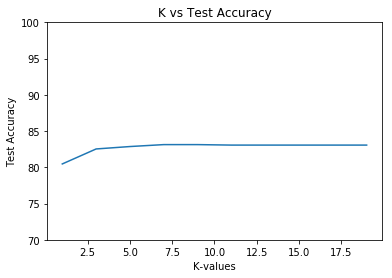

In [16]:
#This calculates the optimal value of k
k_list = list(range(1,20,2))
acc_list = []
for k in k_list:
    print(k)   #Just prints the value of k to check progress.
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)    ## Predicting the accuracy on test set
    acc_list.append(accuracy_score(Y_test, Y_pred, normalize=True) * float(100))
optimal_k = k_list[acc_list.index(max(acc_list))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(k_list, acc_list)
plt.xlabel('K-values')
plt.ylabel('Test Accuracy')
plt.title('K vs Test Accuracy')
plt.ylim(70, 100)
plt.show()

In [17]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)    ## Change the values of n_neighbors to the optimal value of k
classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [18]:
Y_pred = classifier.predict(X_test)  

In [19]:
acc = accuracy_score(Y_test, Y_pred, normalize=True) * float(100)   #Calculating accuracy
acc  

83.13333333333334

## This accuracy obtained cannot be considered as generalised accuracy as no cross - validation is performed

# KNN with cross - validation:

In [22]:
X_1, X_test, y_1, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)  
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size = 0.3, shuffle = False)   #Splitting the training values into cv and train

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 5.


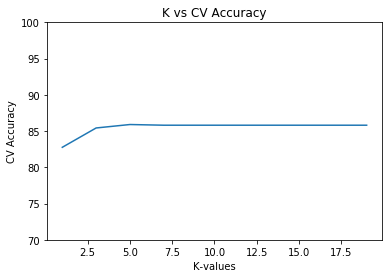

In [23]:
#This calculates the optimal value of k
k_list = list(range(1,20,2))
acc_list = []
for k in k_list:
    print(k)
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_cv)    ## Predicting the accuracy on CV set
    acc_list.append(accuracy_score(y_cv, y_pred, normalize=True) * float(100))
optimal_k = k_list[acc_list.index(max(acc_list))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(k_list, acc_list)
plt.xlabel('K-values')
plt.ylabel('CV Accuracy')
plt.title('K vs CV Accuracy')
plt.ylim(70,100)
plt.show()

In [24]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
y_pred = classifier.predict(X_test)

In [26]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)  #Calculating accuracy
acc

83.200000000000003

# KNN with 5 fold CV:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)

In [20]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 11.


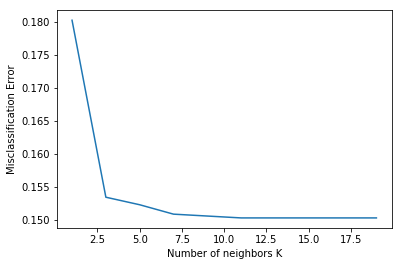

In [21]:
plt.plot(neighbors, MSE)   #Plotting graph for neighbors vs misclassification error.
plt.xlabel('Number of neighbors K')
plt.ylabel('Misclassification Error')  
plt.show()

In [22]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [23]:
y_pred = classifier.predict(X_test)

In [24]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
acc

81.86666666666666

# Performing KNN for TF-IDF:

In [5]:
X = tf_idf[:5000,:].toarray()  #taking 5000 points from calculated tf - idf vectors
type(X)

numpy.ndarray

In [6]:
df = pd.DataFrame(X)

In [7]:
df['Time'] = final['Time'].iloc[:5000]

In [8]:
df['Score'] = final['Score'].iloc[:5000]
type(df)

pandas.core.frame.DataFrame

In [10]:
df = df.sort_values(['Time'])   #sorting dataframe according to time
df

,0,1,2,3,4,5,6,7,8,9,...,71683,71684,71685,71686,71687,71688,71689,71690,Time,Score
2645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1067472000,1
3519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1093392000,1
3863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097107200,1
230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1101772800,1
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1105142400,1
2951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1105747200,1
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1107475200,1
4159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110067200,1
2904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1110326400,1
3591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1113264000,1


In [11]:
X = df.iloc[:,:71691].values  #creating a numpy array of tf-idf vectors
print(X[:5,:])
type(X)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


numpy.ndarray

In [12]:
y = df['Score'].values  #creating a numpy array of scores
type(y)
y[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [13]:
s = StandardScaler()  #Performing column standardization
X = s.fit_transform(X)
X[:5,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False) #Splitting data

In [15]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 3.


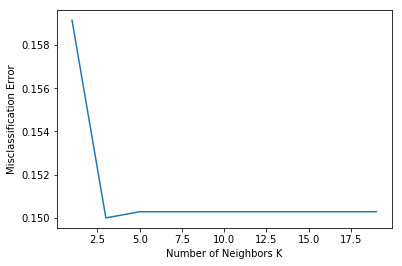

In [16]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [17]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [18]:
y_pred = classifier.predict(X_test)

In [19]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)

In [20]:
acc

82.0

#  Performing KNN for Average W2V model:

In [7]:
with open('google_word2vec_model','rb') as pickle_file:  #Loading the google w2v model
    google_w2v = pickle.load(pickle_file)

In [ ]:
with open('list_of_sent_for_input_to_w2v.pkl','rb') as pickle_file:  #reading the pickle file saved earlier
    list_of_sent = pickle.load(pickle_file)

In [8]:
type(google_w2v)

dict

In [9]:
google_w2v['life']  

array([ -6.78710938e-02,   9.52148438e-02,   3.56445312e-02,
         1.71875000e-01,   2.03125000e-01,   4.49218750e-02,
         1.25000000e-01,  -6.44531250e-02,   1.76757812e-01,
         6.20117188e-02,   8.83789062e-02,  -1.73828125e-01,
        -2.83203125e-01,   8.83789062e-02,  -1.00585938e-01,
         1.40625000e-01,   1.75781250e-01,   2.03125000e-01,
         4.90722656e-02,  -3.39355469e-02,  -1.32812500e-01,
        -1.72851562e-01,  -8.98437500e-02,   1.13769531e-01,
        -9.37500000e-02,  -1.10839844e-01,  -1.02539062e-01,
         1.02539062e-01,   1.36718750e-01,   5.76171875e-02,
         7.93457031e-03,  -1.17187500e-01,  -8.05664062e-02,
         1.17187500e-01,  -5.73730469e-02,   1.16210938e-01,
         1.17675781e-01,  -1.15234375e-01,  -1.63574219e-02,
        -1.77001953e-02,   4.54101562e-02,   2.36328125e-01,
        -6.49414062e-02,  -2.60009766e-02,   3.44238281e-02,
        -5.85937500e-02,   1.47460938e-01,   2.69531250e-01,
         4.80957031e-02,

In [10]:
len(list_of_sent)

364171

In [11]:
type(list_of_sent)

list

In [12]:
#This function calculates average w2v (seen earlier)
def cal_avg_w2v(list_of_sent, w2v_model):
    sent_vectors = []
    for sent in list_of_sent:
        sent_vec = np.zeros(300)
        cnt_words = 0
        for word in sent:
            try:
                vec = w2v_model[word]
                sent_vec += vec
                cnt_words +=1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [13]:
sent_vectors = cal_avg_w2v(list_of_sent,google_w2v) #Sending list of sentences and google's w2v model to the function

C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [99]:
type(sent_vectors)

list

In [ ]:
data =np.array(sent_vectors[:60000])  #Creating a numpy array of the sentence vector for 60k points`

In [ ]:
df = pd.DataFrame(data)

In [16]:
df['Time'] = final['Time'].iloc[:60000]
df.shape

(60000, 301)

In [17]:
df['Score'] = final['Score'].iloc[:60000]

In [14]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Time,Score
0,-0.015120,0.025875,0.009617,0.128916,-0.078413,0.008211,0.110026,-0.135179,0.046720,0.115583,...,-0.100761,0.023889,-0.030676,-0.026155,0.050528,-0.029526,0.022745,-0.016539,1336262400,1
1,-0.056586,0.062557,-0.089593,0.202637,-0.077491,0.065084,0.120917,0.033193,-0.013129,0.138441,...,-0.040402,0.137614,-0.012260,0.061686,-0.099955,-0.035655,0.047462,0.049099,1318032000,1
2,0.021497,-0.008093,0.052600,0.127332,-0.020068,0.059192,0.051868,-0.005231,0.124864,0.098145,...,-0.041125,0.002502,0.060367,0.018921,-0.030127,-0.087573,0.062781,-0.035674,1294531200,1
3,-0.031223,0.069350,-0.039519,0.167019,-0.049120,-0.010735,0.042182,-0.069472,-0.016201,0.086399,...,-0.108995,-0.057231,-0.028300,-0.055650,0.056261,0.022868,0.019965,-0.063043,1275696000,1
4,0.049184,0.051122,-0.038401,0.146566,0.013313,-0.000824,0.026805,-0.051055,0.073466,0.077123,...,-0.132195,0.042384,-0.107585,-0.069850,0.009094,0.026778,0.045471,0.108693,1311465600,1
5,-0.000715,0.005237,0.019202,0.191885,-0.039013,-0.005848,0.098608,-0.039688,0.063748,0.095112,...,-0.057880,0.058905,0.032518,-0.047129,-0.010146,0.019278,-0.024591,-0.052012,1255824000,1
6,0.007978,0.009723,-0.040728,0.190573,-0.021097,-0.050595,0.089040,-0.047880,-0.009859,0.159086,...,-0.068611,-0.044157,0.038177,0.018476,-0.007891,0.018537,0.047259,-0.055535,1333324800,1
7,0.049483,0.052546,-0.065066,0.106411,0.033286,0.032245,0.073345,-0.119118,0.021803,0.037287,...,-0.099415,0.023504,0.044942,0.011968,0.009941,0.081166,0.010515,-0.026523,1332028800,1
8,0.001795,-0.007370,0.013635,0.128344,-0.067407,0.005884,0.064675,-0.115398,0.004781,0.157619,...,-0.013928,0.025657,0.004341,-0.014657,0.046774,-0.023349,0.039386,0.000836,1340668800,1
9,-0.010165,0.017719,0.027548,0.118791,-0.063199,0.015482,0.112213,-0.095068,0.034309,0.069373,...,-0.045519,0.018704,-0.050858,-0.049771,-0.051035,-0.043224,0.013253,-0.044228,1320451200,0


In [44]:
df = df.reset_index(drop = True)

In [20]:
df = df.dropna(axis = 0)  #Removing any row with NaN values in the dataframe

In [21]:
df = df.sort_values(['Time'])  #Sorting the dataframe on Time
df

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Time,Score
46722,0.026636,0.020126,-0.100281,0.082568,-0.080322,0.032446,0.111238,-0.064941,-0.004712,0.031787,...,-0.117480,0.041696,-0.019724,-0.000677,0.054999,-0.003418,-0.005280,-0.034076,944092800,1
40133,0.059459,-0.003329,0.005965,0.156871,-0.025457,-0.019603,0.106640,-0.047674,0.048151,0.099837,...,-0.099476,-0.011941,-0.006203,-0.012562,0.019221,-0.022627,0.016418,-0.057722,947376000,1
24260,0.033886,0.073389,0.002451,0.093417,-0.125960,-0.027494,0.023870,-0.104447,0.072579,0.097673,...,-0.088900,0.054760,-0.006400,0.045331,0.036532,-0.018738,0.024657,0.012773,948672000,1
8478,0.052818,0.049506,-0.006696,0.081543,-0.010323,-0.044146,0.017099,-0.078924,0.084370,0.077232,...,-0.120003,0.016504,-0.020213,-0.024578,0.010915,-0.047077,0.020335,-0.049402,951523200,1
34415,0.071514,0.010827,0.032856,0.095999,-0.051633,-0.009737,0.014907,-0.117291,0.028133,0.061157,...,-0.023217,-0.001970,-0.059697,0.015644,0.112305,-0.148438,0.066587,-0.064190,965779200,1
54411,0.015391,0.016866,0.014053,0.145999,-0.033963,0.028730,0.064385,-0.055930,0.072012,0.061937,...,-0.088003,0.043796,-0.039354,-0.057113,0.003240,-0.044850,0.005933,-0.040065,966297600,1
31526,0.019709,-0.032198,-0.036291,0.176241,-0.033799,0.005116,0.062493,-0.063959,0.008793,0.041877,...,-0.093937,-0.039087,-0.084616,-0.037425,0.023161,-0.085126,0.004057,0.017125,977184000,1
38479,0.038328,0.016882,-0.041641,0.129957,-0.034559,0.025704,0.054421,-0.061632,0.115798,0.060436,...,-0.088591,0.013529,-0.015159,-0.038751,-0.007757,-0.038409,0.018693,-0.037952,997228800,0
55267,0.051904,0.034767,-0.006267,0.080595,-0.056493,-0.017777,0.074265,-0.019159,0.073326,0.075993,...,-0.089740,-0.024039,-0.001086,-0.064367,0.042698,-0.071228,-0.022865,-0.035428,1001289600,1
56359,0.003494,-0.020388,-0.011941,0.175654,-0.017348,0.028550,0.092889,-0.120065,0.031668,0.208954,...,-0.154431,-0.027468,-0.019135,-0.036375,0.005280,-0.036614,0.003722,0.064745,1010275200,1


In [22]:
X = df.iloc[:,:300].values   #Creating a numpy array of vectors
y = df['Score'].values       #Creating a numpy array of scores

In [23]:
s = StandardScaler()   #Performing Column Standardization
X = s.fit_transform(X)
X[:5,:]

array([[ 0.43134629, -0.43538196, -2.39643935, ...,  0.33060184,
        -0.86791752, -0.70888377],
       [ 1.30206064, -1.0515217 ,  0.33646669, ..., -0.13208203,
        -0.29546514, -1.32534879],
       [ 0.62366412,  0.96374973,  0.24608582, ..., -0.03839589,
        -0.07810562,  0.5125045 ],
       [ 1.12589096,  0.33636838,  0.01080927, ..., -0.72097546,
        -0.19213113, -1.10844812],
       [ 1.62184687, -0.67966892,  1.02816889, ..., -3.16238068,
         1.02811807, -1.49398085]])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data

In [25]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 11.


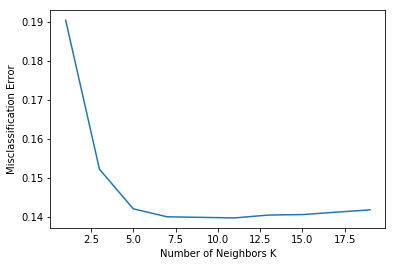

In [26]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [27]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [28]:
y_pred = classifier.predict(X_test)

In [29]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
acc

83.815767542641268

# Performing KNN for TF-IDF weighted average w2v:

In [ ]:
with open('tfidf_sent_vectors.pkl','rb') as pickle_file:  #Loading the pickle file saved earlier
    tfidf_sent_vectors = pickle.load(pickle_file)

In [94]:
X = np.array(tfidf_sent_vectors)

In [95]:
type(X)

numpy.ndarray

In [96]:
df = pd.DataFrame(X)

In [99]:
df['Time'] = final['Time'].iloc[:60000]  #Taking corresponding 60k timestamps

In [100]:
df['Score'] = final['Score'].iloc[:60000] #Taking corresponding Scores

In [101]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Time,Score
0,-0.000224,0.000403,-0.000073,-0.000347,-0.000121,-0.000056,0.000083,-0.000041,0.000053,-0.000088,...,-0.000185,-0.000045,-0.000103,0.000213,0.000277,-0.000120,0.000052,-0.000146,1336262400,1
1,-0.000072,0.000330,0.000452,0.000162,-0.000279,-0.000092,-0.000423,-0.000256,-0.000082,-0.000092,...,-0.000085,-0.000150,0.000007,-0.000103,-0.000287,0.000262,-0.000008,0.000275,1318032000,1
2,0.000763,0.000337,0.000631,0.000202,-0.000593,0.000079,0.000017,-0.000211,-0.000097,0.000100,...,-0.000169,0.000125,-0.000218,-0.000188,0.000302,-0.000031,0.000338,-0.000267,1294531200,1
3,-0.000251,0.000149,-0.000184,-0.000438,-0.000154,0.000235,0.000621,0.000373,0.000161,-0.000248,...,0.000648,-0.000246,0.000022,0.000484,0.000067,0.000278,0.000053,-0.000165,1275696000,1
4,0.000124,-0.000339,0.000119,0.000471,-0.000011,-0.000160,-0.000136,0.000053,0.000442,-0.000065,...,-0.000240,0.000159,-0.000474,0.000095,0.000124,0.000108,-0.000285,0.000453,1311465600,1


In [102]:
df = df.dropna(axis = 0)  #Removing rows with NaN values

18119698


In [104]:
df.shape

(59999, 302)

In [103]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Time,Score
0,-0.000224,0.000403,-0.000073,-0.000347,-0.000121,-0.000056,0.000083,-0.000041,0.000053,-0.000088,...,-0.000185,-0.000045,-0.000103,0.000213,0.000277,-0.000120,0.000052,-0.000146,1336262400,1
1,-0.000072,0.000330,0.000452,0.000162,-0.000279,-0.000092,-0.000423,-0.000256,-0.000082,-0.000092,...,-0.000085,-0.000150,0.000007,-0.000103,-0.000287,0.000262,-0.000008,0.000275,1318032000,1
2,0.000763,0.000337,0.000631,0.000202,-0.000593,0.000079,0.000017,-0.000211,-0.000097,0.000100,...,-0.000169,0.000125,-0.000218,-0.000188,0.000302,-0.000031,0.000338,-0.000267,1294531200,1
3,-0.000251,0.000149,-0.000184,-0.000438,-0.000154,0.000235,0.000621,0.000373,0.000161,-0.000248,...,0.000648,-0.000246,0.000022,0.000484,0.000067,0.000278,0.000053,-0.000165,1275696000,1
4,0.000124,-0.000339,0.000119,0.000471,-0.000011,-0.000160,-0.000136,0.000053,0.000442,-0.000065,...,-0.000240,0.000159,-0.000474,0.000095,0.000124,0.000108,-0.000285,0.000453,1311465600,1


In [105]:
df = df.sort_values('Time')  #sorting on time
df

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Time,Score
46722,-0.000371,0.000240,-0.000175,-0.000035,-0.000322,0.000327,-0.000247,-0.000498,-0.000312,0.000450,...,-0.000189,0.000365,-0.000201,0.000490,1.406332e-04,1.849818e-04,-0.000378,0.000117,944092800,1
40133,-0.000460,0.000542,-0.000533,0.000251,-0.000339,0.000092,-0.000332,-0.000195,-0.000110,0.000336,...,-0.000243,0.000228,0.000027,0.000223,9.831883e-05,3.784239e-04,0.000044,-0.000091,947376000,1
24260,0.000254,-0.000041,-0.000065,0.000359,0.000110,0.000181,0.000458,-0.000245,0.000406,-0.000510,...,0.000297,-0.000406,0.000081,0.000221,-1.656124e-04,-2.979860e-04,0.000537,0.000513,948672000,1
8478,0.000085,-0.000010,-0.000266,-0.000052,0.000126,-0.000172,-0.000127,-0.000065,-0.000105,-0.000094,...,-0.000297,-0.000091,0.000041,-0.000207,8.900060e-05,1.496932e-05,-0.000267,0.000074,951523200,1
34415,0.000044,-0.000423,-0.000287,-0.000074,0.000363,-0.000028,0.000291,-0.000100,-0.000370,0.000382,...,0.000461,-0.000358,0.000341,-0.000078,5.069701e-05,2.527365e-04,-0.000296,0.000150,965779200,1
54411,0.000043,-0.000219,0.000040,0.000099,0.000391,0.000325,-0.000019,-0.000028,-0.000035,-0.000501,...,0.000253,-0.000473,-0.000548,0.000022,-3.041528e-04,-1.116078e-04,0.000472,0.000564,966297600,1
31526,-0.000103,0.000127,-0.000645,-0.000167,-0.000399,-0.000055,-0.000504,-0.000017,-0.000335,0.000022,...,0.000123,-0.000026,0.000221,-0.000064,-3.232211e-06,-2.252897e-04,0.000122,-0.000696,977184000,1
38479,-0.000640,-0.000051,0.000411,-0.000017,0.000236,0.000480,-0.000284,-0.000148,0.000045,-0.000254,...,-0.000497,0.000185,-0.000463,-0.000244,-3.292007e-04,-4.132907e-05,0.000225,0.000558,997228800,0
55267,0.000173,0.000019,0.000225,-0.000163,-0.000411,0.000635,0.000301,-0.000244,0.000024,-0.000181,...,-0.000322,0.000252,-0.000182,-0.000050,5.180951e-05,3.472715e-04,-0.000270,0.000452,1001289600,1
56359,-0.000502,0.000392,-0.000301,0.000477,0.000451,-0.000287,0.000062,0.000325,-0.000041,0.000092,...,-0.000279,0.000384,0.000413,-0.000316,-4.348653e-07,-2.641140e-04,-0.000353,0.000088,1010275200,1


In [106]:
X = df.iloc[:,:300].values #Creating a numpy array of vectors
print(X[:5,:])
X.shape

[[ -3.70879439e-04   2.39644176e-04  -1.75050255e-04 ...,   1.84981785e-04
   -3.77866369e-04   1.17409948e-04]
 [ -4.60164330e-04   5.41596125e-04  -5.32546724e-04 ...,   3.78423851e-04
    4.41692193e-05  -9.14695702e-05]
 [  2.54281268e-04  -4.05251467e-05  -6.51802650e-05 ...,  -2.97986037e-04
    5.36933717e-04   5.12779541e-04]
 [  8.49134159e-05  -1.03907632e-05  -2.65799974e-04 ...,   1.49693236e-05
   -2.66671950e-04   7.41439969e-05]
 [  4.38568702e-05  -4.23463789e-04  -2.87059156e-04 ...,   2.52736489e-04
   -2.96215801e-04   1.50305882e-04]]


(59999, 300)

In [107]:
y = df.iloc[:,301].values  #Creating a numpy array of Scores
print(y[:5]) 
type(y)

[1 1 1 1 1]


numpy.ndarray

In [108]:
s = StandardScaler()  #Performing Column Standardization
X = s.fit_transform(X)
X[:5,:]

array([[-1.34215686,  1.00810974, -0.80357577, ...,  0.45095197,
        -1.32250659,  0.31978503],
       [-1.67052083,  2.13535142, -2.12469209, ...,  1.14667013,
         0.3236031 , -0.43507455],
       [ 0.95700312, -0.03781343, -0.39755488, ..., -1.28605123,
         2.24558418,  1.74859208],
       [ 0.33411722,  0.07468372, -1.13893834, ..., -0.16050117,
        -0.88880333,  0.16342831],
       [ 0.18312314, -1.4673932 , -1.21750094, ...,  0.69463308,
        -1.00403631,  0.43866606]])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) #splitting data

In [113]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 19.


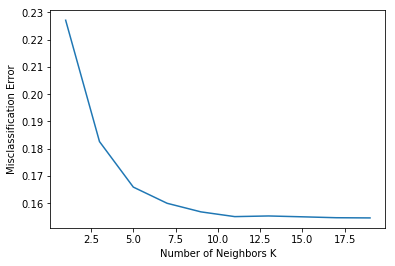

In [114]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [115]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')

In [116]:
y_pred = classifier.predict(X_test)

In [117]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)  #calculating accuracy
acc

84.838888888888889